**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
October 30, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

**Group 5 Members**

Veerav Chebrolu

Hammad Aamer

Yufan Feng

Ruicong Rong

# **Assignment 1: “Word Embeddings and Probabilistic Language Models”**
**Due**: Monday, November 13, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: F.R.I.E.N.D.S and  Word2Vec (Grade (2 + 2 + 4) = 8)**

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

### Subtask 1: Pre-processing
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that  determines which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains a line from the movie and the `author` is the one who said it. Since these are the only two columns we need, we remove the rest and only keep these two columns.

In [1]:
import re
import pandas as pd
from collections import defaultdict
import spacy
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

✅ Point distribution ✅
- 0.5 points. 'author' and 'quote' are filtered

In [2]:
df = pd.read_csv("friends_quotes.csv") ### Load the data ####
### filter out columns ###
df = df[['quote', 'author']]
df.head(10)

,quote,author
0,There's nothing to tell! He's just some guy I ...,Monica
1,"C'mon, you're going out with the guy! There's ...",Joey
2,"All right Joey, be nice. So does he have a hum...",Chandler
3,"Wait, does he eat chalk?",Phoebe
4,"Just, 'cause, I don't want her to go through w...",Phoebe
5,"Okay, everybody relax. This is not even a date...",Monica
6,Sounds like a date to me.,Chandler
7,"Alright, so I'm back in high school, I'm stand...",Chandler
8,"Oh, yeah. Had that dream.",All
9,"Then I look down, and I realize there's a phon...",Chandler


Fortunately, there is no missing data, so we do not need to worry about that.

In [3]:
df.isnull().sum() # check for missing data

quote     0
author    0
dtype: int64

Use SpaCy to preprocess the text. For this, perform the following steps:
- lowercase the words
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits.
- remove lines that have less than 4 words, since they cannot contribute much to the training process.

Please do not add any additional steps on your own or additional cleaning as we want to achieve comparable results.

✅ Point distribution ✅
- 0.5 points. All steps performed.

In [4]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS
# Define functions to prepare statements
def preprocess_quote(quote):
    # Convert sentences to lowercase
    quote = quote.lower()


    # Tokenization and removal of stop words and single characters using SpaCy
    doc = nlp(quote)
    tokens = [token.text for token in doc if token.text not in stopwords and len(token.text) > 1]

    # Save processed sentences to list
    quote= ' '.join(tokens)

    # Remove non-alphanumeric characters using regular expression
    quote = re.sub(r'[^a-zA-Z0-9 ]', '', quote)
    return quote

df["quote"] = df["quote"].apply(preprocess_quote) # lowercase and remove non-alphabetic characters
# Remove lines with less than 4 words
df = df[df["quote"].apply(lambda x: len(x.split()) >= 4)]

quotes =df["quote"].tolist() # to save all the lines

### Your Code ###
df.head(10)

/Users/simon/opt/anaconda3/envs/INLPT/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,quote,author
1,cm going guy got ta wrong,Joey
2,right joey nice hump hump hairpiece,Chandler
4,cause want went carl oh,Phoebe
5,okay everybody relax date people going dinner ...,Monica
7,alright high school standing middle cafeteria ...,Chandler
14,sudden phone starts ring know everybody starts...,Chandler
16,finally figure better answer turns mother weir...,Chandler
18,guy says hello wanna kill,Joey
20,feel like reached throat grabbed small intesti...,Ross
22,explaining carol moved stuff today,Monica


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, in order to keep the computation time-limited and to choose the most important words.

✅ Point distribution ✅
- 0.5 points. phrases (bi-grams) are correctly identified.

In [5]:
from gensim.models.phrases import Phrases, Phraser
from collections import Counter

words = []#list of all words#

for quote in quotes:
    words.extend(quote.split())

# Use Gensim’s Phrases class to detect common phrases (bigrams)
bigram = Phrases([words], min_count=10)

phrases = Phraser(bigram)#define the phraser for bi-gram creation#

new_lines = [phrases[quote.split()] for quote in quotes] #transform the lines#

# Added during cross feedback
print(new_lines[:5])

# Count frequency of words and phrases
word_freq = Counter(words)
phrase_freq = Counter([phrase for line in new_lines for phrase in line])



INFO - 13:38:10: collecting all words and their counts
INFO - 13:38:10: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:38:10: collected 180111 token types (unigram + bigrams) from a corpus of 262560 words and 1 sentences
INFO - 13:38:10: merged Phrases<180111 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 13:38:10: Phrases lifecycle event {'msg': 'built Phrases<180111 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.32s', 'datetime': '2023-11-18T13:38:10.377548', 'gensim': '4.3.2', 'python': '3.9.18 (main, Sep 11 2023, 08:38:23) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 13:38:10: exporting phrases from Phrases<180111 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 13:38:10: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<220 phrases, min_count=10, threshold=10.0> from Phrases<180111 vocab, min_count=10, threshold=10.0, max_vocab_size=40000

[['cm', 'going', 'guy', 'got_ta', 'wrong'], ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'], ['cause', 'want', 'went', 'carl', 'oh'], ['okay', 'everybody', 'relax', 'date', 'people', 'going', 'dinner', 'and', 'having_sex'], ['alright', 'high_school', 'standing', 'middle', 'cafeteria', 'realize', 'totally', 'naked']]


✅ Point distribution ✅
- 0 points. Less than 50 words/bigrams matched.

In [6]:
### find the top words for the vocabulary###
vocab=[word for word, freq in word_freq.most_common(15000)]
top_phrases = [phrase for phrase, freq in phrase_freq.most_common(15000)]###top words ###

# Added during cross feedback
top_phrases[:50]

['oh',
 'know',
 'okay',
 'yeah',
 'right',
 'like',
 'hey',
 'ross',
 'yknow',
 'gon_na',
 'look',
 'uh',
 'its',
 'think',
 'joey',
 'im',
 'mean',
 'chandler',
 'rachel',
 'dont',
 'monica',
 'got',
 'come',
 'youre',
 'want',
 'guys',
 'phoebe',
 'good',
 'going',
 'little',
 'time',
 'thats',
 'guy',
 'tell',
 'great',
 'ok',
 'oh_god',
 'thing',
 'love',
 'way',
 'umm',
 'maybe',
 'let',
 'said',
 'looks',
 'sorry',
 'hi',
 'people',
 'wanna',
 'yes']

✅ Point distribution ✅

- 0 points: `word_freq['central_perk']` value is `36` for any other value zero points.
- 0 points: `word_freq['joey']` is 1879 for any other value zero points.

In [11]:
word_freq['central_perk']

0

In [7]:
word_freq['joey']

1936

####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
1.5 points assigned. 

The solution of group 5 is not correct, because central_perk doesn't appear at all. 
The spacy preprocessing could've been performed faster using a vectorized numpy approach instead of .apply. 

It appears, that the usage of Phraser during building of the vocabulary of the words and word combinations leads to a different list of top 50 words/bigrams. 
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Training the Model


Use the Gensim implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters; define your parameters in such a way that the following conditions are satisfied:
 - ignore all words that have a total frequency of less than 2.
 - dimensions of the embeddings: 100
 - initial learning rate (step size) of 0.03
 - 20 negative samples
 - window size 3
 - the learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [13]:
from gensim.models import Word2Vec
def hash(astring):
    return ord(astring[0])

✅ Point distribution ✅
- 1.5 points. All the 8 hyper-parameters mentioned in the question are covered.

In [14]:
w2v = Word2Vec(
    sentences=new_lines,  # Your preprocessed sentences
    min_count=2,
    vector_size=100,  # Corrected parameter name
    alpha=0.03,
    sg=1,  # Skip-gram model
    negative=20,
    window=3,
    min_alpha=0.0001,
    sample=6e-5,
    hashfxn=hash,
    workers=1,  # Train on a single worker
)

2) Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
Use the `build_vocab` function to process the data. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus.

✅ Point distribution ✅
- 0.5 points. Vocabulary table is built correctly with `new_lines`.

In [15]:
w2v.build_vocab(new_lines)### your code ###

3) Finally, we  train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis.

✅ Point distribution ✅
- 1 point. Training of word2vec model is carried out.

In [16]:
w2v.train(new_lines, total_examples=w2v.corpus_count, epochs=100)
w2v.init_sims(replace=True)

<ipython-input-16-f2a3a27e0c91>:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


####${\color{red}{Comments\ 1.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
3 points assigned. 

The solution of group 5 exactly the same as the sample solution.
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset:

We look for the most similar words to the name of the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



✅ Point distribution ✅
- 0.25 points. The answers don't match exactly but are quite close, which indicates, that the embedding was done correctly overall. 

In [17]:
###your code###
# Find the most similar words to "central_perk" and "joey"
most_similar_to_central_perk = w2v.wv.most_similar("central_perk")
most_similar_to_joey = w2v.wv.most_similar("joey")

In [18]:
###your code###
#Print all the similarities
print("Most similar to central_perk is:",most_similar_to_central_perk)
print("Most similar to joey is:",most_similar_to_joey)

Most similar to central_perk is: [('to', 0.5946870446205139), ('thatscene', 0.5921310186386108), ('itscene', 0.5848673582077026), ('mitzi', 0.5815681219100952), ('back', 0.5718855857849121), ('conan', 0.5650569796562195), ('universal', 0.548994779586792), ('hippity', 0.5409781336784363), ('rehearsing', 0.5170654654502869), ('sitting_couch', 0.5162811279296875)]
Most similar to joey is: [('chandler', 0.901344358921051), ('ross', 0.8806270956993103), ('rachel', 0.8233027458190918), ('monica', 0.8212666511535645), ('hey', 0.8158588409423828), ('right', 0.8134961128234863), ('looks', 0.8132343292236328), ('oh', 0.8091073036193848), ('phoebe', 0.7964804172515869), ('yeah', 0.7886868715286255)]


Look at the similarity of `green` to `rachel` (her lastname) and `ross`  and `spaceship` (urelated). The first one should have a high and the second a low score. Finally, look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

✅ Point distribution ✅
- 0.25 points. Sample solution uses wrong words for similarity. 

In [19]:
###your code###
# Find the similarity between "green" and "rachel"
similarity_green_rachel = w2v.wv.similarity("rachel", "green")
print("Similarity between green and rachel's last name:", similarity_green_rachel)

Similarity between green and rachel's last name: 0.30941224


✅ Point distribution ✅
- 0 points. 

In [20]:
###your code###
# Find the similarity between "ross" and "spaceship"
similarity_ross_spaceship = w2v.wv.similarity("ross", "spaceship")
print("Similarity between ross and spaceship:", similarity_ross_spaceship)

Similarity between ross and spaceship: 0.31724736


✅ Point distribution ✅
- 0.25 points. Similarity is not exactly the same but also relativly high.

In [21]:
###your code###
# Find the similarity between "smelly_cat" and "song"
similarity_smelly_cat_song = w2v.wv.similarity("smelly_cat", "song")
print("Similarity between smelly_cat and song:", similarity_smelly_cat_song)

Similarity between smelly_cat and song: 0.42602137


We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar?


In [22]:
character_names= ['joey', 'rachel', 'phoebe','monica','chandler']

✅ Point distribution ✅
- 0 points.

In [23]:
w2v.wv.doesnt_match(character_names)### your code###

'joey'

Based on the analogies, which word is to `monica` as `man` is to `women`? (print the top 3 words); you should get `chandler`among the answers.

✅ Point distribution ✅
- 0 points

In [24]:
w2v.wv.most_similar(positive=["monica", "man"], negative=["women"], topn=3)### your code###

[('chandler', 0.7361404299736023),
 ('joey', 0.7076676487922668),
 ('phoebe', 0.6964852213859558)]

Finally, lets use [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [26]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimilar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    embs = np.append(embs, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    all_sims = model.wv.most_similar([word], topn=sys.maxsize)
    far_words = list(reversed(all_sims[-10:]))

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, wrd_vector, axis=0)

    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, wrd_vector, axis=0)

    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=110, perplexity=15).fit_transform(embs)

    # sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)

    # basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)

    plt.title('t-SNE visualization for {}'.format(word.title()))


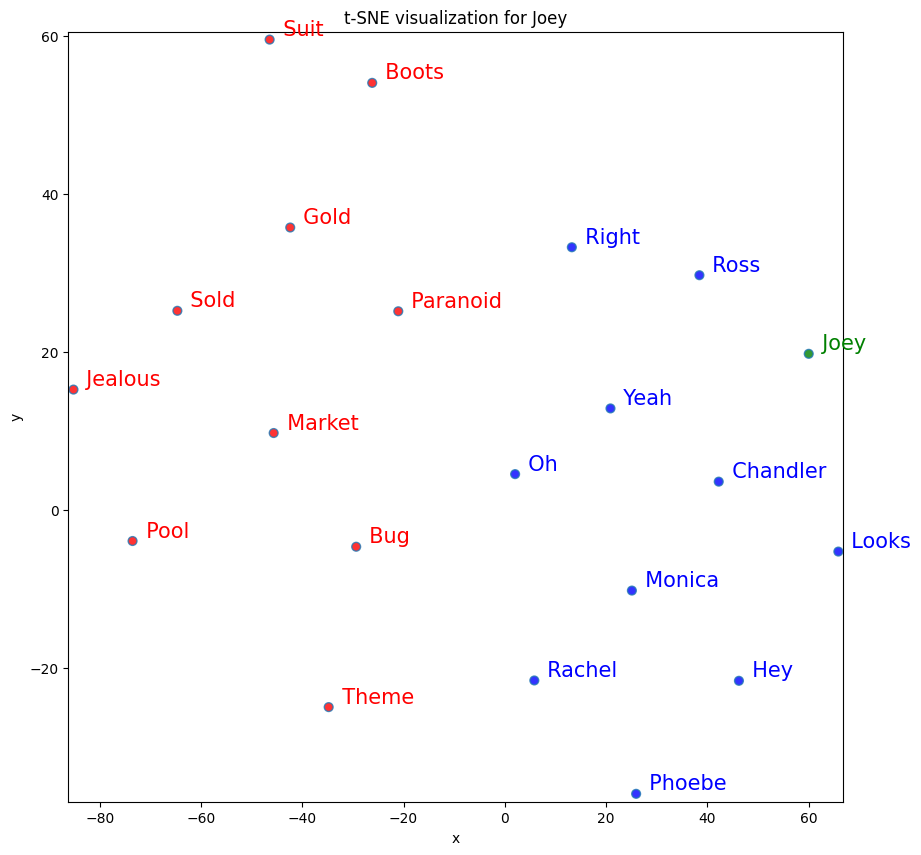

In [27]:
tsneplot(w2v, 'joey')

####${\color{red}{Comments\ 1.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
0.75 points assigned. 

The solutions are close to the sample solution, since the words/bigrams from the previous tasks are not exactly the same. However, it seems, that the word embeddings were learned correctly on these word/bigrams. Therefore I assigned a few points. 
```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 2: Questions on the Conceptual Level (non-programming) (Grade (2 + 1 + 1 + 4) = 8)**

Please answer the following questions in the notebook cells using markdown. Be precise and short.

### Subtask 1: For gradient descent, what advantage has a decaying learning rate?

**Faster Convergence in the Beginning**:

Using a higher learning rate in the early stages of training can help the model converge more quickly. A larger learning rate allows for larger updates to the model parameters, helping the optimization algorithm make faster progress in the beginning when the parameters are far from the optimal values.

**Stability in the Later Stages:**

As training progresses and the model approaches the optimal parameter values, a decaying learning rate helps to stabilize the convergence. Smaller learning rates prevent the model from overshooting the minimum and oscillating around the optimal values.

**Escape from Local Minima:**

 A decaying learning rate can help the algorithm escape from local minima. By initially taking larger steps to explore the solution space and then refining the search with smaller steps, the algorithm may find a better optimal solution.

####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
2 main points are included, plus one extra point regarding local minima.

2/2 points
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

 Firstly, the usage of log improves the  **numerical stability**, especially when dealing with probabilities which involves multiplying small numbers.

Calculating the log-likelihood involves sums, which are more **computationally efficient** than products.

Taking the logarithm **simplifies** the process of finding derivatives.

Maximizing the likelihood or maximizing the log-likelihood is equivalent, as the logarithm is a **monotonic** transformation.


####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
1/1 point
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Name one advantage that fastText has over Word2Vec?

fastText can provide embeddings for **Out-Of-Vocabulary** words while Word2Vec cannot, fastText can also provide better embeddings for morphologically rich languages compared to word2vec.

fastText breaks words into smaller subword units called character **n-grams**. This allows fastText to capture the meaning of words even if they were not seen during training or to handle **morphologically rich** languages where words may have common prefixes or suffixes.

####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
1/1 point
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Compute the partial derivate of softmax loss for word2vec with

---

respect to the center word vector.
$$ \frac{\partial J}{\partial v_c} =\frac{\partial}{\partial v_c}\left[ -log \left( \frac{exp(u^T_o v_c)}{\Sigma_{w \in Vocab} exp(u^T_o v_c)} \right)\right] $$
use $U$ to denote the matrix of all embeddings and $y$ for a one-hot vector with a 1 for the true outside word $o$, and $\hat{y}$ for the predicted distribution $P(w|c)$.

Using the chain rule of differentiation:

$$ \frac{\partial J}{\partial v_c} = -\frac{1}{\frac{e^{u_o^T v_c}}{\sum_{w \in \text{Vocab}} e^{u_w^T v_c}}} \cdot \frac{\partial}{\partial v_c}\left(\frac{e^{u_o^T v_c}}{\sum_{w \in \text{Vocab}} e^{u_w^T v_c}}\right) $$
Differentiating the inside part of the expression:

  $$  \frac{\partial}{\partial v_c}\left(\frac{e^{u_o^T v_c}}{\sum_{w \in \text{Vocab}} e^{u_w^T v_c}}\right)  $$

   We will use \(U\) to denote the matrix of all embeddings, \(y\) for the one-hot vector with a 1 for the true outside word \(o\), and $(\hat{y})$ for the predicted distribution \(P(w|c)\).

  $$  \frac{\partial}{\partial v_c}\left(\frac{e^{u_o^T v_c}}{\sum_{w \in \text{Vocab}} e^{u_w^T v_c}}\right) = \frac{\partial}{\partial v_c}\left(\frac{e^{(Uv_c)_o}}{\sum_{w \in \text{Vocab}} e^{(Uv_c)_w}}\right)  $$

Differentiating the numerator and denominator separately:

   $$  \frac{\partial}{\partial v_c}\left(\frac{e^{(Uv_c)_o}}{\sum_{w \in \text{Vocab}} e^{(Uv_c)_w}}\right) = \frac{e^{(Uv_c)_o} \cdot \frac{\partial}{\partial v_c}(Uv_c)_o - \frac{e^{(Uv_c)_o}}{\sum_{w \in \text{Vocab}} e^{(Uv_c)_w}} \cdot \frac{\partial}{\partial v_c}\left(\sum_{w \in \text{Vocab}} e^{(Uv_c)_w}\right)}{\left(\sum_{w \in \text{Vocab}} e^{(Uv_c)_w}\right)^2}  $$

Simplify the expression:

  $$  \frac{\partial J}{\partial v_c} = -\left(\hat{y} - y\right) \cdot U  $$



####${\color{red}{Comments\ 2.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
I do not see how the simpflication is done here, seems like several steps have been skipped. The end result is wrong by a negativ sign. The ² in the denominator of the large equations suggests that the quotient rule has been used. However, this has been done incorrectly. You have used u'(x) - (u(x)/v(x))'*v'(x) which is wrong.

Since this solution takes another valid option to derive the equation and the three first step are correct I'll give 2,5/4 points. 
```

$\left(\frac{u(x)}{v(x)}\right)' = \frac{u'(x)v(x) - u(x)v'(x)}{(v(x))^2}$

${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 3: Auto-Complete Feature (Grade (2 + 6 + 4) = 12)**

Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]

By the end of this assignment, you will develop a simple prototype of such a system using n-gram language model. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word.

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language model by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Subtask 1: Load and Preprocess Data
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where the individual tweets are separated by `\n`

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("/content/twitter.txt", "r") as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.)
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [ ]:
sentences = data.split('\n') #split
sentences = [sentence.strip() for sentence in sentences] #remove spaces
sentences = [sentence for sentence in sentences if len(sentence)>1] #drop empty sentences


${\color{red}{⚠️Comments\ begin⚠️}}$


``` The performance can be increased by using only 1 for loop. Alternatively it could also be vectorized by using numpy. Furthermore the if statement is incorrect, it should be if len(senteces) > 0 instead of 1 ```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
0.25 / 0.25 Points


In [ ]:
tokenized_corpus = [nlp(sentence) for sentence in sentences]
x = []
for token in tokenized_corpus:
  x.append([t.text.lower() for t in token])

tokenized_corpus = x

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



${\color{red}{⚠️Comments\ begin⚠️}}$


```
The solution is practically equivalent

```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
0.25 / 0.25 Points


In [ ]:
from random import Random
Random(4).shuffle(tokenized_corpus)

train = tokenized_corpus[:int(0.8*len(tokenized_corpus))]
test = tokenized_corpus[int(0.8*len(tokenized_corpus)):]


${\color{red}{⚠️Comments\ begin⚠️}}$


```
The solution is identical to the sample solution

```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
0.5 / 0.5 Points

In [ ]:
from collections import Counter

flatten_corpus = [word for sentence in tokenized_corpus for word in sentence]  # Flatten the train corpus
word_counts = Counter(flatten_corpus)

vocab = [word for word, count in word_counts.items() if count >= 2]  # Keep only the ones with frequency greater than or equal to 2
print(len(vocab))  # should be 14861

train_replaced = []
for sentence in train:
    replaced_sentence = [word if word in vocab else "<unk>" for word in sentence]
    train_replaced.append(replaced_sentence)

test_replaced = []
for sentence in test:
    replaced_sentence = [word if word in vocab else "<unk>" for word in sentence]
    test_replaced.append(replaced_sentence)

16928



${\color{red}{⚠️Comments\ begin⚠️}}$


```
The vocab contains duplicates, which is why the print is not equal to the sample solution. unk is tackled correctly.

```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
0.5 / 1 Points

####${\color{red}{Comments\ 3.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Overall 1.5 / 2 Points
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: N-gram Based Language Model:
In this section, you will develop an n-grams language model [**1. Large Language Models (LLMs), slide 1-24**]. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word '$w_t$' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will:
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below.

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

In [ ]:
import collections

def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n

    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram

    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token = '<s>'
    end_token = '<e>'

    n_grams = collections.defaultdict(int)
    for sentence in corpus:
        if n > 2:
            sentence = [start_token] + sentence + [end_token] ### add start and end tokens ###
        else:
            sentence = [start_token] * (n - 1) + sentence + [end_token] * (n - 1) ### add start and end tokens ###

        # convert list to tuple so it can be used as the key in the dictionary
        sentence = tuple(sentence)

        # iterate over the n-grams in the sentence
        for i in range(len(sentence) - n + 1):
            ngram = tuple(sentence[i:i+n])
            n_grams[ngram] += 1

    return n_grams


${\color{red}{⚠️Comments\ begin⚠️}}$


``` Start and end tokens are incorrectly added to the sentence. The start token needs to be added n times for an n gramm and the end token only once. A distinction between the n's is not necessary. The rest of the function seems to be correct. ```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
1 / 2 Points


The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [ ]:
def probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size):
    """
    Estimate the probabilities of the next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary

    Returns: A probability
    """
    k = 1.0
    prev_n_gram = tuple(prev_n_gram)

    prev_n_gram_cnt = n_gram_cnts[prev_n_gram] # get the previous n-gram count from the dictionary
    denominator = prev_n_gram_cnt + k * vocab_size # denominator with the previous n-gram count and k-smoothing
    plus_current_gram = prev_n_gram + tuple([word]) # add the current word to the n-gram
    plus_current_gram_cnt = plus_current_gram_cnts[plus_current_gram] # get the current n-gram count using the dictionary
    numerator = plus_current_gram_cnt + k # calculate the numerator with k-smoothing
    prob = numerator / denominator

    return prob


${\color{red}{⚠️Comments\ begin⚠️}}$


```
The function is implemented correctly with only slight differences in the acccess of the dictionary values.
```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
2 / 2 Points


Let's use the functions we have defined to calculate probabilities for all possible words.


In [ ]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words

    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)

    vocab = vocab + ["<e>", "<s>", "<unk>"] # add <e> <unk> to the vocabulary

    vocab_size = len(vocab) # compute the size

    probabilities = {}
    for word in vocab:
        probabilities[word] = probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size)

    return probabilities

In [ ]:
# Predict the probability of all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.


{'and': 0.05,
 'mars': 0.05,
 'stars': 0.05,
 'is': 0.05,
 'tonight': 0.05,
 'shinnig': 0.05,
 'are': 0.05,
 'plants': 0.05,
 'a': 0.05,
 'the': 0.05,
 'plant': 0.05,
 'moon': 0.2,
 'shining': 0.05,
 'bright': 0.05,
 '<e>': 0.05,
 '<s>': 0.05,
 '<unk>': 0.05}

${\color{red}{⚠️Comments\ begin⚠️}}$


``` Moon has the highest probability but not the 0.25 specified in the requirements. Since in the moodle forum there is a discussion that this has to do with the ngram dict bein initialized via defaultdict(int) instead of defaultdict(lambda:1) and we should disregard that, I cannot substract points here, since this is a follow up error. ```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
2 / 2 Points


####${\color{red}{Comments\ 3.2}}$
${\color{red}{⚠️Comments\ begin⚠️}}$


```
Overall 5 / 6 points

```


${\color{red}{⚠️Comments\ end⚠️}}$



### Subtask 3: Evaluation

In this part, we use the perplexity score to evaluate your model on the test set. The perplexity score of the test set on an n-gram model is defined as follows:

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.
- $W$ is the n-gram

Notice that we have already computed this probability.

The higher the probabilities are, the lower the perplexity will be.

In [ ]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant

    Returns: Perplexity score for a single sentence
    """

    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts

    sentence = ["<s>"] + sentence + ["<e>"] # prepend <s> and append <e>
    sentence = tuple(sentence)
    N = len(sentence) # length of sentence


    product_pi = 1.0

    ### Compute the product of probabilities ###

    for t in range(n, N):
        n_gram = sentence[t - n:t] # get the n-gram before the predicted word (n-gram before t )
        word = sentence[t] # get the word to be predicted (position t)
        prob = probability(word, n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size) # your code instead of ....
        product_pi *= prob  # Update the product of the probabilities

    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    return perplexity

${\color{red}{⚠️Comments\ begin⚠️}}$


``` The sentences are again missing the correct ammount of start tokens (only one instead of n times). Also, the product_pi is incorrectly calculated. It should have been *= 1 / prob instead of *= prob. ```


${\color{red}{⚠️Comments\ end⚠️}}$

✅ Point distribution ✅ \\
Since the for loop is wrong:
0 / 1 Points


Use `perplexity` function to find the perplexity of a bi-gram model on the first training sample and on the first test sample (first element of the set).

In [ ]:
bigram_counts = n_grams_counts(train_replaced, 2) ### your code ###
trigram_counts = n_grams_counts(train_replaced, 3) ### your code ###

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the perplexity for the train sample should be much lower

Perplexity for first train sample: 0.0096
Perplexity for test sample: 0.0003



${\color{red}{⚠️Comments\ begin⚠️}}$


```
The perplexeties are completely off because of the previous errors```


${\color{red}{⚠️Comments\ end⚠️}}$


✅ Point distribution ✅ \\
0 / 1 Points

Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [ ]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word

    Returns: (most likely next word,  probability)
    """
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts
    previous_n_gram = previous_tokens[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    probabs = probabilities(previous_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab)  # Estimate the probabilities for each word in the vocabulary

    if start_with is not None:  #if start_with is specified then return the highest probability word that starts with that specific character
        probabs = {word: prob for word, prob in probabs.items() if word.startswith(start_with)}

    probabs = sorted(probabs.items(), key=lambda x: x[1], reverse=True)   ### sort the probability for higher to lower and return the highest probability word,probability tuple

    return probabs[:10]



${\color{red}{⚠️Comments\ begin⚠️}}$


``` The returns are not correct as a list of the top 10 suggestions is returned instead of the most probable word. Otherwise, the starts_with issue is tackled correctly ```

${\color{red}{⚠️Comments\ end⚠️}}$


Test your model based on the bi-gram model created on the training corpus.

✅ Point distribution ✅

0 / 0.5



In [ ]:
previous_tokens=['i','like']
start_with='b'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

[('better', 0.00011710973181871414),
 ('boys', 0.00011710973181871414),
 ('being', 0.00011710973181871414),
 ('baseball', 0.00011710973181871414),
 ('basic', 0.00011710973181871414),
 ('bon', 0.00011710973181871414),
 ('be', 5.855486590935707e-05),
 ('best', 5.855486590935707e-05),
 ('band', 5.855486590935707e-05),
 ('b', 5.855486590935707e-05)]

✅ Point distribution ✅

0.5 / 0.5 Points

In [ ]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

[('see', 0.0005286343612334801),
 ('be', 0.0004698972099853157),
 ('go', 0.0002936857562408223),
 ('meet', 0.0002936857562408223),
 ('think', 0.0002936857562408223),
 ('hear', 0.0002936857562408223),
 ('have', 0.00023494860499265785),
 ('do', 0.00023494860499265785),
 ('take', 0.00023494860499265785),
 ('"', 0.0001762114537444934)]

✅ Point distribution ✅

0.5 / 0.5 Points



In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

[('<unk>', 0.000353898784947505),
 ('riley', 0.0001769493924737525),
 ('in', 0.00011796626164916834),
 ('my', 0.00011796626164916834),
 ('"', 0.00011796626164916834),
 ('now', 0.00011796626164916834),
 ('(', 0.00011796626164916834),
 ('never', 0.00011796626164916834),
 ('old', 0.00011796626164916834),
 ('monique', 0.00011796626164916834)]

✅ Point distribution ✅

0.5 / 0.5 Points

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with='a'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

[('allison', 0.00011796626164916834),
 ('at', 5.898313082458417e-05),
 ('age', 5.898313082458417e-05),
 ('are', 5.898313082458417e-05),
 ('a', 5.898313082458417e-05),
 ('af', 5.898313082458417e-05),
 ('an', 5.898313082458417e-05),
 ('awesome', 5.898313082458417e-05),
 ('about', 5.898313082458417e-05),
 ('and', 5.898313082458417e-05)]

####${\color{red}{Comments\ 3.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Overall 1.5 / 4 Points```


${\color{red}{⚠️Comments\ end⚠️}}$

## **Task 4: Understanding GloVe (Grade (2 + 4.25 + 4 + 1.75) = 12)**

In this part, you will implement the [GloVe](https://nlp.stanford.edu/projects/glove/) model and train your own word vectors with gradient
descent and numpy. GloVe stands for Global Vectors for word representation, which was developed by researchers at Stanford University to generate word embeddings from corpus statistics.
The statistics of the corpus are represented by a co-occurrence matrix, indicating how often a particular word pair occurs together.
GloVe is based on ratios of probabilities from this co-occurrence matrix, combining the intuitions of count-based models while also being similar to neural models like word2vec.
From this matrix, one can compute the co-occurrence probabilities. We motivate this with an example:

$P_{ik} = P(i,j)$ -> co-occurrence probability or joint probability of words $i$ and $k$

$P_{jk}$ ->co-occurrence probability of words $j$ and $k$

$\frac{P_{ik}}{P_{jk}}$-> corelation between $i$ and $j$ with the prob word $k$

This ratio gives us some insight into the co-relation of the probe word $k$ with the words $i$ and $j$.
An example is shown below for different prob words $k$, where $i$ and $j$ are `ice` and `steam`, respectively.


![glove](https://nlp.stanford.edu/projects/glove/images/table.png)


Image taken from Stanford NLP.

Compared to the raw probabilities, the ratio of probabilities is better able to distinguish relevant words from irrelevant words. Consider the raw probabilities (the first two rows), the values are close to one another and not indicative of the relationships. However, the ratios have more distinct values.

This ratio can be small, large, or equal to 1 depending on the prob word and their co-relation. In the example above, the ratio between ice and steam for `k=solid` is large and for `k=gas` is small, indicating that `solid` is related to ice but `gas` is irrelevant. On the other hand, `water` is not a discriminating element between them, and therefore the ratio is close to one. The same applies to an irrelevant word like `fashion`.

The GloVe model is built on the idea that the "ratio of conditional probabilities represents the word meanings" and a neural model is trained to estimate this conditional probability.

$F(w_i,w_j,\tilde{w_k})=\frac{P_ik}{P_jk}$ -> the right-hand side is computed from the corpus statistics, $w$ is the word vector and $\tilde{w_k}$ is the context vector

The GloVe model embeds the words in a vector space and claims that the difference between them (distinguishing factor) is hidden in the ratio of probabilities. In vector space, the best way to encode this is by vector differences.

$F((w_i-w_j),\tilde{w_k})=\frac{P_ik}{P_jk}$

At this point, the left-hand side is a vector and the right-hand side is a scalar showing the similarity of i and j with the context word k.
For both sides to match and to encode the similarity in the vector space, the left-hand side becomes a dot product.

$F((w_i-w_j)^{T}.\tilde{w_k})=\frac{P_ik}{P_jk}=\frac{F(w_i.\tilde{w_k})}{F(w_j.\tilde{w_k})} $

$F(w_i.\tilde{w_k})=\frac{X_{ik}}{X_{i}}$ -> where $X$ is drived from the co-occurrences matrix

To satisfy a symmetrical relationship (a.k.a. relation(a, b) = relation(b, a)), $F$ is chosen to be an exponential function, $F(x)=exp(x)$. As a result:

$w_i.\tilde{w_k} = log(P_{ik} ) = log(X_{ik} ) − log(X_{i})$

$log(X_{i})$ is independent of $k$ and can be absored into a bias term.

$w_i.\tilde{w_k} = log(P_{ik} ) + b_i +\tilde{b_k} = log(X_{ik} )$

After some weighting and alterations the final cost function, based on the weighted least squares regression model is as follows:

$J= \Sigma^{V}_{i,j=1} f(X_{ij})(w_i.w_j+ b_i +b_j)-log(X_{ik})$

For a detailed overview refer to the original paper: https://nlp.stanford.edu/pubs/glove.pdf
You need to read and understand the GloVe model to solve this exercise.


### Subtask 1: Cost function

Read the paper and describe the following, in your own words:

 1. The intuition behind the weighting schema in the cost function.

 2. How does the objective function of GloVe relate to the objective function of the (word2vec) skip-gram model?

✅ Point distribution ✅
- Correct content
- 2/2 Points


1. **Intuition behind weighting schema in cost function**

The primary goal of GloVe is to capture the semantic relationships between words based on their co-occurrence patterns in a corpus.

The intuition behind weighting is to give more importance to rare word co-occurrences while downplaying the significance of common word pairs.

Some word pairs occur frequently across various contexts (eg., "the" and "is"), and their co-occurrence information may not provide much insight into the semantic relationships between words.  

On the other hand, rare word pairs, specific to certain contexts, can carry more meaningful information about the nuances of word meanings.

To address this, the cost function introduces a weighting term $f(X_{ij})$, where $X_{ij}$ represents the number of times word $i$ and word $j$ co-occur. The function $f$ assigns a weight to each co-occurrence count based on its magnitude.






2. **GloVe and Word2vec objective function**

They both aim to learn word embeddings based on their co-occurrence patterns. However, there are fundamental differences in how they formulate their objectives.

GloVe emphasizes capturing the global semantic relationships by directly modeling co-occurrence probabilities.

On the other hand, the skip-gram model in word2vec focuses on predicting context words given a target word.

It operates on a local context window, emphasizing immediate neighboring words within a specified range, thus capturing local context relationships rather than global co-occurrence statistics.

####${\color{red}{Comments\ 4.1}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
1. First explanation is correct and easy to understand. Compared to the sample solution it makes even more use of mathematical references from the objective.
2. The statement of the second answer is totally correct. Nevertheless, it focuses more on a intuitive expanation rather than on the objective function (as in the sample solution).

Overall for Subtask 1:  2/2 Points
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 2: Build Co-occurence matrix


We use the same dataset as the first task and use the `quotes` as the corpus to build the co-occurrences matrix. Similar to the first task we use the `phrases` to transform our input and extract the vocabulary.

In [ ]:
import numpy as np
from scipy import sparse
from math import log
from itertools import chain
from collections import Counter
from tqdm import tqdm

Complete the function to create dictionaries used for mapping ids to words and words to ids, and a dictionary that counts the number of occurrences of each word. The first two dictionaries are used to map indices in vector space to words and back, and the third dictionary contains the counts of the corpus statistics.

In [ ]:
def create_vocab(corpus):
  """
  Build a vocabulary containing the frequencies
  corpus: the list of tokenized lines form the corpus

  Returns  dictionaries `word` -> (index or unique identified), frequency)`
  and `word` -> (index or unique identified)
  and index or unique identified -> `word`
  and length of the vocab
  """

  word_count_dict = {} # word id to the number of time it appears
  id_to_word={} # mapping ids to words
  word_to_id={} # mapping words to ids
  ### you code goes here###
  # Count word frequencies in the flattened corpus
  word_counts = Counter(word for line in corpus for word in line)

  # Assign unique identifiers (indices) to words
  for idx, (word, freq) in enumerate(word_counts.items()):
      word_count_dict[idx] = freq
      id_to_word[idx] = word
      word_to_id[word] = idx

  return word_count_dict,id_to_word,word_to_id, len(word_count_dict)

In [ ]:
word_count_dict, id_to_word,word_to_id, vocab_size=create_vocab(new_lines)
print(vocab_size)

16579


✅ Point distribution ✅
- 0.5 points is the total tokens are correct and 0.5 points if the number of occurrance are correct
- Since occurences of central perk are correct, but token count and joey occurences are wrong:

0.5/1 Points

If you have done the exercise correctly, you have `15333` tokens in the vocabulary, and the number of occurrences for `joey` is `1951` and for `central_perk` is `36`

In [ ]:
print("number of occurrences for joey:",word_count_dict[word_to_id['joey']])
print("number of occurrences for central perk:",word_count_dict[word_to_id['central_perk']])
print("vocab size is:",vocab_size)

number of occurrences for joey: 1860
number of occurrences for central perk: 36
vocab size is: 16579


In [ ]:
def calculate_weight(cooccurrences, context_word_ids, center_word_id, side):
    """
    Calculate the weight in the co-occurrence matrix based on the distance of a word
    to the center word
    sentence = [I, went, to , the, bank]
    Let center word be "to" and window size =2
    left_context =[I,went]
    right_context = [the,bank]

    Weights:
    1/distance-> `went` and `the` have weight of 1 and `I` and `bank` have weight of 1/2
    """

    if side == "right_context":
        context_word_ids.reverse()

      ## adjust the weight of the matrix to 1/distance between the center word and context word, where center word will act as the row and the context word is the column##


    num_context_words = len(context_word_ids) # window size

    # Calculate weights based on the reciprocal of distance
    for i, context_id in enumerate(context_word_ids):
        distance = abs(i  - (num_context_words ))  # Distance from center word
        weight = 1.0 / distance if distance > 0 else 0  # Avoid division by zero
        cooccurrences[center_word_id, context_id] += weight
        cooccurrences[context_id, center_word_id] += weight

    return cooccurrences



The weight of first to second element on the example matrix should be `1.0`.

In [ ]:
cooccurrences = sparse.lil_matrix((10, 10),dtype=np.float64)
cooccurrences= calculate_weight(cooccurrences, [1,3,5], 0, side="right_context")

print(cooccurrences.toarray())
print("weight of id=0 to id=1 :",cooccurrences[0,1])

[[0.         1.         0.         0.5        0.         0.33333333
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.5        0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.   

✅ Point distribution ✅
- 0.25 points if weight of id=0 to id=1 : 1.0. ✅
- 0.5 points if the weights are 1 / float(distance) ✅ (Correct, since substraction float castin isnt that relevant here.)
- 0.5 points if the position of the context and center word are correct in the matrix ✅


1.25 / 1.25 Points

We build co-occurrence as a sparse matrix to speed up the computation. The original matrix is a square matrix in the size of the vocabulary. However, many words do not co-occur with one another and we do not need to store those elements.

In [ ]:
def build_cooccur(corpus, window_size=3, min_count=5):
    """
    Create a coocurrance matrix given a corpus
    corpus: the list of tokenized lines form the corpus
    window_size: how many words to right and left to consider

    Returns the co-oocurrance sparse matrix
    """
    vocab, id_to_word,word_to_id, vocab_size= create_vocab(corpus)

    #sparse lil_matrix is optimized to operate on matrix which mostly has zeros.
    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

    for i, line in enumerate(corpus):

        #Get the ID of words from vocab dictionary
        word_ids = [word_to_id[word] for word in line]

        for i, center_word_id in enumerate(word_ids):

            left_context_word_ids  = word_ids[max(0, i - window_size) : i] #left side context

            right_context_word_ids = word_ids[i + 1 : min(i + window_size + 1, len(word_ids))] #right side context

            ###update the matrix based on the distance weights on both sides###
            cooccurrences = calculate_weight(cooccurrences, left_context_word_ids, center_word_id, side="left_context")

            cooccurrences = calculate_weight(cooccurrences, right_context_word_ids, center_word_id, side="right_context")

    # go into the LiL-matrix to quickly iterate through all nonzero cells and filter out the ones with minimum count
    cooccurrences_tuples = []

    for i, (row, data) in enumerate(zip(cooccurrences.rows,cooccurrences.data)):
        for j, weight in zip(row, data):

            if weight >= min_count:

                cooccurrences_tuples.append((i, j, weight))
      ## check if the min_count condition is statisfied and then add the elements as the tuple of (i,j,weight)###
    return cooccurrences_tuples


Build a matrix with a window_size of 3 words, and the minimum number of times a word has to occur to be part of the matrix is 10.

In [ ]:
matrix=build_cooccur(new_lines, window_size=3, min_count=10)
matrix[103]

(1, 1315, 10.666666666666668)

✅ Point distribution ✅
- 0.25 points if the output of matrix[103] is (0, 1136, 1.0) ❌
- 0.75 points if the left and right side context are choosen correctly from `word_ids` ✅
- 0.5 points for update of the matrix ✅
- 0.5 points for skipping words less than `min_count` and creating the correct format for the `cooccurrences_tuples` ✅

1.75/2 Points

####${\color{red}{Comments\ 4.2}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Despite some slightly differing list operatinos the upper part is nearly the same as the sample solution. Additional a min() operation is use to cut of the top end of the list.

The cooccurences_tules list is technically filled as in the sample solution. Simply the conditions are formulated the other way around to prevent use of continue.

1.75/2 Points
0.5/1 Points
1.25 / 1.25 Points

Overall for Subtask 2:  3/4.25 Points
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 3: Modelling and Training


We initialize the weights for the context and center words and learn the vectors through backprop, using the GloVe cost function.
Make sure you use the correct weighting schema.

✅ Point distribution ✅
- 0.5 points for correct shape of the weight vectors ✅
- 0.5 points for correct shape of the biases ✅


Since the only difference between `np.random.randn(vocab_size)` and `np.random.randn(vocab_size, 1)` is that the first version creates a vector and the second a matrix with only one row, both solutions are correct if they are handled correctly in the further implementation.

1/1 Points

In [ ]:
# Random normal weights intialization
np.random.seed(77)# we set a seed to have similar results
def init_weights(vocab_size, hidden):
     #Each word has a center word vector and a context vector.
    W_center = np.random.randn(vocab_size, hidden)# initilize the correct size vector
    b_center = np.random.randn(vocab_size) # initilize the correct size vector
    W_context =np.random.randn(vocab_size, hidden)# initilize the correct size vector
    b_context = np.random.randn(vocab_size)# initilize the correct size vector
    return W_center, b_center, W_context, b_context

keep track of `W_center[0,1]` as it should change based on backprop in the next cells.

In [ ]:
W_center, b_center, W_context, b_context=init_weights(100, 32)
print("check the shapes to make sure the matrices have correct sizes:")
print(W_center.shape)
print(b_center.shape)
print(W_context.shape)
print(b_context.shape)
print("Look at the value of this element and how it changes with back prob:")
print(W_center[0,1])

check the shapes to make sure the matrices have correct sizes:
(100, 32)
(100,)
(100, 32)
(100,)
Look at the value of this element and how it changes with back prob:
0.6615314728168009


Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

✅ Point distribution ✅
- 0.25 points if the weight for W_center[0,1] is `0.6621378355253088` ❌
- 0.25 points if the cost is `0.20551776` ❌
- 0.5 points if the cost computation is correct ✅
- 1 point if the gradient computations are correct ✅
- 0.5 points if the update of the weight vectors are correct✅

2/2.5 Points

Feedback for peer review process (Tutors): Makes no sence to compare exact values here, since already the word tokenization and word counts differ...

In [ ]:
# Back Propagation
def back_prop(W_center, b_center, W_context, b_context, matrix, x_max,  vocab_size, learning_rate,alpha=2):
    """
    W_center, b_center: weight and bias of the center word
    W_context, b_context: weight and bias of the context word
    vocab_size: vocabulary size
    x_max: define our weighting function when computing the cost for two word pairs; see the GloVe paper for more
    details.
    matrix: coocurrance matrix
    alpha: the power of x_max function
    learning_rate: learning rate for gradient descent
    """

    global_cost = 0
    for i, j, cooccurrence in matrix:
            weight = ((cooccurrence/x_max)**alpha if(cooccurrence < x_max) else 1)
            # Compute inner component of cost function  J' = w_i^Tw_j + b_i + b_j - log(X_{ij})
            inner_cost = np.dot(W_center[i, :], W_context[j, :]) + b_center[i] + b_context[j] - np.log(cooccurrence)
            ##Compute cost J = f(X_{ij}) (J')^2##
            cost = weight * (inner_cost ** 2)
            global_cost += cost

            ##Compute gradients for word vectors##
            grad_W_center = 2 * weight * inner_cost * W_context[j, :]
            grad_W_context = 2 * weight * inner_cost * W_center[i, :]
            ##Compute gradients for bias terms##
            grad_b_center = 2 * weight * inner_cost
            grad_b_context = 2 * weight * inner_cost

            ##update the weights##
            W_center[i, :] -= learning_rate * grad_W_center
            W_context[j, :] -= learning_rate * grad_W_context
            b_center[i] -= learning_rate * grad_b_center
            b_context[j] -= learning_rate * grad_b_context

    return W_center, b_center, W_context, b_context, global_cost

Based on the random seed, the value of `W_center[0,1]` should have changed due to backpropagation.


In [ ]:
test_matrix=[(0,1,1),(0,2,0.4),(0,3,0.9),(0,4,0.4)]
W_center, b_center, W_context, b_context, global_cost  =back_prop(W_center, b_center, W_context, b_context, test_matrix, x_max=10,  vocab_size=100, learning_rate=0.01)
print("cost:",global_cost)
print("changed value:")
print(W_center[0,1])

cost: 0.20543643085435048
changed value:
0.6627431630212283



Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

✅ Point distribution ✅
- 0.25 points if the correct parameters are passed ✅

0.25/0.25 Points

In [ ]:
def train_GloVe(matrix, vocab_size, epochs = 10, learning_rate = 0.0001, x_max = 10, hidden_dim=100):
    """
    Train the glove model based the co-ocurrance matrix for a number of epochs
    matrix: co-occcurance matrix
    vocab_size: number of words in vocab
    epochs: number of passes through the data
    learning_rate: learning rate for back prop
    x_max: parameter of the weighting function
    hidden_dim: dimension of the vectors
    """
    W_center, b_center, W_context, b_context = init_weights(vocab_size, hidden_dim)
    for i in tqdm(range(epochs)):
        ### perform backprop###
        W_center, b_center, W_context, b_context, global_cost = back_prop(W_center, b_center, W_context, b_context, matrix, x_max, vocab_size, learning_rate)
        print(f" Cost: {global_cost}")
    return W_center, W_context

Train the model with hidden dimension of `100` and learning rate of `0.001` for a `100` epochs.

✅ Point distribution ✅
- 0.25 points if the correct parameters are passed ✅

0.25/0.25 Points


In [ ]:
W_center, W_context =train_GloVe(matrix, vocab_size, epochs=2000, learning_rate=0.001, x_max=10, hidden_dim=100) ## your code ##

  0%|          | 1/2000 [00:00<14:38,  2.27it/s]

 Cost: 1222308.4380063922


  0%|          | 2/2000 [00:00<15:47,  2.11it/s]

 Cost: 356777.7299238853


  0%|          | 3/2000 [00:01<16:34,  2.01it/s]

 Cost: 163782.99636482692


  0%|          | 4/2000 [00:01<14:08,  2.35it/s]

 Cost: 91043.8152816411


  0%|          | 5/2000 [00:02<13:37,  2.44it/s]

 Cost: 57475.80277097954


  0%|          | 6/2000 [00:02<13:15,  2.51it/s]

 Cost: 39757.24975502868


  0%|          | 7/2000 [00:02<11:54,  2.79it/s]

 Cost: 29394.196250020104


  0%|          | 8/2000 [00:03<10:38,  3.12it/s]

 Cost: 22823.926714718964


  0%|          | 9/2000 [00:03<10:06,  3.28it/s]

 Cost: 18386.081980782867


  0%|          | 10/2000 [00:03<10:00,  3.32it/s]

 Cost: 15236.285519339806


  1%|          | 11/2000 [00:03<09:23,  3.53it/s]

 Cost: 12911.745704207406


  1%|          | 12/2000 [00:04<09:21,  3.54it/s]

 Cost: 11141.988455581632


  1%|          | 13/2000 [00:04<09:07,  3.63it/s]

 Cost: 9760.08271543686


  1%|          | 14/2000 [00:04<09:30,  3.48it/s]

 Cost: 8658.171975250913


  1%|          | 15/2000 [00:04<09:28,  3.49it/s]

 Cost: 7763.843939006521


  1%|          | 16/2000 [00:05<09:51,  3.35it/s]

 Cost: 7026.893477145922


  1%|          | 17/2000 [00:05<09:22,  3.53it/s]

 Cost: 6411.554010384926


  1%|          | 18/2000 [00:05<09:31,  3.47it/s]

 Cost: 5891.748525678961


  1%|          | 19/2000 [00:06<09:49,  3.36it/s]

 Cost: 5448.0816786695395


  1%|          | 20/2000 [00:06<09:58,  3.31it/s]

 Cost: 5065.875034877888


  1%|          | 21/2000 [00:06<10:52,  3.03it/s]

 Cost: 4733.848794595901


  1%|          | 22/2000 [00:07<10:02,  3.29it/s]

 Cost: 4443.216289189726


  1%|          | 23/2000 [00:07<09:49,  3.35it/s]

 Cost: 4187.049036419097


  1%|          | 24/2000 [00:07<09:39,  3.41it/s]

 Cost: 3959.823302570847


  1%|▏         | 25/2000 [00:08<09:41,  3.39it/s]

 Cost: 3757.0909655951723


  1%|▏         | 26/2000 [00:08<10:48,  3.04it/s]

 Cost: 3575.23708397054


  1%|▏         | 27/2000 [00:08<09:58,  3.30it/s]

 Cost: 3411.2989543215995


  1%|▏         | 28/2000 [00:09<10:47,  3.05it/s]

 Cost: 3262.8294299911518


  1%|▏         | 29/2000 [00:09<09:54,  3.32it/s]

 Cost: 3127.792533814643


  2%|▏         | 30/2000 [00:09<09:29,  3.46it/s]

 Cost: 3004.4829265339563


  2%|▏         | 31/2000 [00:09<09:54,  3.31it/s]

 Cost: 2891.4631978883917


  2%|▏         | 32/2000 [00:10<10:36,  3.09it/s]

 Cost: 2787.5146126088484


  2%|▏         | 33/2000 [00:10<09:50,  3.33it/s]

 Cost: 2691.598112288733


  2%|▏         | 34/2000 [00:10<09:20,  3.51it/s]

 Cost: 2602.823204937252


  2%|▏         | 35/2000 [00:11<09:55,  3.30it/s]

 Cost: 2520.4229716272853


  2%|▏         | 36/2000 [00:11<09:41,  3.38it/s]

 Cost: 2443.7338542075636


  2%|▏         | 37/2000 [00:11<10:07,  3.23it/s]

 Cost: 2372.1792072556527


  2%|▏         | 38/2000 [00:12<11:10,  2.93it/s]

 Cost: 2305.2558341461586


  2%|▏         | 39/2000 [00:12<12:07,  2.70it/s]

 Cost: 2242.5229041740035


  2%|▏         | 40/2000 [00:13<12:57,  2.52it/s]

 Cost: 2183.5927812305367


  2%|▏         | 41/2000 [00:13<13:31,  2.41it/s]

 Cost: 2128.123396051064


  2%|▏         | 42/2000 [00:13<13:40,  2.39it/s]

 Cost: 2075.811871789211


  2%|▏         | 43/2000 [00:14<13:48,  2.36it/s]

 Cost: 2026.3891726082047


  2%|▏         | 44/2000 [00:14<14:18,  2.28it/s]

 Cost: 1979.6155914925228


  2%|▏         | 45/2000 [00:15<14:23,  2.26it/s]

 Cost: 1935.2769298019084


  2%|▏         | 46/2000 [00:15<14:16,  2.28it/s]

 Cost: 1893.1812496189716


  2%|▏         | 47/2000 [00:16<14:01,  2.32it/s]

 Cost: 1853.1561024739315


  2%|▏         | 48/2000 [00:16<13:56,  2.33it/s]

 Cost: 1815.04615592413


  2%|▏         | 49/2000 [00:16<13:04,  2.49it/s]

 Cost: 1778.7111537470607


  2%|▎         | 50/2000 [00:17<11:53,  2.73it/s]

 Cost: 1744.024156961189


  3%|▎         | 51/2000 [00:17<10:57,  2.96it/s]

 Cost: 1710.8700221187462


  3%|▎         | 52/2000 [00:17<10:25,  3.12it/s]

 Cost: 1679.1440807861416


  3%|▎         | 53/2000 [00:17<10:00,  3.24it/s]

 Cost: 1648.750990201946


  3%|▎         | 54/2000 [00:18<09:41,  3.35it/s]

 Cost: 1619.6037300601151


  3%|▎         | 55/2000 [00:18<09:54,  3.27it/s]

 Cost: 1591.6227244303163


  3%|▎         | 56/2000 [00:18<10:27,  3.10it/s]

 Cost: 1564.7350711703752


  3%|▎         | 57/2000 [00:19<10:24,  3.11it/s]

 Cost: 1538.8738639473938


  3%|▎         | 58/2000 [00:19<10:11,  3.17it/s]

 Cost: 1513.977594272097


  3%|▎         | 59/2000 [00:19<09:41,  3.34it/s]

 Cost: 1489.9896228547063


  3%|▎         | 60/2000 [00:20<10:53,  2.97it/s]

 Cost: 1466.8577111784844


  3%|▎         | 61/2000 [00:20<10:39,  3.03it/s]

 Cost: 1444.5336055172406


  3%|▎         | 62/2000 [00:20<10:15,  3.15it/s]

 Cost: 1422.9726667393045


  3%|▎         | 63/2000 [00:21<10:04,  3.20it/s]

 Cost: 1402.133540181775


  3%|▎         | 64/2000 [00:21<10:18,  3.13it/s]

 Cost: 1381.977860673206


  3%|▎         | 65/2000 [00:21<09:43,  3.31it/s]

 Cost: 1362.4699884567194


  3%|▎         | 66/2000 [00:22<10:04,  3.20it/s]

 Cost: 1343.5767723376405


  3%|▎         | 67/2000 [00:22<11:08,  2.89it/s]

 Cost: 1325.2673368672456


  3%|▎         | 68/2000 [00:22<10:12,  3.15it/s]

 Cost: 1307.5128907906007


  3%|▎         | 69/2000 [00:23<10:15,  3.14it/s]

 Cost: 1290.286554343556


  4%|▎         | 70/2000 [00:23<10:08,  3.17it/s]

 Cost: 1273.563203289222


  4%|▎         | 71/2000 [00:23<09:36,  3.34it/s]

 Cost: 1257.3193278486308


  4%|▎         | 72/2000 [00:23<09:22,  3.43it/s]

 Cost: 1241.532904906976


  4%|▎         | 73/2000 [00:24<09:35,  3.35it/s]

 Cost: 1226.1832820732977


  4%|▎         | 74/2000 [00:24<09:00,  3.56it/s]

 Cost: 1211.2510723417072


  4%|▍         | 75/2000 [00:24<08:50,  3.63it/s]

 Cost: 1196.7180582502842


  4%|▍         | 76/2000 [00:25<08:51,  3.62it/s]

 Cost: 1182.567104561486


  4%|▍         | 77/2000 [00:25<08:39,  3.70it/s]

 Cost: 1168.7820786010293


  4%|▍         | 78/2000 [00:25<08:42,  3.68it/s]

 Cost: 1155.347777489069


  4%|▍         | 79/2000 [00:25<08:47,  3.64it/s]

 Cost: 1142.2498615838956


  4%|▍         | 80/2000 [00:26<08:51,  3.61it/s]

 Cost: 1129.4747935328153


  4%|▍         | 81/2000 [00:26<08:46,  3.64it/s]

 Cost: 1117.0097823913186


  4%|▍         | 82/2000 [00:26<08:57,  3.57it/s]

 Cost: 1104.842732329374


  4%|▍         | 83/2000 [00:27<10:35,  3.02it/s]

 Cost: 1092.9621954947718


  4%|▍         | 84/2000 [00:27<11:45,  2.71it/s]

 Cost: 1081.3573286487874


  4%|▍         | 85/2000 [00:28<12:29,  2.55it/s]

 Cost: 1070.0178532290647


  4%|▍         | 86/2000 [00:28<13:10,  2.42it/s]

 Cost: 1058.934018530232


  4%|▍         | 87/2000 [00:28<13:12,  2.41it/s]

 Cost: 1048.0965677238225


  4%|▍         | 88/2000 [00:29<13:32,  2.35it/s]

 Cost: 1037.4967064670873


  4%|▍         | 89/2000 [00:29<13:39,  2.33it/s]

 Cost: 1027.1260738750252


  4%|▍         | 90/2000 [00:30<14:04,  2.26it/s]

 Cost: 1016.9767156519052


  5%|▍         | 91/2000 [00:30<13:54,  2.29it/s]

 Cost: 1007.0410591983855


  5%|▍         | 92/2000 [00:31<13:43,  2.32it/s]

 Cost: 997.3118905277744


  5%|▍         | 93/2000 [00:31<13:44,  2.31it/s]

 Cost: 987.7823328408128


  5%|▍         | 94/2000 [00:31<13:16,  2.39it/s]

 Cost: 978.4458266222377


  5%|▍         | 95/2000 [00:32<12:11,  2.60it/s]

 Cost: 969.2961111352798


  5%|▍         | 96/2000 [00:32<11:20,  2.80it/s]

 Cost: 960.3272072014992


  5%|▍         | 97/2000 [00:32<10:48,  2.93it/s]

 Cost: 951.5334011632222


  5%|▍         | 98/2000 [00:33<10:33,  3.00it/s]

 Cost: 942.9092299355902


  5%|▍         | 99/2000 [00:33<11:19,  2.80it/s]

 Cost: 934.4494670630978


  5%|▌         | 100/2000 [00:33<10:31,  3.01it/s]

 Cost: 926.1491097028861


  5%|▌         | 101/2000 [00:34<10:00,  3.16it/s]

 Cost: 918.0033664641948


  5%|▌         | 102/2000 [00:34<09:45,  3.24it/s]

 Cost: 910.0076460390707


  5%|▌         | 103/2000 [00:34<09:25,  3.35it/s]

 Cost: 902.1575465649933


  5%|▌         | 104/2000 [00:35<10:20,  3.06it/s]

 Cost: 894.4488456653883


  5%|▌         | 105/2000 [00:35<10:34,  2.99it/s]

 Cost: 886.8774911180468


  5%|▌         | 106/2000 [00:35<10:14,  3.08it/s]

 Cost: 879.4395921058947


  5%|▌         | 107/2000 [00:36<10:49,  2.91it/s]

 Cost: 872.131411008283


  5%|▌         | 108/2000 [00:36<10:38,  2.96it/s]

 Cost: 864.9493556940953


  5%|▌         | 109/2000 [00:36<09:59,  3.16it/s]

 Cost: 857.8899722814594


  6%|▌         | 110/2000 [00:37<09:44,  3.23it/s]

 Cost: 850.9499383312478


  6%|▌         | 111/2000 [00:37<09:29,  3.32it/s]

 Cost: 844.1260564444556


  6%|▌         | 112/2000 [00:37<09:40,  3.25it/s]

 Cost: 837.4152482356864


  6%|▌         | 113/2000 [00:37<09:12,  3.41it/s]

 Cost: 830.8145486572238


  6%|▌         | 114/2000 [00:38<09:10,  3.42it/s]

 Cost: 824.3211006500173


  6%|▌         | 115/2000 [00:38<08:44,  3.60it/s]

 Cost: 817.9321500998211


  6%|▌         | 116/2000 [00:38<08:32,  3.67it/s]

 Cost: 811.6450410783397


  6%|▌         | 117/2000 [00:38<08:20,  3.76it/s]

 Cost: 805.457211350561


  6%|▌         | 118/2000 [00:39<08:45,  3.58it/s]

 Cost: 799.366188131227


  6%|▌         | 119/2000 [00:39<09:14,  3.39it/s]

 Cost: 793.3695840741337


  6%|▌         | 120/2000 [00:39<08:53,  3.53it/s]

 Cost: 787.4650934796773


  6%|▌         | 121/2000 [00:40<09:01,  3.47it/s]

 Cost: 781.6504887066328


  6%|▌         | 122/2000 [00:40<10:06,  3.09it/s]

 Cost: 775.9236167755192


  6%|▌         | 123/2000 [00:40<09:44,  3.21it/s]

 Cost: 770.2823961515318


  6%|▌         | 124/2000 [00:41<09:34,  3.27it/s]

 Cost: 764.7248136960618


  6%|▋         | 125/2000 [00:41<09:32,  3.28it/s]

 Cost: 759.2489217764899


  6%|▋         | 126/2000 [00:41<09:15,  3.38it/s]

 Cost: 753.8528355246068


  6%|▋         | 127/2000 [00:42<10:25,  2.99it/s]

 Cost: 748.5347302348873


  6%|▋         | 128/2000 [00:42<11:17,  2.76it/s]

 Cost: 743.2928388941298


  6%|▋         | 129/2000 [00:42<11:58,  2.61it/s]

 Cost: 738.1254498347574


  6%|▋         | 130/2000 [00:43<12:33,  2.48it/s]

 Cost: 733.0309045046769


  7%|▋         | 131/2000 [00:43<12:56,  2.41it/s]

 Cost: 728.0075953466514


  7%|▋         | 132/2000 [00:44<13:02,  2.39it/s]

 Cost: 723.0539637812227


  7%|▋         | 133/2000 [00:44<13:21,  2.33it/s]

 Cost: 718.1684982869592


  7%|▋         | 134/2000 [00:45<13:28,  2.31it/s]

 Cost: 713.3497325727036


  7%|▋         | 135/2000 [00:45<13:37,  2.28it/s]

 Cost: 708.5962438366422


  7%|▋         | 136/2000 [00:46<13:41,  2.27it/s]

 Cost: 703.9066511072383


  7%|▋         | 137/2000 [00:46<13:47,  2.25it/s]

 Cost: 699.2796136616998


  7%|▋         | 138/2000 [00:46<13:54,  2.23it/s]

 Cost: 694.7138295174755


  7%|▋         | 139/2000 [00:47<13:25,  2.31it/s]

 Cost: 690.2080339931226


  7%|▋         | 140/2000 [00:47<12:03,  2.57it/s]

 Cost: 685.7609983344618


  7%|▋         | 141/2000 [00:47<11:01,  2.81it/s]

 Cost: 681.371528402891


  7%|▋         | 142/2000 [00:48<11:14,  2.76it/s]

 Cost: 677.0384634221094


  7%|▋         | 143/2000 [00:48<10:35,  2.92it/s]

 Cost: 672.7606747807297


  7%|▋         | 144/2000 [00:48<10:02,  3.08it/s]

 Cost: 668.5370648873029


  7%|▋         | 145/2000 [00:49<09:36,  3.22it/s]

 Cost: 664.3665660754557


  7%|▋         | 146/2000 [00:49<09:17,  3.33it/s]

 Cost: 660.2481395562886


  7%|▋         | 147/2000 [00:49<09:36,  3.22it/s]

 Cost: 656.1807744158526


  7%|▋         | 148/2000 [00:50<09:03,  3.41it/s]

 Cost: 652.1634866551609


  7%|▋         | 149/2000 [00:50<09:45,  3.16it/s]

 Cost: 648.1953182708558


  8%|▊         | 150/2000 [00:50<09:29,  3.25it/s]

 Cost: 644.2753363743188


  8%|▊         | 151/2000 [00:50<09:18,  3.31it/s]

 Cost: 640.4026323473983


  8%|▊         | 152/2000 [00:51<08:51,  3.48it/s]

 Cost: 636.5763210329583


  8%|▊         | 153/2000 [00:51<08:41,  3.54it/s]

 Cost: 632.7955399585218


  8%|▊         | 154/2000 [00:51<09:10,  3.35it/s]

 Cost: 629.0594485913999


  8%|▊         | 155/2000 [00:52<09:05,  3.38it/s]

 Cost: 625.367227623875


  8%|▊         | 156/2000 [00:52<08:56,  3.44it/s]

 Cost: 621.7180782868384


  8%|▊         | 157/2000 [00:52<08:58,  3.42it/s]

 Cost: 618.1112216907891


  8%|▊         | 158/2000 [00:53<09:12,  3.34it/s]

 Cost: 614.5458981926092


  8%|▊         | 159/2000 [00:53<09:10,  3.34it/s]

 Cost: 611.0213667871856


  8%|▊         | 160/2000 [00:53<09:16,  3.31it/s]

 Cost: 607.5369045225167


  8%|▊         | 161/2000 [00:53<08:55,  3.44it/s]

 Cost: 604.0918059373803


  8%|▊         | 162/2000 [00:54<08:39,  3.54it/s]

 Cost: 600.6853825204597


  8%|▊         | 163/2000 [00:54<09:26,  3.24it/s]

 Cost: 597.3169621899284


  8%|▊         | 164/2000 [00:54<09:16,  3.30it/s]

 Cost: 593.9858887926354


  8%|▊         | 165/2000 [00:55<09:02,  3.38it/s]

 Cost: 590.6915216220461


  8%|▊         | 166/2000 [00:55<08:40,  3.52it/s]

 Cost: 587.4332349539376


  8%|▊         | 167/2000 [00:55<08:35,  3.56it/s]

 Cost: 584.2104175992811


  8%|▊         | 168/2000 [00:55<08:26,  3.62it/s]

 Cost: 581.0224724734518


  8%|▊         | 169/2000 [00:56<09:28,  3.22it/s]

 Cost: 577.868816180997


  8%|▊         | 170/2000 [00:56<09:21,  3.26it/s]

 Cost: 574.7488786154909


  9%|▊         | 171/2000 [00:56<09:28,  3.22it/s]

 Cost: 571.6621025735391


  9%|▊         | 172/2000 [00:57<09:49,  3.10it/s]

 Cost: 568.607943382682


  9%|▊         | 173/2000 [00:57<11:12,  2.72it/s]

 Cost: 565.5858685422867


  9%|▊         | 174/2000 [00:58<12:05,  2.52it/s]

 Cost: 562.5953573770662


  9%|▉         | 175/2000 [00:58<12:53,  2.36it/s]

 Cost: 559.6359007026713


  9%|▉         | 176/2000 [00:59<13:01,  2.33it/s]

 Cost: 556.7070005028509


  9%|▉         | 177/2000 [00:59<13:46,  2.21it/s]

 Cost: 553.8081696176414


  9%|▉         | 178/2000 [01:00<13:57,  2.18it/s]

 Cost: 550.938931442266


  9%|▉         | 179/2000 [01:00<14:03,  2.16it/s]

 Cost: 548.0988196361592


  9%|▉         | 180/2000 [01:01<14:14,  2.13it/s]

 Cost: 545.2873778418696


  9%|▉         | 181/2000 [01:01<13:51,  2.19it/s]

 Cost: 542.5041594132874


  9%|▉         | 182/2000 [01:01<13:34,  2.23it/s]

 Cost: 539.7487271529282


  9%|▉         | 183/2000 [01:02<12:34,  2.41it/s]

 Cost: 537.0206530579165


  9%|▉         | 184/2000 [01:02<11:53,  2.55it/s]

 Cost: 534.319518074256


  9%|▉         | 185/2000 [01:02<10:38,  2.84it/s]

 Cost: 531.6449118591422


  9%|▉         | 186/2000 [01:03<11:20,  2.67it/s]

 Cost: 528.996432550966


  9%|▉         | 187/2000 [01:03<10:48,  2.80it/s]

 Cost: 526.3736865466948


  9%|▉         | 188/2000 [01:03<10:21,  2.92it/s]

 Cost: 523.7762882864139


  9%|▉         | 189/2000 [01:04<09:44,  3.10it/s]

 Cost: 521.203860044696


 10%|▉         | 190/2000 [01:04<09:32,  3.16it/s]

 Cost: 518.6560317285715


 10%|▉         | 191/2000 [01:04<08:58,  3.36it/s]

 Cost: 516.1324406818135


 10%|▉         | 192/2000 [01:05<08:58,  3.36it/s]

 Cost: 513.6327314953946


 10%|▉         | 193/2000 [01:05<09:22,  3.21it/s]

 Cost: 511.1565558237506


 10%|▉         | 194/2000 [01:05<08:51,  3.40it/s]

 Cost: 508.7035722067841


 10%|▉         | 195/2000 [01:05<08:40,  3.47it/s]

 Cost: 506.2734458972655


 10%|▉         | 196/2000 [01:06<08:49,  3.41it/s]

 Cost: 503.8658486935437


 10%|▉         | 197/2000 [01:06<08:55,  3.37it/s]

 Cost: 501.48045877728356


 10%|▉         | 198/2000 [01:06<08:52,  3.38it/s]

 Cost: 499.11696055613777


 10%|▉         | 199/2000 [01:07<08:48,  3.41it/s]

 Cost: 496.77504451110696


 10%|█         | 200/2000 [01:07<09:04,  3.30it/s]

 Cost: 494.45440704844975


 10%|█         | 201/2000 [01:07<09:08,  3.28it/s]

 Cost: 492.1547503559737


 10%|█         | 202/2000 [01:07<08:41,  3.45it/s]

 Cost: 489.8757822635938


 10%|█         | 203/2000 [01:08<08:35,  3.48it/s]

 Cost: 487.617216107925


 10%|█         | 204/2000 [01:08<08:30,  3.52it/s]

 Cost: 485.3787706008822


 10%|█         | 205/2000 [01:08<08:02,  3.72it/s]

 Cost: 483.1601697020139


 10%|█         | 206/2000 [01:09<08:30,  3.51it/s]

 Cost: 480.9611424945797


 10%|█         | 207/2000 [01:09<08:08,  3.67it/s]

 Cost: 478.781423065167


 10%|█         | 208/2000 [01:09<08:10,  3.65it/s]

 Cost: 476.6207503867016


 10%|█         | 209/2000 [01:09<08:25,  3.54it/s]

 Cost: 474.47886820482046


 10%|█         | 210/2000 [01:10<09:00,  3.31it/s]

 Cost: 472.3555249274262


 11%|█         | 211/2000 [01:10<08:55,  3.34it/s]

 Cost: 470.2504735173562


 11%|█         | 212/2000 [01:10<08:39,  3.45it/s]

 Cost: 468.16347138804315


 11%|█         | 213/2000 [01:11<08:35,  3.47it/s]

 Cost: 466.094280302056


 11%|█         | 214/2000 [01:11<08:54,  3.34it/s]

 Cost: 464.04266627247875


 11%|█         | 215/2000 [01:11<08:47,  3.39it/s]

 Cost: 462.0083994669691


 11%|█         | 216/2000 [01:12<08:44,  3.40it/s]

 Cost: 459.9912541144541


 11%|█         | 217/2000 [01:12<09:33,  3.11it/s]

 Cost: 457.99100841437235


 11%|█         | 218/2000 [01:12<10:53,  2.73it/s]

 Cost: 456.00744444836


 11%|█         | 219/2000 [01:13<11:35,  2.56it/s]

 Cost: 454.0403480943303


 11%|█         | 220/2000 [01:13<12:06,  2.45it/s]

 Cost: 452.0895089428347


 11%|█         | 221/2000 [01:14<12:25,  2.39it/s]

 Cost: 450.154720215683


 11%|█         | 222/2000 [01:14<12:32,  2.36it/s]

 Cost: 448.23577868671214


 11%|█         | 223/2000 [01:15<12:43,  2.33it/s]

 Cost: 446.33248460463886


 11%|█         | 224/2000 [01:15<12:47,  2.31it/s]

 Cost: 444.4446416179513


 11%|█▏        | 225/2000 [01:15<12:43,  2.32it/s]

 Cost: 442.57205670177626


 11%|█▏        | 226/2000 [01:16<12:34,  2.35it/s]

 Cost: 440.7145400866198


 11%|█▏        | 227/2000 [01:16<12:43,  2.32it/s]

 Cost: 438.87190518899575


 11%|█▏        | 228/2000 [01:17<12:55,  2.29it/s]

 Cost: 437.04396854380667


 11%|█▏        | 229/2000 [01:17<12:04,  2.44it/s]

 Cost: 435.23054973848514


 12%|█▏        | 230/2000 [01:17<10:37,  2.78it/s]

 Cost: 433.4314713488255


 12%|█▏        | 231/2000 [01:18<10:28,  2.82it/s]

 Cost: 431.6465588764048


 12%|█▏        | 232/2000 [01:18<10:03,  2.93it/s]

 Cost: 429.8756406876481


 12%|█▏        | 233/2000 [01:18<09:29,  3.10it/s]

 Cost: 428.1185479543814


 12%|█▏        | 234/2000 [01:19<09:02,  3.26it/s]

 Cost: 426.37511459589734


 12%|█▏        | 235/2000 [01:19<09:01,  3.26it/s]

 Cost: 424.6451772224835


 12%|█▏        | 236/2000 [01:19<09:06,  3.23it/s]

 Cost: 422.92857508031926


 12%|█▏        | 237/2000 [01:19<08:36,  3.42it/s]

 Cost: 421.2251499977775


 12%|█▏        | 238/2000 [01:20<08:46,  3.35it/s]

 Cost: 419.53474633300357


 12%|█▏        | 239/2000 [01:20<09:41,  3.03it/s]

 Cost: 417.8572109228313


 12%|█▏        | 240/2000 [01:20<09:33,  3.07it/s]

 Cost: 416.19239303290817


 12%|█▏        | 241/2000 [01:21<09:16,  3.16it/s]

 Cost: 414.5401443090662


 12%|█▏        | 242/2000 [01:21<09:33,  3.07it/s]

 Cost: 412.9003187298356


 12%|█▏        | 243/2000 [01:21<08:54,  3.29it/s]

 Cost: 411.2727725601378


 12%|█▏        | 244/2000 [01:22<08:50,  3.31it/s]

 Cost: 409.657364306054


 12%|█▏        | 245/2000 [01:22<08:44,  3.34it/s]

 Cost: 408.05395467074015


 12%|█▏        | 246/2000 [01:22<08:28,  3.45it/s]

 Cost: 406.4624065112932


 12%|█▏        | 247/2000 [01:22<08:06,  3.60it/s]

 Cost: 404.88258479674


 12%|█▏        | 248/2000 [01:23<08:12,  3.55it/s]

 Cost: 403.31435656695606


 12%|█▏        | 249/2000 [01:23<08:35,  3.40it/s]

 Cost: 401.7575908925747


 12%|█▎        | 250/2000 [01:23<08:42,  3.35it/s]

 Cost: 400.2121588358155


 13%|█▎        | 251/2000 [01:24<09:11,  3.17it/s]

 Cost: 398.67793341226763


 13%|█▎        | 252/2000 [01:24<08:58,  3.25it/s]

 Cost: 397.154789553516


 13%|█▎        | 253/2000 [01:24<08:53,  3.28it/s]

 Cost: 395.6426040706376


 13%|█▎        | 254/2000 [01:25<08:47,  3.31it/s]

 Cost: 394.1412556185729


 13%|█▎        | 255/2000 [01:25<08:35,  3.39it/s]

 Cost: 392.65062466129217


 13%|█▎        | 256/2000 [01:25<08:20,  3.48it/s]

 Cost: 391.17059343774207


 13%|█▎        | 257/2000 [01:25<08:19,  3.49it/s]

 Cost: 389.7010459285934


 13%|█▎        | 258/2000 [01:26<08:26,  3.44it/s]

 Cost: 388.2418678237361


 13%|█▎        | 259/2000 [01:26<08:42,  3.33it/s]

 Cost: 386.7929464904919


 13%|█▎        | 260/2000 [01:26<08:22,  3.46it/s]

 Cost: 385.3541709425765


 13%|█▎        | 261/2000 [01:27<08:44,  3.32it/s]

 Cost: 383.925431809714


 13%|█▎        | 262/2000 [01:27<09:06,  3.18it/s]

 Cost: 382.5066213079653


 13%|█▎        | 263/2000 [01:27<10:06,  2.86it/s]

 Cost: 381.09763321068436


 13%|█▎        | 264/2000 [01:28<11:00,  2.63it/s]

 Cost: 379.6983628201618


 13%|█▎        | 265/2000 [01:28<11:45,  2.46it/s]

 Cost: 378.30870693984167


 13%|█▎        | 266/2000 [01:29<12:18,  2.35it/s]

 Cost: 376.92856384718266


 13%|█▎        | 267/2000 [01:29<12:22,  2.33it/s]

 Cost: 375.5578332671075


 13%|█▎        | 268/2000 [01:30<12:39,  2.28it/s]

 Cost: 374.19641634601953


 13%|█▎        | 269/2000 [01:30<12:58,  2.22it/s]

 Cost: 372.8442156263972


 14%|█▎        | 270/2000 [01:31<12:55,  2.23it/s]

 Cost: 371.5011350219351


 14%|█▎        | 271/2000 [01:31<12:52,  2.24it/s]

 Cost: 370.1670797932081


 14%|█▎        | 272/2000 [01:32<12:48,  2.25it/s]

 Cost: 368.84195652388024


 14%|█▎        | 273/2000 [01:32<12:52,  2.24it/s]

 Cost: 367.52567309740306


 14%|█▎        | 274/2000 [01:32<11:21,  2.53it/s]

 Cost: 366.21813867421105


 14%|█▍        | 275/2000 [01:33<10:33,  2.72it/s]

 Cost: 364.9192636694211


 14%|█▍        | 276/2000 [01:33<10:03,  2.86it/s]

 Cost: 363.6289597309924


 14%|█▍        | 277/2000 [01:33<09:27,  3.03it/s]

 Cost: 362.34713971831525


 14%|█▍        | 278/2000 [01:33<08:49,  3.25it/s]

 Cost: 361.0737176813249


 14%|█▍        | 279/2000 [01:34<09:05,  3.15it/s]

 Cost: 359.80860883996365


 14%|█▍        | 280/2000 [01:34<09:29,  3.02it/s]

 Cost: 358.5517295641348


 14%|█▍        | 281/2000 [01:34<09:06,  3.14it/s]

 Cost: 357.30299735404935


 14%|█▍        | 282/2000 [01:35<08:53,  3.22it/s]

 Cost: 356.0623308209701


 14%|█▍        | 283/2000 [01:35<08:41,  3.29it/s]

 Cost: 354.829649668382


 14%|█▍        | 284/2000 [01:35<08:12,  3.48it/s]

 Cost: 353.60487467351817


 14%|█▍        | 286/2000 [01:36<09:07,  3.13it/s]

 Cost: 352.3879276692673
 Cost: 351.17873152648446


 14%|█▍        | 287/2000 [01:36<08:38,  3.30it/s]

 Cost: 349.9772101366178


 14%|█▍        | 288/2000 [01:36<08:17,  3.44it/s]

 Cost: 348.7832883947121


 14%|█▍        | 289/2000 [01:37<08:23,  3.40it/s]

 Cost: 347.5968921827358


 14%|█▍        | 290/2000 [01:37<08:44,  3.26it/s]

 Cost: 346.4179483532857


 15%|█▍        | 291/2000 [01:37<08:44,  3.26it/s]

 Cost: 345.2463847135532


 15%|█▍        | 292/2000 [01:38<09:11,  3.10it/s]

 Cost: 344.08213000966146


 15%|█▍        | 293/2000 [01:38<08:51,  3.21it/s]

 Cost: 342.9251139113041


 15%|█▍        | 294/2000 [01:38<08:18,  3.43it/s]

 Cost: 341.7752669966723


 15%|█▍        | 295/2000 [01:39<08:21,  3.40it/s]

 Cost: 340.6325207376872


 15%|█▍        | 296/2000 [01:39<08:10,  3.47it/s]

 Cost: 339.4968074855458


 15%|█▍        | 297/2000 [01:39<08:14,  3.44it/s]

 Cost: 338.3680604564986


 15%|█▍        | 298/2000 [01:39<08:10,  3.47it/s]

 Cost: 337.24621371795894


 15%|█▍        | 299/2000 [01:40<08:37,  3.29it/s]

 Cost: 336.1312021748633


 15%|█▌        | 300/2000 [01:40<09:03,  3.13it/s]

 Cost: 335.0229615562725


 15%|█▌        | 301/2000 [01:40<08:25,  3.36it/s]

 Cost: 333.92142840227115


 15%|█▌        | 302/2000 [01:41<08:26,  3.35it/s]

 Cost: 332.82654005109123


 15%|█▌        | 303/2000 [01:41<08:32,  3.31it/s]

 Cost: 331.7382346265045


 15%|█▌        | 304/2000 [01:41<08:24,  3.36it/s]

 Cost: 330.65645102543743


 15%|█▌        | 305/2000 [01:42<08:03,  3.51it/s]

 Cost: 329.58112890582595


 15%|█▌        | 306/2000 [01:42<09:16,  3.04it/s]

 Cost: 328.5122086747213


 15%|█▌        | 307/2000 [01:42<10:01,  2.81it/s]

 Cost: 327.44963147658774


 15%|█▌        | 308/2000 [01:43<10:43,  2.63it/s]

 Cost: 326.3933391818449


 15%|█▌        | 309/2000 [01:43<11:38,  2.42it/s]

 Cost: 325.34327437563536


 16%|█▌        | 310/2000 [01:44<11:58,  2.35it/s]

 Cost: 324.29938034676394


 16%|█▌        | 311/2000 [01:44<12:26,  2.26it/s]

 Cost: 323.2616010768789


 16%|█▌        | 312/2000 [01:45<12:29,  2.25it/s]

 Cost: 322.2298812298505


 16%|█▌        | 313/2000 [01:45<12:33,  2.24it/s]

 Cost: 321.2041661413214


 16%|█▌        | 314/2000 [01:46<12:39,  2.22it/s]

 Cost: 320.1844018084915


 16%|█▌        | 315/2000 [01:46<12:36,  2.23it/s]

 Cost: 319.1705348800481


 16%|█▌        | 316/2000 [01:47<12:34,  2.23it/s]

 Cost: 318.1625126463239


 16%|█▌        | 317/2000 [01:47<12:40,  2.21it/s]

 Cost: 317.16028302959455


 16%|█▌        | 318/2000 [01:47<11:47,  2.38it/s]

 Cost: 316.16379457457504


 16%|█▌        | 319/2000 [01:48<10:53,  2.57it/s]

 Cost: 315.17299643910013


 16%|█▌        | 320/2000 [01:48<09:58,  2.81it/s]

 Cost: 314.18783838495204


 16%|█▌        | 321/2000 [01:48<10:13,  2.74it/s]

 Cost: 313.2082707688592


 16%|█▌        | 322/2000 [01:49<09:37,  2.90it/s]

 Cost: 312.23424453366556


 16%|█▌        | 323/2000 [01:49<10:17,  2.72it/s]

 Cost: 311.2657111996571


 16%|█▌        | 324/2000 [01:49<09:53,  2.82it/s]

 Cost: 310.302622856037


 16%|█▋        | 325/2000 [01:50<09:34,  2.92it/s]

 Cost: 309.34493215255674


 16%|█▋        | 326/2000 [01:50<09:26,  2.95it/s]

 Cost: 308.39259229129175


 16%|█▋        | 327/2000 [01:50<09:21,  2.98it/s]

 Cost: 307.44555701858303


 16%|█▋        | 328/2000 [01:51<08:49,  3.16it/s]

 Cost: 306.50378061709137


 16%|█▋        | 329/2000 [01:51<08:21,  3.33it/s]

 Cost: 305.5672178980134


 16%|█▋        | 330/2000 [01:51<09:41,  2.87it/s]

 Cost: 304.63582419342566


 17%|█▋        | 331/2000 [01:52<09:32,  2.92it/s]

 Cost: 303.7095553487703


 17%|█▋        | 332/2000 [01:52<08:49,  3.15it/s]

 Cost: 302.7883677154522


 17%|█▋        | 333/2000 [01:52<08:34,  3.24it/s]

 Cost: 301.8722181436006


 17%|█▋        | 334/2000 [01:53<09:10,  3.02it/s]

 Cost: 300.9610639749151


 17%|█▋        | 335/2000 [01:53<08:32,  3.25it/s]

 Cost: 300.0548630356711


 17%|█▋        | 336/2000 [01:53<08:29,  3.26it/s]

 Cost: 299.1535736298253


 17%|█▋        | 337/2000 [01:54<08:59,  3.08it/s]

 Cost: 298.25715453224393


 17%|█▋        | 338/2000 [01:54<08:35,  3.22it/s]

 Cost: 297.36556498204794


 17%|█▋        | 339/2000 [01:54<09:00,  3.08it/s]

 Cost: 296.47876467607347


 17%|█▋        | 340/2000 [01:55<09:48,  2.82it/s]

 Cost: 295.5967137624483


 17%|█▋        | 341/2000 [01:55<09:35,  2.88it/s]

 Cost: 294.71937283426007


 17%|█▋        | 342/2000 [01:55<09:00,  3.07it/s]

 Cost: 293.8467029233593


 17%|█▋        | 343/2000 [01:55<08:19,  3.32it/s]

 Cost: 292.9786654942385


 17%|█▋        | 344/2000 [01:56<08:14,  3.35it/s]

 Cost: 292.1152224380313


 17%|█▋        | 345/2000 [01:56<08:50,  3.12it/s]

 Cost: 291.25633606661285


 17%|█▋        | 346/2000 [01:56<08:47,  3.14it/s]

 Cost: 290.40196910678645


 17%|█▋        | 347/2000 [01:57<08:45,  3.15it/s]

 Cost: 289.5520846945874


 17%|█▋        | 348/2000 [01:57<09:02,  3.05it/s]

 Cost: 288.7066463696599


 17%|█▋        | 349/2000 [01:57<09:20,  2.95it/s]

 Cost: 287.86561806973276


 18%|█▊        | 350/2000 [01:58<10:12,  2.69it/s]

 Cost: 287.0289641252003


 18%|█▊        | 351/2000 [01:58<10:50,  2.53it/s]

 Cost: 286.1966492537847


 18%|█▊        | 352/2000 [01:59<11:13,  2.45it/s]

 Cost: 285.36863855527804


 18%|█▊        | 353/2000 [01:59<11:30,  2.38it/s]

 Cost: 284.544897506374


 18%|█▊        | 354/2000 [02:00<11:57,  2.29it/s]

 Cost: 283.72539195559256


 18%|█▊        | 355/2000 [02:00<12:24,  2.21it/s]

 Cost: 282.91008811828266


 18%|█▊        | 356/2000 [02:01<12:28,  2.20it/s]

 Cost: 282.09895257170257


 18%|█▊        | 357/2000 [02:01<12:22,  2.21it/s]

 Cost: 281.2919522501817


 18%|█▊        | 358/2000 [02:02<12:09,  2.25it/s]

 Cost: 280.4890544403631


 18%|█▊        | 359/2000 [02:02<12:13,  2.24it/s]

 Cost: 279.69022677652123


 18%|█▊        | 360/2000 [02:02<11:59,  2.28it/s]

 Cost: 278.8954372359481


 18%|█▊        | 361/2000 [02:03<10:34,  2.58it/s]

 Cost: 278.1046541344371


 18%|█▊        | 362/2000 [02:03<09:43,  2.81it/s]

 Cost: 277.3178461218022


 18%|█▊        | 363/2000 [02:03<09:02,  3.02it/s]

 Cost: 276.53498217748853


 18%|█▊        | 364/2000 [02:04<08:38,  3.16it/s]

 Cost: 275.7560316062798


 18%|█▊        | 365/2000 [02:04<08:44,  3.12it/s]

 Cost: 274.98096403400257


 18%|█▊        | 366/2000 [02:04<08:16,  3.29it/s]

 Cost: 274.20974940338334


 18%|█▊        | 367/2000 [02:04<08:06,  3.36it/s]

 Cost: 273.44235796989716


 18%|█▊        | 368/2000 [02:05<09:27,  2.87it/s]

 Cost: 272.67876029773316


 18%|█▊        | 369/2000 [02:05<09:12,  2.95it/s]

 Cost: 271.9189272557951


 18%|█▊        | 370/2000 [02:05<08:29,  3.20it/s]

 Cost: 271.1628300137752


 19%|█▊        | 371/2000 [02:06<08:06,  3.35it/s]

 Cost: 270.41044003828864


 19%|█▊        | 372/2000 [02:06<08:07,  3.34it/s]

 Cost: 269.6617290890571


 19%|█▊        | 373/2000 [02:06<08:04,  3.36it/s]

 Cost: 268.91666921517094


 19%|█▊        | 374/2000 [02:07<08:06,  3.34it/s]

 Cost: 268.17523275139575


 19%|█▉        | 375/2000 [02:07<09:33,  2.83it/s]

 Cost: 267.43739231453276


 19%|█▉        | 376/2000 [02:07<09:14,  2.93it/s]

 Cost: 266.7031207998487


 19%|█▉        | 377/2000 [02:08<09:16,  2.92it/s]

 Cost: 265.97239137754246


 19%|█▉        | 378/2000 [02:08<09:21,  2.89it/s]

 Cost: 265.24517748929475


 19%|█▉        | 379/2000 [02:08<08:45,  3.09it/s]

 Cost: 264.5214528448181


 19%|█▉        | 380/2000 [02:09<08:21,  3.23it/s]

 Cost: 263.8011914185297


 19%|█▉        | 381/2000 [02:09<08:55,  3.02it/s]

 Cost: 263.08436744621036


 19%|█▉        | 382/2000 [02:09<09:02,  2.98it/s]

 Cost: 262.3709554217511


 19%|█▉        | 383/2000 [02:10<09:12,  2.93it/s]

 Cost: 261.6609300939393


 19%|█▉        | 384/2000 [02:10<08:57,  3.01it/s]

 Cost: 260.95426646328974


 19%|█▉        | 385/2000 [02:10<08:24,  3.20it/s]

 Cost: 260.25093977892254


 19%|█▉        | 386/2000 [02:11<08:09,  3.30it/s]

 Cost: 259.55092553549315


 19%|█▉        | 387/2000 [02:11<07:39,  3.51it/s]

 Cost: 258.8541994701761


 19%|█▉        | 388/2000 [02:11<07:46,  3.46it/s]

 Cost: 258.1607375596552


 19%|█▉        | 389/2000 [02:11<07:50,  3.43it/s]

 Cost: 257.47051601721734


 20%|█▉        | 390/2000 [02:12<07:43,  3.47it/s]

 Cost: 256.78351128984315


 20%|█▉        | 391/2000 [02:12<07:46,  3.45it/s]

 Cost: 256.099700055351


 20%|█▉        | 392/2000 [02:12<07:33,  3.55it/s]

 Cost: 255.41905921959946


 20%|█▉        | 393/2000 [02:13<07:59,  3.35it/s]

 Cost: 254.74156591370402


 20%|█▉        | 394/2000 [02:13<09:13,  2.90it/s]

 Cost: 254.06719749132628


 20%|█▉        | 395/2000 [02:13<09:56,  2.69it/s]

 Cost: 253.39593152597223


 20%|█▉        | 396/2000 [02:14<10:35,  2.53it/s]

 Cost: 252.7277458083428


 20%|█▉        | 397/2000 [02:14<10:48,  2.47it/s]

 Cost: 252.06261834373632


 20%|█▉        | 398/2000 [02:15<10:59,  2.43it/s]

 Cost: 251.4005273494589


 20%|█▉        | 399/2000 [02:15<11:43,  2.27it/s]

 Cost: 250.74145125230498


 20%|██        | 400/2000 [02:16<12:44,  2.09it/s]

 Cost: 250.0853686860383


 20%|██        | 401/2000 [02:16<13:00,  2.05it/s]

 Cost: 249.43225848894735


 20%|██        | 402/2000 [02:17<12:43,  2.09it/s]

 Cost: 248.78209970140577


 20%|██        | 403/2000 [02:17<12:38,  2.11it/s]

 Cost: 248.13487156348197


 20%|██        | 404/2000 [02:18<12:01,  2.21it/s]

 Cost: 247.4905535125798


 20%|██        | 405/2000 [02:18<11:24,  2.33it/s]

 Cost: 246.8491251811156


 20%|██        | 406/2000 [02:18<10:19,  2.57it/s]

 Cost: 246.21056639421053


 20%|██        | 407/2000 [02:19<09:42,  2.73it/s]

 Cost: 245.5748571674562


 20%|██        | 408/2000 [02:19<08:57,  2.96it/s]

 Cost: 244.94197770466056


 20%|██        | 409/2000 [02:19<08:28,  3.13it/s]

 Cost: 244.31190839566094


 20%|██        | 410/2000 [02:19<07:55,  3.34it/s]

 Cost: 243.6846298141609


 21%|██        | 411/2000 [02:20<08:02,  3.29it/s]

 Cost: 243.0601227155882


 21%|██        | 412/2000 [02:20<07:59,  3.32it/s]

 Cost: 242.43836803498888


 21%|██        | 413/2000 [02:20<07:51,  3.36it/s]

 Cost: 241.81934688495411


 21%|██        | 414/2000 [02:21<08:05,  3.27it/s]

 Cost: 241.2030405535652


 21%|██        | 415/2000 [02:21<08:11,  3.22it/s]

 Cost: 240.58943050238483


 21%|██        | 416/2000 [02:21<07:45,  3.40it/s]

 Cost: 239.97849836444303


 21%|██        | 417/2000 [02:22<07:41,  3.43it/s]

 Cost: 239.3702259423026


 21%|██        | 418/2000 [02:22<07:47,  3.38it/s]

 Cost: 238.76459520609978


 21%|██        | 419/2000 [02:22<07:41,  3.43it/s]

 Cost: 238.16158829163228


 21%|██        | 420/2000 [02:22<07:24,  3.55it/s]

 Cost: 237.56118749849162


 21%|██        | 421/2000 [02:23<07:11,  3.66it/s]

 Cost: 236.9633752881957


 21%|██        | 422/2000 [02:23<07:43,  3.40it/s]

 Cost: 236.36813428233754


 21%|██        | 423/2000 [02:23<07:32,  3.48it/s]

 Cost: 235.77544726080842


 21%|██        | 424/2000 [02:24<07:23,  3.55it/s]

 Cost: 235.18529715998642


 21%|██▏       | 425/2000 [02:24<07:33,  3.47it/s]

 Cost: 234.59766707098976


 21%|██▏       | 426/2000 [02:24<07:37,  3.44it/s]

 Cost: 234.01254023793933


 21%|██▏       | 427/2000 [02:24<07:40,  3.42it/s]

 Cost: 233.4299000562343


 21%|██▏       | 428/2000 [02:25<08:18,  3.15it/s]

 Cost: 232.84973007088442


 21%|██▏       | 429/2000 [02:25<08:03,  3.25it/s]

 Cost: 232.27201397481358


 22%|██▏       | 430/2000 [02:25<08:08,  3.22it/s]

 Cost: 231.69673560723638


 22%|██▏       | 431/2000 [02:26<07:55,  3.30it/s]

 Cost: 231.12387895202926


 22%|██▏       | 432/2000 [02:26<08:08,  3.21it/s]

 Cost: 230.55342813612342


 22%|██▏       | 433/2000 [02:26<07:59,  3.27it/s]

 Cost: 229.98536742792848


 22%|██▏       | 434/2000 [02:27<07:41,  3.40it/s]

 Cost: 229.41968123577266


 22%|██▏       | 435/2000 [02:27<08:22,  3.11it/s]

 Cost: 228.85635410636135


 22%|██▏       | 436/2000 [02:27<08:32,  3.05it/s]

 Cost: 228.29537072325962


 22%|██▏       | 437/2000 [02:28<08:57,  2.91it/s]

 Cost: 227.73671590539286


 22%|██▏       | 438/2000 [02:28<09:54,  2.63it/s]

 Cost: 227.18037460556957


 22%|██▏       | 439/2000 [02:29<10:37,  2.45it/s]

 Cost: 226.6263319090219


 22%|██▏       | 440/2000 [02:29<11:04,  2.35it/s]

 Cost: 226.07457303195577


 22%|██▏       | 441/2000 [02:30<11:16,  2.31it/s]

 Cost: 225.52508332014116


 22%|██▏       | 442/2000 [02:30<11:17,  2.30it/s]

 Cost: 224.9778482474959


 22%|██▏       | 443/2000 [02:30<11:14,  2.31it/s]

 Cost: 224.43285341471784


 22%|██▏       | 444/2000 [02:31<11:18,  2.29it/s]

 Cost: 223.89008454789516


 22%|██▏       | 445/2000 [02:31<11:20,  2.29it/s]

 Cost: 223.34952749717206


 22%|██▏       | 446/2000 [02:32<11:08,  2.32it/s]

 Cost: 222.81116823541387


 22%|██▏       | 447/2000 [02:32<11:03,  2.34it/s]

 Cost: 222.27499285688177


 22%|██▏       | 448/2000 [02:33<11:01,  2.35it/s]

 Cost: 221.74098757595092


 22%|██▏       | 449/2000 [02:33<11:00,  2.35it/s]

 Cost: 221.20913872580823


 22%|██▎       | 450/2000 [02:33<09:47,  2.64it/s]

 Cost: 220.67943275720646


 23%|██▎       | 451/2000 [02:34<08:57,  2.88it/s]

 Cost: 220.1518562372003


 23%|██▎       | 452/2000 [02:34<08:28,  3.04it/s]

 Cost: 219.62639584791702


 23%|██▎       | 453/2000 [02:34<08:05,  3.19it/s]

 Cost: 219.1030383853419


 23%|██▎       | 454/2000 [02:34<07:47,  3.31it/s]

 Cost: 218.5817707581087


 23%|██▎       | 455/2000 [02:35<07:52,  3.27it/s]

 Cost: 218.06257998631375


 23%|██▎       | 456/2000 [02:35<07:35,  3.39it/s]

 Cost: 217.54545320035808


 23%|██▎       | 457/2000 [02:35<07:38,  3.36it/s]

 Cost: 217.0303776397583


 23%|██▎       | 458/2000 [02:36<07:57,  3.23it/s]

 Cost: 216.51734065203283


 23%|██▎       | 459/2000 [02:36<08:06,  3.17it/s]

 Cost: 216.00632969155387


 23%|██▎       | 460/2000 [02:36<07:51,  3.27it/s]

 Cost: 215.49733231844925


 23%|██▎       | 461/2000 [02:37<08:34,  2.99it/s]

 Cost: 214.99033619747823


 23%|██▎       | 462/2000 [02:37<08:17,  3.09it/s]

 Cost: 214.48532909696735


 23%|██▎       | 463/2000 [02:37<08:03,  3.18it/s]

 Cost: 213.98229888772462


 23%|██▎       | 464/2000 [02:37<07:49,  3.27it/s]

 Cost: 213.4812335419734


 23%|██▎       | 465/2000 [02:38<07:35,  3.37it/s]

 Cost: 212.98212113231574


 23%|██▎       | 466/2000 [02:38<07:38,  3.35it/s]

 Cost: 212.48494983069517


 23%|██▎       | 467/2000 [02:38<07:36,  3.36it/s]

 Cost: 211.98970790736513


 23%|██▎       | 468/2000 [02:39<08:16,  3.08it/s]

 Cost: 211.4963837298941


 23%|██▎       | 469/2000 [02:39<08:17,  3.08it/s]

 Cost: 211.00496576215946


 24%|██▎       | 470/2000 [02:39<08:05,  3.15it/s]

 Cost: 210.51544256335524


 24%|██▎       | 471/2000 [02:40<08:10,  3.12it/s]

 Cost: 210.027802787036


 24%|██▎       | 472/2000 [02:40<07:43,  3.29it/s]

 Cost: 209.54203518014594


 24%|██▎       | 473/2000 [02:40<07:35,  3.35it/s]

 Cost: 209.05812858206042


 24%|██▎       | 474/2000 [02:41<07:29,  3.40it/s]

 Cost: 208.57607192367124


 24%|██▍       | 475/2000 [02:41<08:29,  2.99it/s]

 Cost: 208.09585422643704


 24%|██▍       | 476/2000 [02:41<08:30,  2.98it/s]

 Cost: 207.61746460147754


 24%|██▍       | 477/2000 [02:42<08:18,  3.05it/s]

 Cost: 207.1408922486641


 24%|██▍       | 478/2000 [02:42<09:29,  2.67it/s]

 Cost: 206.6661264557384


 24%|██▍       | 479/2000 [02:42<08:57,  2.83it/s]

 Cost: 206.19315659741346


 24%|██▍       | 480/2000 [02:43<08:38,  2.93it/s]

 Cost: 205.72197213450764


 24%|██▍       | 481/2000 [02:43<07:59,  3.17it/s]

 Cost: 205.25256261308382


 24%|██▍       | 482/2000 [02:43<09:01,  2.80it/s]

 Cost: 204.7849176635948


 24%|██▍       | 483/2000 [02:44<09:37,  2.63it/s]

 Cost: 204.31902700004858


 24%|██▍       | 484/2000 [02:44<10:19,  2.45it/s]

 Cost: 203.85488041916042


 24%|██▍       | 485/2000 [02:45<10:38,  2.37it/s]

 Cost: 203.39246779954843


 24%|██▍       | 486/2000 [02:45<10:39,  2.37it/s]

 Cost: 202.93177910091214


 24%|██▍       | 487/2000 [02:46<10:42,  2.35it/s]

 Cost: 202.47280436323211


 24%|██▍       | 488/2000 [02:46<10:51,  2.32it/s]

 Cost: 202.01553370596898


 24%|██▍       | 489/2000 [02:47<11:01,  2.28it/s]

 Cost: 201.55995732729664


 24%|██▍       | 490/2000 [02:47<10:56,  2.30it/s]

 Cost: 201.1060655033089


 25%|██▍       | 491/2000 [02:47<10:52,  2.31it/s]

 Cost: 200.65384858726398


 25%|██▍       | 492/2000 [02:48<11:06,  2.26it/s]

 Cost: 200.20329700882934


 25%|██▍       | 493/2000 [02:48<11:29,  2.18it/s]

 Cost: 199.75440127331993


 25%|██▍       | 494/2000 [02:49<10:32,  2.38it/s]

 Cost: 199.30715196097535


 25%|██▍       | 495/2000 [02:49<09:29,  2.64it/s]

 Cost: 198.86153972622407


 25%|██▍       | 496/2000 [02:49<08:56,  2.80it/s]

 Cost: 198.41755529695064


 25%|██▍       | 497/2000 [02:50<08:15,  3.03it/s]

 Cost: 197.97518947379535


 25%|██▍       | 498/2000 [02:50<08:21,  2.99it/s]

 Cost: 197.53443312944344


 25%|██▍       | 499/2000 [02:50<07:54,  3.16it/s]

 Cost: 197.0952772079259


 25%|██▌       | 500/2000 [02:50<07:47,  3.21it/s]

 Cost: 196.65771272392243


 25%|██▌       | 501/2000 [02:51<07:25,  3.36it/s]

 Cost: 196.22173076209725


 25%|██▌       | 502/2000 [02:51<07:27,  3.34it/s]

 Cost: 195.78732247641835


 25%|██▌       | 503/2000 [02:51<07:18,  3.41it/s]

 Cost: 195.35447908947486


 25%|██▌       | 504/2000 [02:52<07:12,  3.46it/s]

 Cost: 194.923191891843


 25%|██▌       | 505/2000 [02:52<07:20,  3.39it/s]

 Cost: 194.4934522414202


 25%|██▌       | 506/2000 [02:52<07:30,  3.32it/s]

 Cost: 194.06525156277897


 25%|██▌       | 507/2000 [02:52<07:12,  3.45it/s]

 Cost: 193.63858134654643


 25%|██▌       | 508/2000 [02:53<07:17,  3.41it/s]

 Cost: 193.21343314875097


 25%|██▌       | 509/2000 [02:53<07:40,  3.24it/s]

 Cost: 192.78979859022314


 26%|██▌       | 510/2000 [02:53<07:24,  3.35it/s]

 Cost: 192.3676693559688


 26%|██▌       | 511/2000 [02:54<07:16,  3.41it/s]

 Cost: 191.94703719455214


 26%|██▌       | 512/2000 [02:54<07:20,  3.38it/s]

 Cost: 191.52789391751716


 26%|██▌       | 513/2000 [02:54<07:16,  3.41it/s]

 Cost: 191.11023139877048


 26%|██▌       | 514/2000 [02:55<07:40,  3.23it/s]

 Cost: 190.69404157400567


 26%|██▌       | 515/2000 [02:55<08:05,  3.06it/s]

 Cost: 190.27931644011758


 26%|██▌       | 516/2000 [02:55<07:58,  3.10it/s]

 Cost: 189.8660480546234


 26%|██▌       | 517/2000 [02:56<07:22,  3.35it/s]

 Cost: 189.4542285351046


 26%|██▌       | 518/2000 [02:56<08:11,  3.02it/s]

 Cost: 189.04385005862946


 26%|██▌       | 519/2000 [02:56<07:49,  3.15it/s]

 Cost: 188.6349048612129


 26%|██▌       | 520/2000 [02:56<07:29,  3.29it/s]

 Cost: 188.22738523724942


 26%|██▌       | 521/2000 [02:57<08:05,  3.05it/s]

 Cost: 187.8212835389859


 26%|██▌       | 522/2000 [02:57<07:32,  3.26it/s]

 Cost: 187.41659217596782


 26%|██▌       | 523/2000 [02:57<07:24,  3.32it/s]

 Cost: 187.01330361452278


 26%|██▌       | 524/2000 [02:58<07:27,  3.29it/s]

 Cost: 186.61141037721922


 26%|██▋       | 525/2000 [02:58<07:29,  3.28it/s]

 Cost: 186.21090504234874


 26%|██▋       | 526/2000 [02:58<07:07,  3.45it/s]

 Cost: 185.81178024342557


 26%|██▋       | 527/2000 [02:59<07:42,  3.18it/s]

 Cost: 185.4140286686581


 26%|██▋       | 528/2000 [02:59<08:35,  2.86it/s]

 Cost: 185.01764306045274


 26%|██▋       | 529/2000 [03:00<09:24,  2.61it/s]

 Cost: 184.6226162149218


 26%|██▋       | 530/2000 [03:00<09:57,  2.46it/s]

 Cost: 184.22894098137888


 27%|██▋       | 531/2000 [03:00<10:20,  2.37it/s]

 Cost: 183.83661026186076


 27%|██▋       | 532/2000 [03:01<10:28,  2.33it/s]

 Cost: 183.44561701063844


 27%|██▋       | 533/2000 [03:01<10:52,  2.25it/s]

 Cost: 183.05595423374564


 27%|██▋       | 534/2000 [03:02<10:58,  2.23it/s]

 Cost: 182.66761498849806


 27%|██▋       | 535/2000 [03:02<11:27,  2.13it/s]

 Cost: 182.28059238304326


 27%|██▋       | 536/2000 [03:03<11:14,  2.17it/s]

 Cost: 181.89487957587463


 27%|██▋       | 537/2000 [03:03<11:15,  2.17it/s]

 Cost: 181.51046977539914


 27%|██▋       | 538/2000 [03:04<11:14,  2.17it/s]

 Cost: 181.12735623946529


 27%|██▋       | 539/2000 [03:04<10:17,  2.36it/s]

 Cost: 180.74553227492655


 27%|██▋       | 540/2000 [03:04<09:08,  2.66it/s]

 Cost: 180.36499123719767


 27%|██▋       | 541/2000 [03:05<09:39,  2.52it/s]

 Cost: 179.98572652981468


 27%|██▋       | 542/2000 [03:05<08:32,  2.85it/s]

 Cost: 179.60773160400092


 27%|██▋       | 543/2000 [03:05<07:59,  3.04it/s]

 Cost: 179.23099995824208


 27%|██▋       | 544/2000 [03:06<07:28,  3.25it/s]

 Cost: 178.85552513786135


 27%|██▋       | 545/2000 [03:06<07:05,  3.42it/s]

 Cost: 178.48130073459086


 27%|██▋       | 546/2000 [03:06<07:09,  3.38it/s]

 Cost: 178.10832038617036


 27%|██▋       | 547/2000 [03:06<07:03,  3.43it/s]

 Cost: 177.73657777593303


 27%|██▋       | 548/2000 [03:07<07:56,  3.05it/s]

 Cost: 177.36606663238717


 27%|██▋       | 549/2000 [03:07<07:45,  3.12it/s]

 Cost: 176.9967807288294


 28%|██▊       | 550/2000 [03:07<07:14,  3.33it/s]

 Cost: 176.62871388293811


 28%|██▊       | 551/2000 [03:08<06:53,  3.51it/s]

 Cost: 176.26185995638022


 28%|██▊       | 552/2000 [03:08<08:07,  2.97it/s]

 Cost: 175.89621285442297


 28%|██▊       | 553/2000 [03:08<07:36,  3.17it/s]

 Cost: 175.53176652554936


 28%|██▊       | 554/2000 [03:09<07:27,  3.23it/s]

 Cost: 175.16851496107338


 28%|██▊       | 555/2000 [03:09<07:51,  3.06it/s]

 Cost: 174.80645219476415


 28%|██▊       | 556/2000 [03:09<07:35,  3.17it/s]

 Cost: 174.4455723024701


 28%|██▊       | 557/2000 [03:10<07:23,  3.25it/s]

 Cost: 174.08586940175329


 28%|██▊       | 558/2000 [03:10<07:03,  3.41it/s]

 Cost: 173.72733765151804


 28%|██▊       | 559/2000 [03:10<07:01,  3.42it/s]

 Cost: 173.36997125165246


 28%|██▊       | 560/2000 [03:10<06:50,  3.51it/s]

 Cost: 173.01376444266685


 28%|██▊       | 561/2000 [03:11<07:02,  3.40it/s]

 Cost: 172.6587115053399


 28%|██▊       | 562/2000 [03:11<07:25,  3.23it/s]

 Cost: 172.30480676037135


 28%|██▊       | 563/2000 [03:11<06:58,  3.44it/s]

 Cost: 171.95204456802276


 28%|██▊       | 564/2000 [03:12<07:07,  3.36it/s]

 Cost: 171.6004193277872


 28%|██▊       | 565/2000 [03:12<06:59,  3.42it/s]

 Cost: 171.2499254780413


 28%|██▊       | 566/2000 [03:12<07:07,  3.35it/s]

 Cost: 170.90055749570567


 28%|██▊       | 567/2000 [03:12<06:51,  3.48it/s]

 Cost: 170.55230989592346


 28%|██▊       | 568/2000 [03:13<06:37,  3.60it/s]

 Cost: 170.20517723170434


 28%|██▊       | 569/2000 [03:13<06:51,  3.48it/s]

 Cost: 169.85915409363017


 28%|██▊       | 570/2000 [03:13<07:09,  3.33it/s]

 Cost: 169.5142351095079


 29%|██▊       | 571/2000 [03:14<06:58,  3.42it/s]

 Cost: 169.17041494405655


 29%|██▊       | 572/2000 [03:14<07:59,  2.98it/s]

 Cost: 168.82768829858796


 29%|██▊       | 573/2000 [03:15<09:04,  2.62it/s]

 Cost: 168.48604991070277


 29%|██▊       | 574/2000 [03:15<09:56,  2.39it/s]

 Cost: 168.1454945539583


 29%|██▉       | 575/2000 [03:16<10:07,  2.34it/s]

 Cost: 167.80601703758157


 29%|██▉       | 576/2000 [03:16<10:21,  2.29it/s]

 Cost: 167.46761220615792


 29%|██▉       | 577/2000 [03:16<10:24,  2.28it/s]

 Cost: 167.13027493932478


 29%|██▉       | 578/2000 [03:17<10:31,  2.25it/s]

 Cost: 166.7940001514754


 29%|██▉       | 579/2000 [03:17<10:41,  2.22it/s]

 Cost: 166.45878279146834


 29%|██▉       | 580/2000 [03:18<10:36,  2.23it/s]

 Cost: 166.12461784232468


 29%|██▉       | 581/2000 [03:18<10:33,  2.24it/s]

 Cost: 165.7915003209494


 29%|██▉       | 582/2000 [03:19<10:27,  2.26it/s]

 Cost: 165.45942527783896


 29%|██▉       | 583/2000 [03:19<09:54,  2.38it/s]

 Cost: 165.12838779679257


 29%|██▉       | 584/2000 [03:19<08:39,  2.72it/s]

 Cost: 164.7983829946378


 29%|██▉       | 585/2000 [03:20<08:14,  2.86it/s]

 Cost: 164.46940602095296


 29%|██▉       | 586/2000 [03:20<07:53,  2.99it/s]

 Cost: 164.14145205778772


 29%|██▉       | 587/2000 [03:20<07:21,  3.20it/s]

 Cost: 163.81451631938626


 29%|██▉       | 588/2000 [03:20<07:15,  3.25it/s]

 Cost: 163.48859405192522


 29%|██▉       | 589/2000 [03:21<08:26,  2.78it/s]

 Cost: 163.16368053324157


 30%|██▉       | 590/2000 [03:21<08:15,  2.85it/s]

 Cost: 162.83977107256675


 30%|██▉       | 591/2000 [03:22<08:16,  2.84it/s]

 Cost: 162.51686101026883


 30%|██▉       | 592/2000 [03:22<07:57,  2.95it/s]

 Cost: 162.19494571758347


 30%|██▉       | 593/2000 [03:22<07:46,  3.01it/s]

 Cost: 161.87402059637108


 30%|██▉       | 594/2000 [03:22<07:10,  3.26it/s]

 Cost: 161.55408107884384


 30%|██▉       | 595/2000 [03:23<06:41,  3.50it/s]

 Cost: 161.23512262732916


 30%|██▉       | 596/2000 [03:23<06:57,  3.37it/s]

 Cost: 160.91714073401093


 30%|██▉       | 597/2000 [03:23<06:59,  3.35it/s]

 Cost: 160.6001309206866


 30%|██▉       | 598/2000 [03:24<06:51,  3.41it/s]

 Cost: 160.28408873851603


 30%|██▉       | 599/2000 [03:24<07:11,  3.25it/s]

 Cost: 159.96900976778483


 30%|███       | 600/2000 [03:24<07:25,  3.15it/s]

 Cost: 159.65488961766323


 30%|███       | 601/2000 [03:25<06:59,  3.34it/s]

 Cost: 159.3417239259625


 30%|███       | 602/2000 [03:25<06:44,  3.46it/s]

 Cost: 159.02950835890684


 30%|███       | 603/2000 [03:25<06:46,  3.44it/s]

 Cost: 158.718238610893


 30%|███       | 604/2000 [03:25<06:37,  3.51it/s]

 Cost: 158.4079104042665


 30%|███       | 605/2000 [03:26<07:09,  3.25it/s]

 Cost: 158.0985194890843


 30%|███       | 606/2000 [03:26<06:55,  3.36it/s]

 Cost: 157.79006164289171


 30%|███       | 607/2000 [03:26<06:51,  3.38it/s]

 Cost: 157.48253267050222


 30%|███       | 608/2000 [03:27<07:03,  3.29it/s]

 Cost: 157.1759284037646


 30%|███       | 609/2000 [03:27<06:42,  3.45it/s]

 Cost: 156.8702447013517


 30%|███       | 610/2000 [03:27<07:02,  3.29it/s]

 Cost: 156.56547744853808


 31%|███       | 611/2000 [03:28<06:49,  3.39it/s]

 Cost: 156.2616225569866


 31%|███       | 612/2000 [03:28<07:40,  3.02it/s]

 Cost: 155.9586759645274


 31%|███       | 613/2000 [03:28<07:38,  3.02it/s]

 Cost: 155.65663363495386


 31%|███       | 614/2000 [03:29<07:09,  3.23it/s]

 Cost: 155.35549155781098


 31%|███       | 615/2000 [03:29<07:01,  3.29it/s]

 Cost: 155.05524574817912


 31%|███       | 616/2000 [03:29<08:03,  2.86it/s]

 Cost: 154.75589224647624


 31%|███       | 617/2000 [03:30<08:47,  2.62it/s]

 Cost: 154.45742711825383


 31%|███       | 618/2000 [03:30<09:29,  2.43it/s]

 Cost: 154.1598464539888


 31%|███       | 619/2000 [03:31<09:47,  2.35it/s]

 Cost: 153.8631463688876


 31%|███       | 620/2000 [03:31<10:03,  2.29it/s]

 Cost: 153.56732300268584


 31%|███       | 621/2000 [03:32<10:09,  2.26it/s]

 Cost: 153.27237251944817


 31%|███       | 622/2000 [03:32<10:07,  2.27it/s]

 Cost: 152.9782911073861


 31%|███       | 623/2000 [03:32<10:06,  2.27it/s]

 Cost: 152.68507497864613


 31%|███       | 624/2000 [03:33<10:04,  2.28it/s]

 Cost: 152.39272036913403


 31%|███▏      | 625/2000 [03:33<10:22,  2.21it/s]

 Cost: 152.1012235383184


 31%|███▏      | 626/2000 [03:34<10:15,  2.23it/s]

 Cost: 151.81058076904165


 31%|███▏      | 627/2000 [03:34<09:46,  2.34it/s]

 Cost: 151.52078836734316


 31%|███▏      | 628/2000 [03:34<08:36,  2.65it/s]

 Cost: 151.23184266225854


 31%|███▏      | 629/2000 [03:35<07:50,  2.91it/s]

 Cost: 150.9437400056547


 32%|███▏      | 630/2000 [03:35<07:34,  3.02it/s]

 Cost: 150.65647677203822


 32%|███▏      | 631/2000 [03:35<07:03,  3.23it/s]

 Cost: 150.3700493583818


 32%|███▏      | 632/2000 [03:36<06:54,  3.30it/s]

 Cost: 150.0844541839409


 32%|███▏      | 633/2000 [03:36<06:42,  3.40it/s]

 Cost: 149.79968769008377


 32%|███▏      | 634/2000 [03:36<06:34,  3.47it/s]

 Cost: 149.51574634010927


 32%|███▏      | 635/2000 [03:36<06:27,  3.53it/s]

 Cost: 149.2326266190867


 32%|███▏      | 636/2000 [03:37<06:50,  3.32it/s]

 Cost: 148.95032503367284


 32%|███▏      | 637/2000 [03:37<06:36,  3.44it/s]

 Cost: 148.66883811195


 32%|███▏      | 638/2000 [03:37<06:50,  3.32it/s]

 Cost: 148.38816240325207


 32%|███▏      | 639/2000 [03:38<06:35,  3.44it/s]

 Cost: 148.1082944780018


 32%|███▏      | 640/2000 [03:38<07:39,  2.96it/s]

 Cost: 147.82923092754766


 32%|███▏      | 641/2000 [03:38<07:13,  3.14it/s]

 Cost: 147.55096836399574


 32%|███▏      | 642/2000 [03:39<07:09,  3.16it/s]

 Cost: 147.2735034200516


 32%|███▏      | 643/2000 [03:39<07:05,  3.19it/s]

 Cost: 146.99683274885618


 32%|███▏      | 644/2000 [03:39<06:36,  3.42it/s]

 Cost: 146.72095302382985


 32%|███▏      | 645/2000 [03:39<06:29,  3.48it/s]

 Cost: 146.44586093851615


 32%|███▏      | 646/2000 [03:40<06:29,  3.48it/s]

 Cost: 146.17155320642024


 32%|███▏      | 647/2000 [03:40<06:22,  3.54it/s]

 Cost: 145.8980265608598


 32%|███▏      | 648/2000 [03:40<06:20,  3.55it/s]

 Cost: 145.6252777548094


 32%|███▏      | 649/2000 [03:41<06:52,  3.27it/s]

 Cost: 145.35330356074377


 32%|███▎      | 650/2000 [03:41<06:49,  3.30it/s]

 Cost: 145.0821007705024


 33%|███▎      | 651/2000 [03:41<06:42,  3.35it/s]

 Cost: 144.81166619511848


 33%|███▎      | 652/2000 [03:41<06:19,  3.55it/s]

 Cost: 144.54199666469052


 33%|███▎      | 653/2000 [03:42<06:14,  3.60it/s]

 Cost: 144.27308902822378


 33%|███▎      | 654/2000 [03:42<06:24,  3.50it/s]

 Cost: 144.0049401534926


 33%|███▎      | 655/2000 [03:42<06:26,  3.48it/s]

 Cost: 143.73754692688794


 33%|███▎      | 656/2000 [03:43<06:18,  3.55it/s]

 Cost: 143.4709062532862


 33%|███▎      | 657/2000 [03:43<07:02,  3.18it/s]

 Cost: 143.20501505589326


 33%|███▎      | 658/2000 [03:43<06:57,  3.21it/s]

 Cost: 142.93987027612354


 33%|███▎      | 659/2000 [03:44<06:47,  3.29it/s]

 Cost: 142.67546887344014


 33%|███▎      | 660/2000 [03:44<07:06,  3.15it/s]

 Cost: 142.4118078252319


 33%|███▎      | 661/2000 [03:44<06:59,  3.19it/s]

 Cost: 142.1488841266732


 33%|███▎      | 662/2000 [03:45<07:57,  2.80it/s]

 Cost: 141.88669479058967


 33%|███▎      | 663/2000 [03:45<08:43,  2.56it/s]

 Cost: 141.6252368473153


 33%|███▎      | 664/2000 [03:46<09:06,  2.45it/s]

 Cost: 141.36450734457344


 33%|███▎      | 665/2000 [03:46<09:34,  2.32it/s]

 Cost: 141.10450334733665


 33%|███▎      | 666/2000 [03:47<09:48,  2.27it/s]

 Cost: 140.84522193769976


 33%|███▎      | 667/2000 [03:47<10:07,  2.19it/s]

 Cost: 140.5866602147472


 33%|███▎      | 668/2000 [03:48<10:03,  2.21it/s]

 Cost: 140.3288152944256


 33%|███▎      | 669/2000 [03:48<10:34,  2.10it/s]

 Cost: 140.07168430942437


 34%|███▎      | 670/2000 [03:48<10:20,  2.14it/s]

 Cost: 139.81526440903704


 34%|███▎      | 671/2000 [03:49<10:11,  2.17it/s]

 Cost: 139.55955275904356


 34%|███▎      | 672/2000 [03:49<10:03,  2.20it/s]

 Cost: 139.3045465415865


 34%|███▎      | 673/2000 [03:50<08:41,  2.55it/s]

 Cost: 139.05024295505018


 34%|███▎      | 674/2000 [03:50<08:15,  2.68it/s]

 Cost: 138.79663921393455


 34%|███▍      | 675/2000 [03:50<07:35,  2.91it/s]

 Cost: 138.5437325487351


 34%|███▍      | 676/2000 [03:50<07:08,  3.09it/s]

 Cost: 138.29152020582916


 34%|███▍      | 677/2000 [03:51<07:25,  2.97it/s]

 Cost: 138.03999944735102


 34%|███▍      | 678/2000 [03:51<07:05,  3.10it/s]

 Cost: 137.78916755107537


 34%|███▍      | 679/2000 [03:51<07:12,  3.06it/s]

 Cost: 137.5390218103068


 34%|███▍      | 680/2000 [03:52<07:03,  3.11it/s]

 Cost: 137.28955953375925


 34%|███▍      | 681/2000 [03:52<06:59,  3.14it/s]

 Cost: 137.04077804543778


 34%|███▍      | 682/2000 [03:52<07:06,  3.09it/s]

 Cost: 136.79267468453693


 34%|███▍      | 683/2000 [03:53<07:09,  3.07it/s]

 Cost: 136.5452468053171


 34%|███▍      | 684/2000 [03:53<06:58,  3.15it/s]

 Cost: 136.29849177700183


 34%|███▍      | 685/2000 [03:53<06:49,  3.21it/s]

 Cost: 136.0524069836584


 34%|███▍      | 686/2000 [03:54<06:43,  3.26it/s]

 Cost: 135.80698982409518


 34%|███▍      | 687/2000 [03:54<06:39,  3.28it/s]

 Cost: 135.56223771175303


 34%|███▍      | 688/2000 [03:54<06:36,  3.31it/s]

 Cost: 135.31814807459315


 34%|███▍      | 689/2000 [03:55<06:57,  3.14it/s]

 Cost: 135.0747183549919


 34%|███▍      | 690/2000 [03:55<06:58,  3.13it/s]

 Cost: 134.83194600964336


 35%|███▍      | 691/2000 [03:55<06:34,  3.32it/s]

 Cost: 134.58982850943897


 35%|███▍      | 692/2000 [03:55<06:26,  3.38it/s]

 Cost: 134.34836333937463


 35%|███▍      | 693/2000 [03:56<06:14,  3.49it/s]

 Cost: 134.1075479984466


 35%|███▍      | 694/2000 [03:56<06:10,  3.53it/s]

 Cost: 133.8673799995465


 35%|███▍      | 695/2000 [03:56<06:16,  3.47it/s]

 Cost: 133.62785686936138


 35%|███▍      | 696/2000 [03:57<06:54,  3.15it/s]

 Cost: 133.3889761482723


 35%|███▍      | 697/2000 [03:57<07:11,  3.02it/s]

 Cost: 133.15073539025798


 35%|███▍      | 698/2000 [03:57<06:48,  3.19it/s]

 Cost: 132.9131321627888


 35%|███▍      | 699/2000 [03:58<06:43,  3.23it/s]

 Cost: 132.67616404674018


 35%|███▌      | 700/2000 [03:58<06:29,  3.34it/s]

 Cost: 132.4398286362848


 35%|███▌      | 701/2000 [03:58<06:27,  3.35it/s]

 Cost: 132.20412353879917


 35%|███▌      | 702/2000 [03:59<06:32,  3.31it/s]

 Cost: 131.96904637477596


 35%|███▌      | 703/2000 [03:59<07:24,  2.92it/s]

 Cost: 131.73459477771596


 35%|███▌      | 704/2000 [03:59<07:00,  3.08it/s]

 Cost: 131.5007663940478


 35%|███▌      | 705/2000 [04:00<07:52,  2.74it/s]

 Cost: 131.267558883022


 35%|███▌      | 706/2000 [04:00<08:43,  2.47it/s]

 Cost: 131.0349699166322


 35%|███▌      | 707/2000 [04:01<09:27,  2.28it/s]

 Cost: 130.80299717951192


 35%|███▌      | 708/2000 [04:01<09:39,  2.23it/s]

 Cost: 130.571638368849


 35%|███▌      | 709/2000 [04:02<09:40,  2.22it/s]

 Cost: 130.3408911942993


 36%|███▌      | 710/2000 [04:02<09:41,  2.22it/s]

 Cost: 130.11075337788895


 36%|███▌      | 711/2000 [04:03<09:42,  2.21it/s]

 Cost: 129.88122265393525


 36%|███▌      | 712/2000 [04:03<09:44,  2.20it/s]

 Cost: 129.65229676894927


 36%|███▌      | 713/2000 [04:03<09:40,  2.22it/s]

 Cost: 129.42397348155828


 36%|███▌      | 714/2000 [04:04<09:35,  2.24it/s]

 Cost: 129.19625056241483


 36%|███▌      | 715/2000 [04:04<09:33,  2.24it/s]

 Cost: 128.96912579410846


 36%|███▌      | 716/2000 [04:05<09:13,  2.32it/s]

 Cost: 128.74259697108715


 36%|███▌      | 717/2000 [04:05<08:15,  2.59it/s]

 Cost: 128.5166618995713


 36%|███▌      | 718/2000 [04:05<07:54,  2.70it/s]

 Cost: 128.2913183974666


 36%|███▌      | 719/2000 [04:06<07:26,  2.87it/s]

 Cost: 128.06656429428514


 36%|███▌      | 720/2000 [04:06<07:13,  2.95it/s]

 Cost: 127.8423974310615


 36%|███▌      | 721/2000 [04:06<07:02,  3.03it/s]

 Cost: 127.61881566027505


 36%|███▌      | 722/2000 [04:07<06:42,  3.17it/s]

 Cost: 127.3958168457644


 36%|███▌      | 723/2000 [04:07<06:34,  3.24it/s]

 Cost: 127.17339886265081


 36%|███▌      | 724/2000 [04:07<06:14,  3.40it/s]

 Cost: 126.95155959725669


 36%|███▋      | 725/2000 [04:07<06:19,  3.36it/s]

 Cost: 126.73029694702849


 36%|███▋      | 726/2000 [04:08<06:29,  3.27it/s]

 Cost: 126.50960882045895


 36%|███▋      | 727/2000 [04:08<06:16,  3.38it/s]

 Cost: 126.28949313700595


 36%|███▋      | 728/2000 [04:08<06:14,  3.40it/s]

 Cost: 126.06994782702563


 36%|███▋      | 729/2000 [04:09<06:13,  3.40it/s]

 Cost: 125.85097083168178


 36%|███▋      | 730/2000 [04:09<06:16,  3.37it/s]

 Cost: 125.63256010288318


 37%|███▋      | 731/2000 [04:09<06:23,  3.31it/s]

 Cost: 125.41471360320143


 37%|███▋      | 732/2000 [04:10<06:19,  3.34it/s]

 Cost: 125.19742930580034


 37%|███▋      | 733/2000 [04:10<06:30,  3.24it/s]

 Cost: 124.9807051943624


 37%|███▋      | 734/2000 [04:10<06:32,  3.23it/s]

 Cost: 124.76453926300933


 37%|███▋      | 735/2000 [04:10<06:35,  3.20it/s]

 Cost: 124.54892951624157


 37%|███▋      | 736/2000 [04:11<06:33,  3.21it/s]

 Cost: 124.33387396885469


 37%|███▋      | 737/2000 [04:11<06:21,  3.31it/s]

 Cost: 124.11937064587516


 37%|███▋      | 738/2000 [04:11<06:00,  3.50it/s]

 Cost: 123.90541758248881


 37%|███▋      | 739/2000 [04:12<05:54,  3.56it/s]

 Cost: 123.6920128239658


 37%|███▋      | 740/2000 [04:12<06:13,  3.38it/s]

 Cost: 123.47915442559867


 37%|███▋      | 741/2000 [04:12<06:13,  3.37it/s]

 Cost: 123.26684045262965


 37%|███▋      | 742/2000 [04:13<06:21,  3.29it/s]

 Cost: 123.05506898018034


 37%|███▋      | 743/2000 [04:13<06:15,  3.35it/s]

 Cost: 122.84383809318746


 37%|███▋      | 744/2000 [04:13<06:24,  3.27it/s]

 Cost: 122.6331458863341


 37%|███▋      | 745/2000 [04:13<06:15,  3.34it/s]

 Cost: 122.42299046398138


 37%|███▋      | 746/2000 [04:14<05:56,  3.51it/s]

 Cost: 122.21336994010642


 37%|███▋      | 747/2000 [04:14<06:07,  3.41it/s]

 Cost: 122.00428243823191


 37%|███▋      | 748/2000 [04:14<06:02,  3.45it/s]

 Cost: 121.79572609136613


 37%|███▋      | 749/2000 [04:15<06:02,  3.45it/s]

 Cost: 121.5876990419298


 38%|███▊      | 750/2000 [04:15<07:03,  2.95it/s]

 Cost: 121.38019944170709


 38%|███▊      | 751/2000 [04:15<07:45,  2.68it/s]

 Cost: 121.17322545176238


 38%|███▊      | 752/2000 [04:16<08:19,  2.50it/s]

 Cost: 120.96677524239632


 38%|███▊      | 753/2000 [04:16<08:37,  2.41it/s]

 Cost: 120.76084699306713


 38%|███▊      | 754/2000 [04:17<08:53,  2.33it/s]

 Cost: 120.5554388923429


 38%|███▊      | 755/2000 [04:17<09:07,  2.27it/s]

 Cost: 120.35054913782952


 38%|███▊      | 756/2000 [04:18<09:05,  2.28it/s]

 Cost: 120.14617593611253


 38%|███▊      | 757/2000 [04:18<09:08,  2.27it/s]

 Cost: 119.94231750269809


 38%|███▊      | 758/2000 [04:19<09:03,  2.28it/s]

 Cost: 119.73897206195686


 38%|███▊      | 759/2000 [04:19<09:00,  2.30it/s]

 Cost: 119.53613784705175


 38%|███▊      | 760/2000 [04:19<08:53,  2.32it/s]

 Cost: 119.33381309989251


 38%|███▊      | 761/2000 [04:20<08:52,  2.33it/s]

 Cost: 119.13199607107063


 38%|███▊      | 762/2000 [04:20<08:30,  2.43it/s]

 Cost: 118.93068501980146


 38%|███▊      | 763/2000 [04:21<07:42,  2.68it/s]

 Cost: 118.72987821386606


 38%|███▊      | 764/2000 [04:21<07:21,  2.80it/s]

 Cost: 118.52957392955726


 38%|███▊      | 765/2000 [04:21<06:58,  2.95it/s]

 Cost: 118.32977045161749


 38%|███▊      | 766/2000 [04:21<06:32,  3.14it/s]

 Cost: 118.13046607319028


 38%|███▊      | 767/2000 [04:22<06:42,  3.06it/s]

 Cost: 117.93165909575654


 38%|███▊      | 768/2000 [04:22<06:50,  3.00it/s]

 Cost: 117.73334782908225


 38%|███▊      | 769/2000 [04:22<06:31,  3.14it/s]

 Cost: 117.53553059116413


 38%|███▊      | 770/2000 [04:23<06:59,  2.93it/s]

 Cost: 117.33820570817511


 39%|███▊      | 771/2000 [04:23<07:35,  2.70it/s]

 Cost: 117.14137151440987


 39%|███▊      | 772/2000 [04:24<07:32,  2.71it/s]

 Cost: 116.94502635222747


 39%|███▊      | 773/2000 [04:24<07:19,  2.79it/s]

 Cost: 116.74916857200864


 39%|███▊      | 774/2000 [04:24<07:30,  2.72it/s]

 Cost: 116.55379653208819


 39%|███▉      | 775/2000 [04:25<07:07,  2.87it/s]

 Cost: 116.35890859871424


 39%|███▉      | 777/2000 [04:25<06:55,  2.94it/s]

 Cost: 116.16450314599163
 Cost: 115.97057855583074


 39%|███▉      | 778/2000 [04:26<06:48,  2.99it/s]

 Cost: 115.77713321789611


 39%|███▉      | 779/2000 [04:26<06:37,  3.07it/s]

 Cost: 115.5841655295556


 39%|███▉      | 780/2000 [04:26<06:35,  3.09it/s]

 Cost: 115.39167389583147


 39%|███▉      | 781/2000 [04:27<06:44,  3.02it/s]

 Cost: 115.19965672934705


 39%|███▉      | 782/2000 [04:27<06:45,  3.01it/s]

 Cost: 115.00811245028336


 39%|███▉      | 783/2000 [04:27<06:30,  3.12it/s]

 Cost: 114.81703948632214


 39%|███▉      | 784/2000 [04:28<06:26,  3.15it/s]

 Cost: 114.62643627260307


 39%|███▉      | 785/2000 [04:28<06:06,  3.31it/s]

 Cost: 114.4363012516686


 39%|███▉      | 786/2000 [04:28<06:07,  3.30it/s]

 Cost: 114.24663287342676


 39%|███▉      | 787/2000 [04:28<05:56,  3.40it/s]

 Cost: 114.05742959509188


 39%|███▉      | 788/2000 [04:29<05:41,  3.55it/s]

 Cost: 113.86868988114587


 39%|███▉      | 789/2000 [04:29<06:08,  3.29it/s]

 Cost: 113.68041220328406


 40%|███▉      | 790/2000 [04:29<05:55,  3.40it/s]

 Cost: 113.49259504037582


 40%|███▉      | 791/2000 [04:30<05:58,  3.37it/s]

 Cost: 113.30523687840997


 40%|███▉      | 792/2000 [04:30<06:31,  3.09it/s]

 Cost: 113.11833621046176


 40%|███▉      | 793/2000 [04:30<06:53,  2.92it/s]

 Cost: 112.93189153663053


 40%|███▉      | 794/2000 [04:31<07:27,  2.69it/s]

 Cost: 112.74590136400988


 40%|███▉      | 795/2000 [04:31<08:03,  2.49it/s]

 Cost: 112.56036420663195


 40%|███▉      | 796/2000 [04:32<08:42,  2.30it/s]

 Cost: 112.37527858542828


 40%|███▉      | 797/2000 [04:32<08:54,  2.25it/s]

 Cost: 112.19064302818812


 40%|███▉      | 798/2000 [04:33<08:58,  2.23it/s]

 Cost: 112.00645606950697


 40%|███▉      | 799/2000 [04:33<09:00,  2.22it/s]

 Cost: 111.82271625074881


 40%|████      | 800/2000 [04:34<09:07,  2.19it/s]

 Cost: 111.63942212000427


 40%|████      | 801/2000 [04:34<09:12,  2.17it/s]

 Cost: 111.45657223204013


 40%|████      | 802/2000 [04:35<09:07,  2.19it/s]

 Cost: 111.27416514826581


 40%|████      | 803/2000 [04:35<08:57,  2.23it/s]

 Cost: 111.09219943668613


 40%|████      | 804/2000 [04:35<08:46,  2.27it/s]

 Cost: 110.91067367186244


 40%|████      | 805/2000 [04:36<08:05,  2.46it/s]

 Cost: 110.72958643486476


 40%|████      | 806/2000 [04:36<07:23,  2.69it/s]

 Cost: 110.54893631324109


 40%|████      | 807/2000 [04:36<06:53,  2.89it/s]

 Cost: 110.36872190096821


 40%|████      | 808/2000 [04:37<06:34,  3.03it/s]

 Cost: 110.18894179841395


 40%|████      | 809/2000 [04:37<06:21,  3.12it/s]

 Cost: 110.00959461229601


 40%|████      | 810/2000 [04:37<06:05,  3.26it/s]

 Cost: 109.83067895564429


 41%|████      | 811/2000 [04:37<05:52,  3.37it/s]

 Cost: 109.65219344775893


 41%|████      | 812/2000 [04:38<05:44,  3.45it/s]

 Cost: 109.47413671417344


 41%|████      | 813/2000 [04:38<05:49,  3.39it/s]

 Cost: 109.29650738661208


 41%|████      | 814/2000 [04:38<05:32,  3.57it/s]

 Cost: 109.11930410295506


 41%|████      | 815/2000 [04:39<05:36,  3.52it/s]

 Cost: 108.94252550719793


 41%|████      | 816/2000 [04:39<05:59,  3.29it/s]

 Cost: 108.76617024941274


 41%|████      | 817/2000 [04:39<05:48,  3.39it/s]

 Cost: 108.5902369857134


 41%|████      | 818/2000 [04:39<05:56,  3.31it/s]

 Cost: 108.41472437821359


 41%|████      | 819/2000 [04:40<05:52,  3.35it/s]

 Cost: 108.23963109499459


 41%|████      | 820/2000 [04:40<05:57,  3.30it/s]

 Cost: 108.06495581006588


 41%|████      | 821/2000 [04:40<05:41,  3.45it/s]

 Cost: 107.89069720332459


 41%|████      | 822/2000 [04:41<05:39,  3.46it/s]

 Cost: 107.71685396052813


 41%|████      | 823/2000 [04:41<06:06,  3.21it/s]

 Cost: 107.54342477324899


 41%|████      | 824/2000 [04:41<05:57,  3.29it/s]

 Cost: 107.37040833884427


 41%|████▏     | 825/2000 [04:42<05:57,  3.28it/s]

 Cost: 107.19780336041899


 41%|████▏     | 826/2000 [04:42<05:40,  3.45it/s]

 Cost: 107.02560854678836


 41%|████▏     | 827/2000 [04:42<05:31,  3.54it/s]

 Cost: 106.85382261244638


 41%|████▏     | 828/2000 [04:42<05:23,  3.63it/s]

 Cost: 106.68244427752876


 41%|████▏     | 829/2000 [04:43<05:32,  3.52it/s]

 Cost: 106.51147226777832


 42%|████▏     | 830/2000 [04:43<05:31,  3.53it/s]

 Cost: 106.34090531451213


 42%|████▏     | 831/2000 [04:43<05:35,  3.49it/s]

 Cost: 106.17074215458783


 42%|████▏     | 832/2000 [04:44<05:33,  3.50it/s]

 Cost: 106.0009815303666


 42%|████▏     | 833/2000 [04:44<05:21,  3.63it/s]

 Cost: 105.83162218968315


 42%|████▏     | 834/2000 [04:44<05:35,  3.47it/s]

 Cost: 105.66266288581157


 42%|████▏     | 835/2000 [04:44<05:36,  3.46it/s]

 Cost: 105.49410237742809


 42%|████▏     | 836/2000 [04:45<05:33,  3.49it/s]

 Cost: 105.32593942859053


 42%|████▏     | 837/2000 [04:45<05:45,  3.37it/s]

 Cost: 105.15817280868775


 42%|████▏     | 838/2000 [04:45<05:35,  3.47it/s]

 Cost: 104.99080129242469


 42%|████▏     | 839/2000 [04:46<06:00,  3.22it/s]

 Cost: 104.8238236597774


 42%|████▏     | 840/2000 [04:46<06:54,  2.80it/s]

 Cost: 104.6572386959699


 42%|████▏     | 841/2000 [04:47<07:36,  2.54it/s]

 Cost: 104.49104519143832


 42%|████▏     | 842/2000 [04:47<07:52,  2.45it/s]

 Cost: 104.32524194180004


 42%|████▏     | 843/2000 [04:47<08:07,  2.38it/s]

 Cost: 104.15982774782287


 42%|████▏     | 844/2000 [04:48<08:04,  2.38it/s]

 Cost: 103.99480141539705


 42%|████▏     | 845/2000 [04:48<08:12,  2.35it/s]

 Cost: 103.83016175549943


 42%|████▏     | 846/2000 [04:49<08:14,  2.33it/s]

 Cost: 103.66590758416511


 42%|████▏     | 847/2000 [04:49<08:14,  2.33it/s]

 Cost: 103.50203772246313


 42%|████▏     | 848/2000 [04:50<08:18,  2.31it/s]

 Cost: 103.3385509964528


 42%|████▏     | 849/2000 [04:50<08:19,  2.30it/s]

 Cost: 103.17544623716871


 42%|████▎     | 850/2000 [04:51<08:28,  2.26it/s]

 Cost: 103.01272228058643


 43%|████▎     | 851/2000 [04:51<08:26,  2.27it/s]

 Cost: 102.85037796758483


 43%|████▎     | 852/2000 [04:51<07:42,  2.48it/s]

 Cost: 102.68841214392995


 43%|████▎     | 853/2000 [04:52<07:42,  2.48it/s]

 Cost: 102.52682366023771


 43%|████▎     | 854/2000 [04:52<07:21,  2.60it/s]

 Cost: 102.36561137194694


 43%|████▎     | 855/2000 [04:52<06:48,  2.80it/s]

 Cost: 102.20477413929407


 43%|████▎     | 856/2000 [04:53<06:15,  3.05it/s]

 Cost: 102.0443108272824


 43%|████▎     | 857/2000 [04:53<05:49,  3.27it/s]

 Cost: 101.88422030565128


 43%|████▎     | 858/2000 [04:53<05:47,  3.29it/s]

 Cost: 101.72450144885444


 43%|████▎     | 859/2000 [04:53<05:46,  3.29it/s]

 Cost: 101.56515313602753


 43%|████▎     | 860/2000 [04:54<06:06,  3.11it/s]

 Cost: 101.40617425096222


 43%|████▎     | 861/2000 [04:54<05:49,  3.26it/s]

 Cost: 101.2475636820823


 43%|████▎     | 862/2000 [04:54<05:44,  3.30it/s]

 Cost: 101.08932032240973


 43%|████▎     | 863/2000 [04:55<05:45,  3.29it/s]

 Cost: 100.93144306954306


 43%|████▎     | 864/2000 [04:55<05:32,  3.42it/s]

 Cost: 100.7739308256303


 43%|████▎     | 865/2000 [04:55<05:36,  3.37it/s]

 Cost: 100.6167824973397


 43%|████▎     | 866/2000 [04:56<05:37,  3.36it/s]

 Cost: 100.45999699583915


 43%|████▎     | 867/2000 [04:56<05:29,  3.44it/s]

 Cost: 100.30357323676206


 43%|████▎     | 868/2000 [04:56<05:48,  3.25it/s]

 Cost: 100.14751014018853


 43%|████▎     | 869/2000 [04:56<05:51,  3.22it/s]

 Cost: 99.99180663061776


 44%|████▎     | 870/2000 [04:57<05:44,  3.28it/s]

 Cost: 99.83646163693977


 44%|████▎     | 871/2000 [04:57<05:46,  3.26it/s]

 Cost: 99.6814740924153


 44%|████▎     | 872/2000 [04:57<05:38,  3.33it/s]

 Cost: 99.5268429346445


 44%|████▎     | 873/2000 [04:58<05:31,  3.40it/s]

 Cost: 99.3725671055453


 44%|████▎     | 874/2000 [04:58<05:36,  3.34it/s]

 Cost: 99.21864555133236


 44%|████▍     | 875/2000 [04:58<05:40,  3.31it/s]

 Cost: 99.06507722248507


 44%|████▍     | 876/2000 [04:59<05:35,  3.35it/s]

 Cost: 98.91186107372958


 44%|████▍     | 877/2000 [04:59<06:05,  3.07it/s]

 Cost: 98.7589960640101


 44%|████▍     | 878/2000 [04:59<06:10,  3.03it/s]

 Cost: 98.60648115646543


 44%|████▍     | 879/2000 [05:00<06:00,  3.11it/s]

 Cost: 98.45431531841147


 44%|████▍     | 880/2000 [05:00<06:00,  3.11it/s]

 Cost: 98.30249752130665


 44%|████▍     | 881/2000 [05:00<05:38,  3.30it/s]

 Cost: 98.15102674073817


 44%|████▍     | 882/2000 [05:00<05:32,  3.37it/s]

 Cost: 97.99990195639269


 44%|████▍     | 883/2000 [05:01<05:49,  3.20it/s]

 Cost: 97.84912215203671


 44%|████▍     | 884/2000 [05:01<06:26,  2.89it/s]

 Cost: 97.69868631548879


 44%|████▍     | 885/2000 [05:02<07:01,  2.64it/s]

 Cost: 97.54859343860451


 44%|████▍     | 886/2000 [05:02<07:25,  2.50it/s]

 Cost: 97.39884251724591


 44%|████▍     | 887/2000 [05:03<07:44,  2.40it/s]

 Cost: 97.24943255126455


 44%|████▍     | 888/2000 [05:03<08:00,  2.31it/s]

 Cost: 97.100362544475


 44%|████▍     | 889/2000 [05:03<08:05,  2.29it/s]

 Cost: 96.95163150463608


 44%|████▍     | 890/2000 [05:04<08:05,  2.29it/s]

 Cost: 96.8032384434261


 45%|████▍     | 891/2000 [05:04<08:35,  2.15it/s]

 Cost: 96.65518237642158


 45%|████▍     | 892/2000 [05:05<08:27,  2.18it/s]

 Cost: 96.5074623230782


 45%|████▍     | 893/2000 [05:05<08:13,  2.24it/s]

 Cost: 96.36007730670734


 45%|████▍     | 894/2000 [05:06<08:06,  2.27it/s]

 Cost: 96.21302635445267


 45%|████▍     | 895/2000 [05:06<08:01,  2.29it/s]

 Cost: 96.06630849727271


 45%|████▍     | 896/2000 [05:07<07:29,  2.46it/s]

 Cost: 95.91992276991414


 45%|████▍     | 897/2000 [05:07<06:48,  2.70it/s]

 Cost: 95.773868210898


 45%|████▍     | 898/2000 [05:07<06:18,  2.91it/s]

 Cost: 95.62814386249487


 45%|████▍     | 899/2000 [05:07<06:06,  3.00it/s]

 Cost: 95.4827487707052


 45%|████▌     | 900/2000 [05:08<06:01,  3.04it/s]

 Cost: 95.33768198523504


 45%|████▌     | 901/2000 [05:08<05:43,  3.20it/s]

 Cost: 95.19294255948155


 45%|████▌     | 902/2000 [05:08<05:51,  3.13it/s]

 Cost: 95.04852955050916


 45%|████▌     | 903/2000 [05:09<06:07,  2.99it/s]

 Cost: 94.9044420190317


 45%|████▌     | 904/2000 [05:09<06:11,  2.95it/s]

 Cost: 94.76067902939018


 45%|████▌     | 905/2000 [05:09<06:02,  3.02it/s]

 Cost: 94.61723964953362


 45%|████▌     | 906/2000 [05:10<06:03,  3.01it/s]

 Cost: 94.47412295100165


 45%|████▌     | 907/2000 [05:10<05:58,  3.05it/s]

 Cost: 94.33132800890063


 45%|████▌     | 908/2000 [05:10<06:00,  3.03it/s]

 Cost: 94.18885390188814


 45%|████▌     | 909/2000 [05:11<05:48,  3.13it/s]

 Cost: 94.04669971215324


 46%|████▌     | 910/2000 [05:11<05:40,  3.20it/s]

 Cost: 93.90486452539368


 46%|████▌     | 911/2000 [05:11<05:27,  3.33it/s]

 Cost: 93.7633474308025


 46%|████▌     | 912/2000 [05:11<05:12,  3.49it/s]

 Cost: 93.62214752104599


 46%|████▌     | 913/2000 [05:12<05:07,  3.54it/s]

 Cost: 93.48126389224421


 46%|████▌     | 914/2000 [05:12<05:15,  3.44it/s]

 Cost: 93.34069564395347


 46%|████▌     | 915/2000 [05:12<05:06,  3.54it/s]

 Cost: 93.20044187914904


 46%|████▌     | 916/2000 [05:13<05:19,  3.39it/s]

 Cost: 93.06050170420603


 46%|████▌     | 917/2000 [05:13<05:07,  3.52it/s]

 Cost: 92.92087422887872


 46%|████▌     | 918/2000 [05:13<05:09,  3.49it/s]

 Cost: 92.78155856628707


 46%|████▌     | 919/2000 [05:13<05:15,  3.43it/s]

 Cost: 92.642553832897


 46%|████▌     | 920/2000 [05:14<05:18,  3.39it/s]

 Cost: 92.50385914849764


 46%|████▌     | 921/2000 [05:14<05:31,  3.26it/s]

 Cost: 92.36547363619184


 46%|████▌     | 922/2000 [05:14<05:18,  3.38it/s]

 Cost: 92.22739642237372


 46%|████▌     | 923/2000 [05:15<05:20,  3.36it/s]

 Cost: 92.08962663671265


 46%|████▌     | 924/2000 [05:15<05:13,  3.43it/s]

 Cost: 91.95216341213455


 46%|████▋     | 925/2000 [05:15<05:32,  3.24it/s]

 Cost: 91.81500588480621


 46%|████▋     | 926/2000 [05:16<05:12,  3.44it/s]

 Cost: 91.67815319411855


 46%|████▋     | 927/2000 [05:16<05:28,  3.26it/s]

 Cost: 91.5416044826653


 46%|████▋     | 928/2000 [05:16<05:17,  3.38it/s]

 Cost: 91.40535889623243


 46%|████▋     | 929/2000 [05:17<05:37,  3.17it/s]

 Cost: 91.26941558377843


 46%|████▋     | 930/2000 [05:17<06:21,  2.81it/s]

 Cost: 91.13377369741798


 47%|████▋     | 931/2000 [05:17<06:56,  2.57it/s]

 Cost: 90.9984323924033


 47%|████▋     | 932/2000 [05:18<07:23,  2.41it/s]

 Cost: 90.86339082711143


 47%|████▋     | 933/2000 [05:18<07:33,  2.35it/s]

 Cost: 90.72864816302477


 47%|████▋     | 934/2000 [05:19<07:39,  2.32it/s]

 Cost: 90.59420356471789


 47%|████▋     | 935/2000 [05:19<08:06,  2.19it/s]

 Cost: 90.46005619983997


 47%|████▋     | 936/2000 [05:20<08:26,  2.10it/s]

 Cost: 90.32620523909611


 47%|████▋     | 937/2000 [05:20<08:15,  2.15it/s]

 Cost: 90.1926498562369


 47%|████▋     | 938/2000 [05:21<08:36,  2.06it/s]

 Cost: 90.05938922803963


 47%|████▋     | 939/2000 [05:21<08:37,  2.05it/s]

 Cost: 89.92642253429304


 47%|████▋     | 940/2000 [05:22<08:01,  2.20it/s]

 Cost: 89.7937489577774


 47%|████▋     | 941/2000 [05:22<07:19,  2.41it/s]

 Cost: 89.66136768426271


 47%|████▋     | 942/2000 [05:22<06:33,  2.69it/s]

 Cost: 89.52927790247462


 47%|████▋     | 943/2000 [05:23<06:39,  2.64it/s]

 Cost: 89.39747880409328


 47%|████▋     | 944/2000 [05:23<06:21,  2.77it/s]

 Cost: 89.26596958373473


 47%|████▋     | 945/2000 [05:23<06:17,  2.80it/s]

 Cost: 89.13474943893075


 47%|████▋     | 946/2000 [05:24<05:58,  2.94it/s]

 Cost: 89.00381757012201


 47%|████▋     | 947/2000 [05:24<05:47,  3.03it/s]

 Cost: 88.87317318063639


 47%|████▋     | 948/2000 [05:24<05:21,  3.27it/s]

 Cost: 88.74281547668019


 47%|████▋     | 949/2000 [05:25<05:14,  3.34it/s]

 Cost: 88.61274366731675


 48%|████▊     | 950/2000 [05:25<05:56,  2.94it/s]

 Cost: 88.48295696446148


 48%|████▊     | 951/2000 [05:25<05:36,  3.12it/s]

 Cost: 88.35345458285347


 48%|████▊     | 952/2000 [05:26<05:28,  3.19it/s]

 Cost: 88.22423574005799


 48%|████▊     | 953/2000 [05:26<05:47,  3.01it/s]

 Cost: 88.09529965643685


 48%|████▊     | 954/2000 [05:26<05:35,  3.12it/s]

 Cost: 87.9666455551471


 48%|████▊     | 955/2000 [05:26<05:25,  3.21it/s]

 Cost: 87.83827266211537


 48%|████▊     | 956/2000 [05:27<05:15,  3.30it/s]

 Cost: 87.71018020603402


 48%|████▊     | 957/2000 [05:27<05:22,  3.23it/s]

 Cost: 87.5823674183403


 48%|████▊     | 958/2000 [05:27<05:15,  3.30it/s]

 Cost: 87.45483353320682


 48%|████▊     | 959/2000 [05:28<05:14,  3.31it/s]

 Cost: 87.32757778752466


 48%|████▊     | 960/2000 [05:28<05:04,  3.41it/s]

 Cost: 87.2005994208925


 48%|████▊     | 961/2000 [05:28<05:00,  3.45it/s]

 Cost: 87.0738976756041


 48%|████▊     | 962/2000 [05:28<04:49,  3.59it/s]

 Cost: 86.94747179662976


 48%|████▊     | 963/2000 [05:29<05:05,  3.40it/s]

 Cost: 86.82132103160689


 48%|████▊     | 964/2000 [05:29<05:09,  3.34it/s]

 Cost: 86.69544463082651


 48%|████▊     | 965/2000 [05:29<04:53,  3.53it/s]

 Cost: 86.5698418472212


 48%|████▊     | 966/2000 [05:30<05:13,  3.29it/s]

 Cost: 86.44451193634852


 48%|████▊     | 967/2000 [05:30<05:19,  3.24it/s]

 Cost: 86.3194541563815


 48%|████▊     | 968/2000 [05:30<04:59,  3.45it/s]

 Cost: 86.19466776809338


 48%|████▊     | 969/2000 [05:31<04:59,  3.44it/s]

 Cost: 86.07015203484833


 48%|████▊     | 970/2000 [05:31<05:09,  3.33it/s]

 Cost: 85.945906222583


 49%|████▊     | 971/2000 [05:31<05:00,  3.43it/s]

 Cost: 85.82192959979888


 49%|████▊     | 972/2000 [05:31<04:53,  3.50it/s]

 Cost: 85.69822143754975


 49%|████▊     | 973/2000 [05:32<05:02,  3.40it/s]

 Cost: 85.5747810094253


 49%|████▊     | 974/2000 [05:32<05:52,  2.91it/s]

 Cost: 85.45160759154288


 49%|████▉     | 975/2000 [05:33<06:27,  2.64it/s]

 Cost: 85.32870046253241


 49%|████▉     | 976/2000 [05:33<07:00,  2.43it/s]

 Cost: 85.20605890352645


 49%|████▉     | 977/2000 [05:34<07:07,  2.39it/s]

 Cost: 85.08368219814528


 49%|████▉     | 978/2000 [05:34<07:31,  2.26it/s]

 Cost: 84.96156963248755


 49%|████▉     | 979/2000 [05:35<07:35,  2.24it/s]

 Cost: 84.83972049511745


 49%|████▉     | 980/2000 [05:35<07:42,  2.20it/s]

 Cost: 84.71813407705376


 49%|████▉     | 981/2000 [05:35<07:36,  2.23it/s]

 Cost: 84.5968096717541


 49%|████▉     | 982/2000 [05:36<07:42,  2.20it/s]

 Cost: 84.47574657510907


 49%|████▉     | 983/2000 [05:36<07:36,  2.23it/s]

 Cost: 84.3549440854255


 49%|████▉     | 984/2000 [05:37<07:35,  2.23it/s]

 Cost: 84.23440150341908


 49%|████▉     | 985/2000 [05:37<07:21,  2.30it/s]

 Cost: 84.11411813219846


 49%|████▉     | 986/2000 [05:38<06:46,  2.49it/s]

 Cost: 83.99409327725824


 49%|████▉     | 987/2000 [05:38<06:01,  2.80it/s]

 Cost: 83.87432624646398


 49%|████▉     | 988/2000 [05:38<05:51,  2.88it/s]

 Cost: 83.75481635004468


 49%|████▉     | 989/2000 [05:38<05:34,  3.03it/s]

 Cost: 83.63556290057647


 50%|████▉     | 990/2000 [05:39<05:22,  3.13it/s]

 Cost: 83.51656521297605


 50%|████▉     | 991/2000 [05:39<05:21,  3.14it/s]

 Cost: 83.39782260448996


 50%|████▉     | 992/2000 [05:39<05:15,  3.20it/s]

 Cost: 83.27933439467668


 50%|████▉     | 993/2000 [05:40<05:12,  3.22it/s]

 Cost: 83.16109990540652


 50%|████▉     | 994/2000 [05:40<05:11,  3.23it/s]

 Cost: 83.04311846084003


 50%|████▉     | 995/2000 [05:40<05:18,  3.15it/s]

 Cost: 82.92538938742598


 50%|████▉     | 996/2000 [05:41<05:07,  3.27it/s]

 Cost: 82.80791201388361


 50%|████▉     | 997/2000 [05:41<04:53,  3.42it/s]

 Cost: 82.69068567119766


 50%|████▉     | 998/2000 [05:41<05:09,  3.23it/s]

 Cost: 82.57370969260548


 50%|████▉     | 999/2000 [05:41<05:08,  3.24it/s]

 Cost: 82.45698341358334


 50%|█████     | 1000/2000 [05:42<05:09,  3.23it/s]

 Cost: 82.34050617184141


 50%|█████     | 1001/2000 [05:42<04:58,  3.34it/s]

 Cost: 82.22427730731178


 50%|█████     | 1002/2000 [05:42<04:54,  3.39it/s]

 Cost: 82.10829616213529


 50%|█████     | 1003/2000 [05:43<04:45,  3.50it/s]

 Cost: 81.99256208065663


 50%|█████     | 1004/2000 [05:43<05:06,  3.25it/s]

 Cost: 81.87707440940741


 50%|█████     | 1005/2000 [05:43<04:54,  3.37it/s]

 Cost: 81.76183249710016


 50%|█████     | 1006/2000 [05:43<04:43,  3.51it/s]

 Cost: 81.64683569462089


 50%|█████     | 1007/2000 [05:44<04:46,  3.46it/s]

 Cost: 81.53208335501253


 50%|█████     | 1008/2000 [05:44<04:53,  3.37it/s]

 Cost: 81.41757483347007


 50%|█████     | 1009/2000 [05:44<04:47,  3.45it/s]

 Cost: 81.30330948732906


 50%|█████     | 1010/2000 [05:45<04:39,  3.54it/s]

 Cost: 81.18928667605505


 51%|█████     | 1011/2000 [05:45<05:04,  3.24it/s]

 Cost: 81.0755057612366


 51%|█████     | 1012/2000 [05:45<04:59,  3.30it/s]

 Cost: 80.96196610657134


 51%|█████     | 1013/2000 [05:46<05:14,  3.14it/s]

 Cost: 80.84866707785886


 51%|█████     | 1014/2000 [05:46<05:12,  3.16it/s]

 Cost: 80.73560804299456


 51%|█████     | 1015/2000 [05:46<04:58,  3.30it/s]

 Cost: 80.62278837195066


 51%|█████     | 1016/2000 [05:47<04:49,  3.39it/s]

 Cost: 80.51020743677836


 51%|█████     | 1017/2000 [05:47<04:57,  3.30it/s]

 Cost: 80.39786461159109


 51%|█████     | 1018/2000 [05:47<04:41,  3.48it/s]

 Cost: 80.2857592725532


 51%|█████     | 1019/2000 [05:48<05:26,  3.00it/s]

 Cost: 80.17389079788161


 51%|█████     | 1020/2000 [05:48<06:04,  2.69it/s]

 Cost: 80.06225856782352


 51%|█████     | 1021/2000 [05:49<06:49,  2.39it/s]

 Cost: 79.95086196465444


 51%|█████     | 1022/2000 [05:49<07:02,  2.31it/s]

 Cost: 79.83970037267024


 51%|█████     | 1023/2000 [05:49<07:03,  2.31it/s]

 Cost: 79.72877317817363


 51%|█████     | 1024/2000 [05:50<07:14,  2.24it/s]

 Cost: 79.618079769467


 51%|█████▏    | 1025/2000 [05:50<07:19,  2.22it/s]

 Cost: 79.50761953684908


 51%|█████▏    | 1026/2000 [05:51<07:21,  2.21it/s]

 Cost: 79.39739187259218


 51%|█████▏    | 1027/2000 [05:51<07:20,  2.21it/s]

 Cost: 79.2873961709479


 51%|█████▏    | 1028/2000 [05:52<07:17,  2.22it/s]

 Cost: 79.17763182813076


 51%|█████▏    | 1029/2000 [05:52<07:15,  2.23it/s]

 Cost: 79.06809824231281


 52%|█████▏    | 1030/2000 [05:53<07:11,  2.25it/s]

 Cost: 78.9587948136118


 52%|█████▏    | 1031/2000 [05:53<06:18,  2.56it/s]

 Cost: 78.84972094408576


 52%|█████▏    | 1032/2000 [05:53<06:01,  2.68it/s]

 Cost: 78.74087603772031


 52%|█████▏    | 1033/2000 [05:53<05:30,  2.92it/s]

 Cost: 78.63225950042565


 52%|█████▏    | 1034/2000 [05:54<05:17,  3.04it/s]

 Cost: 78.52387074002344


 52%|█████▏    | 1035/2000 [05:54<05:07,  3.14it/s]

 Cost: 78.41570916624221


 52%|█████▏    | 1036/2000 [05:54<05:00,  3.21it/s]

 Cost: 78.30777419070716


 52%|█████▏    | 1037/2000 [05:55<04:55,  3.26it/s]

 Cost: 78.20006522692749


 52%|█████▏    | 1038/2000 [05:55<04:46,  3.36it/s]

 Cost: 78.0925816902986


 52%|█████▏    | 1039/2000 [05:55<04:39,  3.43it/s]

 Cost: 77.98532299808332


 52%|█████▏    | 1040/2000 [05:55<04:40,  3.42it/s]

 Cost: 77.87828856941037


 52%|█████▏    | 1041/2000 [05:56<04:33,  3.51it/s]

 Cost: 77.7714778252649


 52%|█████▏    | 1042/2000 [05:56<04:38,  3.44it/s]

 Cost: 77.66489018847717


 52%|█████▏    | 1043/2000 [05:56<04:41,  3.40it/s]

 Cost: 77.55852508372031


 52%|█████▏    | 1044/2000 [05:57<04:58,  3.21it/s]

 Cost: 77.45238193749557


 52%|█████▏    | 1045/2000 [05:57<04:50,  3.29it/s]

 Cost: 77.34646017813168


 52%|█████▏    | 1046/2000 [05:57<04:55,  3.23it/s]

 Cost: 77.24075923577026


 52%|█████▏    | 1047/2000 [05:58<05:10,  3.07it/s]

 Cost: 77.13527854236558


 52%|█████▏    | 1048/2000 [05:58<05:05,  3.12it/s]

 Cost: 77.03001753166711


 52%|█████▏    | 1049/2000 [05:58<04:52,  3.25it/s]

 Cost: 76.92497563922043


 52%|█████▎    | 1050/2000 [05:59<04:45,  3.33it/s]

 Cost: 76.82015230235689


 53%|█████▎    | 1051/2000 [05:59<04:59,  3.17it/s]

 Cost: 76.71554696018178


 53%|█████▎    | 1052/2000 [05:59<04:42,  3.36it/s]

 Cost: 76.6111590535748


 53%|█████▎    | 1053/2000 [05:59<04:51,  3.25it/s]

 Cost: 76.50698802517527


 53%|█████▎    | 1054/2000 [06:00<05:16,  2.99it/s]

 Cost: 76.40303331937852


 53%|█████▎    | 1055/2000 [06:00<05:15,  2.99it/s]

 Cost: 76.29929438232703


 53%|█████▎    | 1056/2000 [06:01<05:04,  3.10it/s]

 Cost: 76.19577066190432


 53%|█████▎    | 1057/2000 [06:01<04:56,  3.18it/s]

 Cost: 76.0924616077253


 53%|█████▎    | 1058/2000 [06:01<04:43,  3.32it/s]

 Cost: 75.98936667113199


 53%|█████▎    | 1059/2000 [06:01<04:33,  3.44it/s]

 Cost: 75.88648530518482


 53%|█████▎    | 1060/2000 [06:02<04:36,  3.40it/s]

 Cost: 75.78381696465225


 53%|█████▎    | 1061/2000 [06:02<04:39,  3.36it/s]

 Cost: 75.68136110601253


 53%|█████▎    | 1062/2000 [06:02<04:28,  3.50it/s]

 Cost: 75.57911718743365


 53%|█████▎    | 1063/2000 [06:02<04:26,  3.52it/s]

 Cost: 75.47708466877839


 53%|█████▎    | 1064/2000 [06:03<05:02,  3.09it/s]

 Cost: 75.37526301159166


 53%|█████▎    | 1065/2000 [06:03<05:30,  2.83it/s]

 Cost: 75.2736516790926


 53%|█████▎    | 1066/2000 [06:04<06:00,  2.59it/s]

 Cost: 75.17225013616915


 53%|█████▎    | 1067/2000 [06:04<06:28,  2.40it/s]

 Cost: 75.07105784937144


 53%|█████▎    | 1068/2000 [06:05<06:48,  2.28it/s]

 Cost: 74.97007428690522


 53%|█████▎    | 1069/2000 [06:05<06:44,  2.30it/s]

 Cost: 74.86929891862292


 54%|█████▎    | 1070/2000 [06:06<06:43,  2.31it/s]

 Cost: 74.76873121601997


 54%|█████▎    | 1071/2000 [06:06<06:43,  2.30it/s]

 Cost: 74.66837065222452


 54%|█████▎    | 1072/2000 [06:07<06:48,  2.27it/s]

 Cost: 74.56821670199274


 54%|█████▎    | 1073/2000 [06:07<06:55,  2.23it/s]

 Cost: 74.46826884170405


 54%|█████▎    | 1074/2000 [06:07<06:55,  2.23it/s]

 Cost: 74.36852654935045


 54%|█████▍    | 1075/2000 [06:08<06:56,  2.22it/s]

 Cost: 74.2689893045315


 54%|█████▍    | 1076/2000 [06:08<06:22,  2.42it/s]

 Cost: 74.16965658844944


 54%|█████▍    | 1077/2000 [06:08<05:44,  2.68it/s]

 Cost: 74.0705278838995


 54%|█████▍    | 1078/2000 [06:09<05:35,  2.75it/s]

 Cost: 73.97160267526809


 54%|█████▍    | 1079/2000 [06:09<05:25,  2.83it/s]

 Cost: 73.8728804485197


 54%|█████▍    | 1080/2000 [06:09<04:59,  3.07it/s]

 Cost: 73.77436069119663


 54%|█████▍    | 1081/2000 [06:10<05:35,  2.74it/s]

 Cost: 73.67604289241005


 54%|█████▍    | 1082/2000 [06:10<05:16,  2.90it/s]

 Cost: 73.57792654283334


 54%|█████▍    | 1083/2000 [06:10<05:09,  2.96it/s]

 Cost: 73.48001113469557


 54%|█████▍    | 1084/2000 [06:11<04:56,  3.09it/s]

 Cost: 73.38229616177851


 54%|█████▍    | 1085/2000 [06:11<04:47,  3.18it/s]

 Cost: 73.28478111940295


 54%|█████▍    | 1086/2000 [06:11<04:43,  3.23it/s]

 Cost: 73.18746550443286


 54%|█████▍    | 1087/2000 [06:12<04:38,  3.28it/s]

 Cost: 73.09034881525913


 54%|█████▍    | 1088/2000 [06:12<04:37,  3.28it/s]

 Cost: 72.99343055180182


 54%|█████▍    | 1089/2000 [06:12<04:35,  3.31it/s]

 Cost: 72.89671021549736


 55%|█████▍    | 1090/2000 [06:13<04:42,  3.22it/s]

 Cost: 72.80018730929537


 55%|█████▍    | 1091/2000 [06:13<05:24,  2.80it/s]

 Cost: 72.70386133765479


 55%|█████▍    | 1092/2000 [06:13<05:07,  2.95it/s]

 Cost: 72.60773180653437


 55%|█████▍    | 1093/2000 [06:14<04:52,  3.10it/s]

 Cost: 72.51179822338824


 55%|█████▍    | 1094/2000 [06:14<04:56,  3.06it/s]

 Cost: 72.41606009715909


 55%|█████▍    | 1095/2000 [06:14<04:59,  3.02it/s]

 Cost: 72.32051693827418


 55%|█████▍    | 1096/2000 [06:15<04:44,  3.18it/s]

 Cost: 72.22516825863806


 55%|█████▍    | 1097/2000 [06:15<04:34,  3.30it/s]

 Cost: 72.13001357162477


 55%|█████▍    | 1098/2000 [06:15<05:05,  2.95it/s]

 Cost: 72.03505239207813


 55%|█████▍    | 1099/2000 [06:16<04:46,  3.15it/s]

 Cost: 71.9402842362988


 55%|█████▌    | 1100/2000 [06:16<04:37,  3.24it/s]

 Cost: 71.8457086220425


 55%|█████▌    | 1101/2000 [06:16<04:58,  3.01it/s]

 Cost: 71.7513250685142


 55%|█████▌    | 1102/2000 [06:17<05:08,  2.92it/s]

 Cost: 71.6571330963634


 55%|█████▌    | 1103/2000 [06:17<04:53,  3.06it/s]

 Cost: 71.56313222767311


 55%|█████▌    | 1104/2000 [06:17<04:36,  3.25it/s]

 Cost: 71.4693219859607


 55%|█████▌    | 1105/2000 [06:17<04:32,  3.28it/s]

 Cost: 71.37570189617044


 55%|█████▌    | 1106/2000 [06:18<04:24,  3.39it/s]

 Cost: 71.2822714846641


 55%|█████▌    | 1107/2000 [06:18<05:08,  2.90it/s]

 Cost: 71.18903027922259


 55%|█████▌    | 1108/2000 [06:19<05:37,  2.64it/s]

 Cost: 71.09597780903178


 55%|█████▌    | 1109/2000 [06:19<05:51,  2.53it/s]

 Cost: 71.00311360468623


 56%|█████▌    | 1110/2000 [06:20<06:07,  2.42it/s]

 Cost: 70.9104371981764


 56%|█████▌    | 1111/2000 [06:20<06:11,  2.39it/s]

 Cost: 70.81794812288696


 56%|█████▌    | 1112/2000 [06:20<06:10,  2.39it/s]

 Cost: 70.7256459135897


 56%|█████▌    | 1113/2000 [06:21<06:16,  2.35it/s]

 Cost: 70.63353010644073


 56%|█████▌    | 1114/2000 [06:21<06:22,  2.32it/s]

 Cost: 70.54160023897177


 56%|█████▌    | 1115/2000 [06:22<06:28,  2.28it/s]

 Cost: 70.4498558500883


 56%|█████▌    | 1116/2000 [06:22<06:34,  2.24it/s]

 Cost: 70.35829648006023


 56%|█████▌    | 1117/2000 [06:23<06:28,  2.28it/s]

 Cost: 70.26692167052128


 56%|█████▌    | 1118/2000 [06:23<06:23,  2.30it/s]

 Cost: 70.17573096446043


 56%|█████▌    | 1119/2000 [06:23<06:19,  2.32it/s]

 Cost: 70.08472390621739


 56%|█████▌    | 1120/2000 [06:24<05:51,  2.50it/s]

 Cost: 69.99390004147965


 56%|█████▌    | 1121/2000 [06:24<05:35,  2.62it/s]

 Cost: 69.90325891727393


 56%|█████▌    | 1122/2000 [06:24<05:11,  2.82it/s]

 Cost: 69.81280008196286


 56%|█████▌    | 1123/2000 [06:25<04:51,  3.00it/s]

 Cost: 69.72252308524


 56%|█████▌    | 1124/2000 [06:25<04:40,  3.12it/s]

 Cost: 69.6324274781259


 56%|█████▋    | 1125/2000 [06:25<04:45,  3.07it/s]

 Cost: 69.5425128129614


 56%|█████▋    | 1126/2000 [06:26<04:36,  3.16it/s]

 Cost: 69.45277864340184


 56%|█████▋    | 1127/2000 [06:26<04:30,  3.23it/s]

 Cost: 69.36322452441375


 56%|█████▋    | 1128/2000 [06:26<04:31,  3.21it/s]

 Cost: 69.27385001227012


 56%|█████▋    | 1129/2000 [06:26<04:15,  3.41it/s]

 Cost: 69.1846546645455


 56%|█████▋    | 1130/2000 [06:27<04:30,  3.21it/s]

 Cost: 69.09563804010962


 57%|█████▋    | 1131/2000 [06:27<04:29,  3.22it/s]

 Cost: 69.0067996991226


 57%|█████▋    | 1132/2000 [06:27<04:25,  3.26it/s]

 Cost: 68.91813920303305


 57%|█████▋    | 1133/2000 [06:28<04:28,  3.23it/s]

 Cost: 68.82965611456959


 57%|█████▋    | 1134/2000 [06:28<04:39,  3.10it/s]

 Cost: 68.74134999773948


 57%|█████▋    | 1135/2000 [06:28<04:25,  3.26it/s]

 Cost: 68.65322041781954


 57%|█████▋    | 1136/2000 [06:29<04:17,  3.35it/s]

 Cost: 68.5652669413559


 57%|█████▋    | 1137/2000 [06:29<04:18,  3.33it/s]

 Cost: 68.47748913615673


 57%|█████▋    | 1138/2000 [06:29<04:08,  3.47it/s]

 Cost: 68.38988657128843


 57%|█████▋    | 1139/2000 [06:30<04:22,  3.27it/s]

 Cost: 68.30245881706988


 57%|█████▋    | 1140/2000 [06:30<04:28,  3.21it/s]

 Cost: 68.21520544507007


 57%|█████▋    | 1141/2000 [06:30<04:23,  3.26it/s]

 Cost: 68.1281260281024


 57%|█████▋    | 1142/2000 [06:30<04:18,  3.32it/s]

 Cost: 68.04122014021746


 57%|█████▋    | 1143/2000 [06:31<04:14,  3.37it/s]

 Cost: 67.95448735670342


 57%|█████▋    | 1144/2000 [06:31<04:31,  3.16it/s]

 Cost: 67.86792725407693


 57%|█████▋    | 1145/2000 [06:31<04:41,  3.04it/s]

 Cost: 67.78153941008195


 57%|█████▋    | 1146/2000 [06:32<04:37,  3.07it/s]

 Cost: 67.69532340368315


 57%|█████▋    | 1147/2000 [06:32<04:27,  3.19it/s]

 Cost: 67.60927881506296


 57%|█████▋    | 1148/2000 [06:32<04:20,  3.27it/s]

 Cost: 67.52340522561508


 57%|█████▋    | 1149/2000 [06:33<04:40,  3.04it/s]

 Cost: 67.43770221794314


 57%|█████▊    | 1150/2000 [06:33<04:27,  3.18it/s]

 Cost: 67.35216937585322


 58%|█████▊    | 1151/2000 [06:33<04:15,  3.33it/s]

 Cost: 67.26680628435062


 58%|█████▊    | 1152/2000 [06:34<04:22,  3.23it/s]

 Cost: 67.18161252963722


 58%|█████▊    | 1153/2000 [06:34<05:06,  2.77it/s]

 Cost: 67.09658769910438


 58%|█████▊    | 1154/2000 [06:35<05:31,  2.55it/s]

 Cost: 67.01173138132881


 58%|█████▊    | 1155/2000 [06:35<05:49,  2.42it/s]

 Cost: 66.92704316607214


 58%|█████▊    | 1156/2000 [06:36<05:57,  2.36it/s]

 Cost: 66.84252264427197


 58%|█████▊    | 1157/2000 [06:36<06:04,  2.31it/s]

 Cost: 66.75816940803927


 58%|█████▊    | 1158/2000 [06:36<06:07,  2.29it/s]

 Cost: 66.67398305065522


 58%|█████▊    | 1159/2000 [06:37<06:09,  2.28it/s]

 Cost: 66.58996316656723


 58%|█████▊    | 1160/2000 [06:37<06:13,  2.25it/s]

 Cost: 66.50610935138045


 58%|█████▊    | 1161/2000 [06:38<06:21,  2.20it/s]

 Cost: 66.42242120185985


 58%|█████▊    | 1162/2000 [06:38<06:14,  2.24it/s]

 Cost: 66.33889831592236


 58%|█████▊    | 1163/2000 [06:39<06:14,  2.24it/s]

 Cost: 66.25554029263358


 58%|█████▊    | 1164/2000 [06:39<05:58,  2.33it/s]

 Cost: 66.17234673220243


 58%|█████▊    | 1165/2000 [06:39<05:18,  2.62it/s]

 Cost: 66.08931723597942


 58%|█████▊    | 1166/2000 [06:40<05:05,  2.73it/s]

 Cost: 66.00645140645297


 58%|█████▊    | 1167/2000 [06:40<04:54,  2.83it/s]

 Cost: 65.92374884723968


 58%|█████▊    | 1168/2000 [06:40<04:45,  2.91it/s]

 Cost: 65.84120916308807


 58%|█████▊    | 1169/2000 [06:41<04:28,  3.09it/s]

 Cost: 65.75883195986964


 58%|█████▊    | 1170/2000 [06:41<04:47,  2.89it/s]

 Cost: 65.67661684457676


 59%|█████▊    | 1171/2000 [06:41<04:40,  2.95it/s]

 Cost: 65.59456342531776


 59%|█████▊    | 1172/2000 [06:42<04:35,  3.00it/s]

 Cost: 65.51267131131317


 59%|█████▊    | 1173/2000 [06:42<04:21,  3.16it/s]

 Cost: 65.43094011289284


 59%|█████▊    | 1174/2000 [06:42<04:19,  3.18it/s]

 Cost: 65.3493694414908


 59%|█████▉    | 1175/2000 [06:43<04:26,  3.10it/s]

 Cost: 65.26795890964195


 59%|█████▉    | 1176/2000 [06:43<04:11,  3.27it/s]

 Cost: 65.1867081309779


 59%|█████▉    | 1177/2000 [06:43<04:12,  3.26it/s]

 Cost: 65.1056167202236


 59%|█████▉    | 1178/2000 [06:43<04:04,  3.36it/s]

 Cost: 65.02468429319318


 59%|█████▉    | 1179/2000 [06:44<04:06,  3.33it/s]

 Cost: 64.9439104667864


 59%|█████▉    | 1180/2000 [06:44<04:10,  3.27it/s]

 Cost: 64.8632948589846


 59%|█████▉    | 1181/2000 [06:44<04:11,  3.26it/s]

 Cost: 64.78283708884602


 59%|█████▉    | 1182/2000 [06:45<04:25,  3.08it/s]

 Cost: 64.70253677650491


 59%|█████▉    | 1183/2000 [06:45<04:18,  3.16it/s]

 Cost: 64.62239354316412


 59%|█████▉    | 1184/2000 [06:45<04:06,  3.31it/s]

 Cost: 64.54240701109411


 59%|█████▉    | 1185/2000 [06:46<04:07,  3.29it/s]

 Cost: 64.46257680362812


 59%|█████▉    | 1186/2000 [06:46<04:48,  2.82it/s]

 Cost: 64.38290254515925


 59%|█████▉    | 1187/2000 [06:46<04:29,  3.02it/s]

 Cost: 64.3033838611348


 59%|█████▉    | 1188/2000 [06:47<04:18,  3.14it/s]

 Cost: 64.22402037805567


 59%|█████▉    | 1189/2000 [06:47<04:53,  2.77it/s]

 Cost: 64.14481172347055


 60%|█████▉    | 1190/2000 [06:47<04:33,  2.96it/s]

 Cost: 64.06575752597286


 60%|█████▉    | 1191/2000 [06:48<04:17,  3.15it/s]

 Cost: 63.986857415196276


 60%|█████▉    | 1192/2000 [06:48<04:20,  3.10it/s]

 Cost: 63.90811102181441


 60%|█████▉    | 1193/2000 [06:48<04:07,  3.26it/s]

 Cost: 63.829517977531864


 60%|█████▉    | 1194/2000 [06:49<04:01,  3.34it/s]

 Cost: 63.75107791508643


 60%|█████▉    | 1195/2000 [06:49<03:57,  3.39it/s]

 Cost: 63.67279046824159


 60%|█████▉    | 1196/2000 [06:49<04:21,  3.08it/s]

 Cost: 63.59465527178433


 60%|█████▉    | 1197/2000 [06:50<05:05,  2.63it/s]

 Cost: 63.51667196152175


 60%|█████▉    | 1198/2000 [06:50<05:21,  2.50it/s]

 Cost: 63.438840174277416


 60%|█████▉    | 1199/2000 [06:51<05:32,  2.41it/s]

 Cost: 63.361159547888356


 60%|██████    | 1200/2000 [06:51<05:36,  2.38it/s]

 Cost: 63.28362972119997


 60%|██████    | 1201/2000 [06:51<05:36,  2.38it/s]

 Cost: 63.20625033406518


 60%|██████    | 1202/2000 [06:52<05:40,  2.34it/s]

 Cost: 63.129021027338915


 60%|██████    | 1203/2000 [06:52<05:42,  2.32it/s]

 Cost: 63.05194144287613


 60%|██████    | 1204/2000 [06:53<05:47,  2.29it/s]

 Cost: 62.97501122352654


 60%|██████    | 1205/2000 [06:53<05:51,  2.26it/s]

 Cost: 62.89823001313369


 60%|██████    | 1206/2000 [06:54<05:47,  2.28it/s]

 Cost: 62.82159745652934


 60%|██████    | 1207/2000 [06:54<05:46,  2.29it/s]

 Cost: 62.74511319953259


 60%|██████    | 1208/2000 [06:54<05:29,  2.40it/s]

 Cost: 62.668776888943725


 60%|██████    | 1209/2000 [06:55<05:17,  2.49it/s]

 Cost: 62.59258817254312


 60%|██████    | 1210/2000 [06:55<04:59,  2.64it/s]

 Cost: 62.516546699086774


 61%|██████    | 1211/2000 [06:55<04:31,  2.90it/s]

 Cost: 62.44065211830393


 61%|██████    | 1212/2000 [06:56<04:10,  3.14it/s]

 Cost: 62.36490408089251


 61%|██████    | 1213/2000 [06:56<04:20,  3.02it/s]

 Cost: 62.28930223851632


 61%|██████    | 1214/2000 [06:56<04:16,  3.07it/s]

 Cost: 62.213846243804674


 61%|██████    | 1215/2000 [06:57<04:02,  3.23it/s]

 Cost: 62.13853575034482


 61%|██████    | 1216/2000 [06:57<03:55,  3.32it/s]

 Cost: 62.06337041267894


 61%|██████    | 1217/2000 [06:57<03:45,  3.48it/s]

 Cost: 61.98834988630626


 61%|██████    | 1218/2000 [06:57<03:43,  3.50it/s]

 Cost: 61.913473827672966


 61%|██████    | 1219/2000 [06:58<04:02,  3.23it/s]

 Cost: 61.83874189417554


 61%|██████    | 1220/2000 [06:58<04:06,  3.16it/s]

 Cost: 61.76415374415131


 61%|██████    | 1221/2000 [06:58<03:52,  3.35it/s]

 Cost: 61.689709036879954


 61%|██████    | 1222/2000 [06:59<03:49,  3.40it/s]

 Cost: 61.61540743257891


 61%|██████    | 1223/2000 [06:59<03:47,  3.42it/s]

 Cost: 61.54124859239981


 61%|██████    | 1224/2000 [06:59<03:52,  3.33it/s]

 Cost: 61.46723217842489


 61%|██████▏   | 1225/2000 [07:00<04:01,  3.21it/s]

 Cost: 61.39335785366698


 61%|██████▏   | 1226/2000 [07:00<04:05,  3.15it/s]

 Cost: 61.31962528206348


 61%|██████▏   | 1227/2000 [07:00<03:52,  3.33it/s]

 Cost: 61.24603412847213


 61%|██████▏   | 1228/2000 [07:01<03:49,  3.37it/s]

 Cost: 61.1725840586724


 61%|██████▏   | 1229/2000 [07:01<03:46,  3.40it/s]

 Cost: 61.0992747393596


 62%|██████▏   | 1230/2000 [07:01<03:53,  3.30it/s]

 Cost: 61.026105838141795


 62%|██████▏   | 1231/2000 [07:01<03:49,  3.35it/s]

 Cost: 60.95307702353596


 62%|██████▏   | 1232/2000 [07:02<04:00,  3.20it/s]

 Cost: 60.880187964969835


 62%|██████▏   | 1233/2000 [07:02<03:58,  3.22it/s]

 Cost: 60.80743833277232


 62%|██████▏   | 1234/2000 [07:02<03:52,  3.29it/s]

 Cost: 60.734827798175054


 62%|██████▏   | 1235/2000 [07:03<03:46,  3.38it/s]

 Cost: 60.662356033307326


 62%|██████▏   | 1236/2000 [07:03<03:44,  3.40it/s]

 Cost: 60.59002271119566


 62%|██████▏   | 1237/2000 [07:03<03:39,  3.48it/s]

 Cost: 60.517827505756145


 62%|██████▏   | 1238/2000 [07:03<03:38,  3.49it/s]

 Cost: 60.445770091798444


 62%|██████▏   | 1239/2000 [07:04<03:52,  3.28it/s]

 Cost: 60.3738501450157


 62%|██████▏   | 1240/2000 [07:04<04:02,  3.13it/s]

 Cost: 60.30206734198663


 62%|██████▏   | 1241/2000 [07:04<03:56,  3.21it/s]

 Cost: 60.2304213601694


 62%|██████▏   | 1242/2000 [07:05<04:32,  2.78it/s]

 Cost: 60.15891187790346


 62%|██████▏   | 1243/2000 [07:05<05:03,  2.49it/s]

 Cost: 60.0875385744


 62%|██████▏   | 1244/2000 [07:06<05:18,  2.37it/s]

 Cost: 60.016301129745074


 62%|██████▏   | 1245/2000 [07:06<05:33,  2.26it/s]

 Cost: 59.94519922489473


 62%|██████▏   | 1246/2000 [07:07<05:42,  2.20it/s]

 Cost: 59.87423254166967


 62%|██████▏   | 1247/2000 [07:07<05:43,  2.19it/s]

 Cost: 59.80340076275593


 62%|██████▏   | 1248/2000 [07:08<05:51,  2.14it/s]

 Cost: 59.732703571701514


 62%|██████▏   | 1249/2000 [07:08<05:50,  2.14it/s]

 Cost: 59.66214065291246


 62%|██████▎   | 1250/2000 [07:09<05:42,  2.19it/s]

 Cost: 59.5917116916508


 63%|██████▎   | 1251/2000 [07:09<05:42,  2.19it/s]

 Cost: 59.521416374030636


 63%|██████▎   | 1252/2000 [07:10<05:45,  2.16it/s]

 Cost: 59.451254387017705


 63%|██████▎   | 1253/2000 [07:10<05:17,  2.35it/s]

 Cost: 59.38122541842455


 63%|██████▎   | 1254/2000 [07:10<04:49,  2.57it/s]

 Cost: 59.3113291569095


 63%|██████▎   | 1255/2000 [07:11<04:44,  2.62it/s]

 Cost: 59.24156529197151


 63%|██████▎   | 1256/2000 [07:11<04:29,  2.76it/s]

 Cost: 59.171933513950584


 63%|██████▎   | 1257/2000 [07:11<04:17,  2.89it/s]

 Cost: 59.10243351402177


 63%|██████▎   | 1258/2000 [07:12<04:04,  3.03it/s]

 Cost: 59.03306498419764


 63%|██████▎   | 1259/2000 [07:12<03:56,  3.13it/s]

 Cost: 58.963827617318564


 63%|██████▎   | 1260/2000 [07:12<03:49,  3.22it/s]

 Cost: 58.89472110705505


 63%|██████▎   | 1261/2000 [07:12<03:50,  3.21it/s]

 Cost: 58.825745147905636


 63%|██████▎   | 1262/2000 [07:13<03:43,  3.30it/s]

 Cost: 58.75689943518951


 63%|██████▎   | 1263/2000 [07:13<03:44,  3.28it/s]

 Cost: 58.68818366504792


 63%|██████▎   | 1264/2000 [07:13<03:47,  3.23it/s]

 Cost: 58.61959753444203


 63%|██████▎   | 1265/2000 [07:14<03:43,  3.29it/s]

 Cost: 58.551140741148224


 63%|██████▎   | 1266/2000 [07:14<03:52,  3.15it/s]

 Cost: 58.48281298375331


 63%|██████▎   | 1267/2000 [07:14<03:36,  3.38it/s]

 Cost: 58.41461396165852


 63%|██████▎   | 1268/2000 [07:15<03:41,  3.30it/s]

 Cost: 58.34654337507206


 63%|██████▎   | 1269/2000 [07:15<04:04,  2.99it/s]

 Cost: 58.278600925006586


 64%|██████▎   | 1270/2000 [07:15<03:52,  3.14it/s]

 Cost: 58.21078631327837


 64%|██████▎   | 1271/2000 [07:16<03:45,  3.23it/s]

 Cost: 58.14309924250495


 64%|██████▎   | 1272/2000 [07:16<03:43,  3.26it/s]

 Cost: 58.07553941609997


 64%|██████▎   | 1273/2000 [07:16<03:34,  3.40it/s]

 Cost: 58.00810653827559


 64%|██████▎   | 1274/2000 [07:16<03:25,  3.54it/s]

 Cost: 57.94080031403471


 64%|██████▍   | 1275/2000 [07:17<03:29,  3.46it/s]

 Cost: 57.8736204491706


 64%|██████▍   | 1276/2000 [07:17<03:32,  3.40it/s]

 Cost: 57.806566650265204


 64%|██████▍   | 1277/2000 [07:17<03:30,  3.44it/s]

 Cost: 57.73963862468612


 64%|██████▍   | 1278/2000 [07:18<03:23,  3.55it/s]

 Cost: 57.672836080584055


 64%|██████▍   | 1279/2000 [07:18<03:29,  3.44it/s]

 Cost: 57.60615872689048


 64%|██████▍   | 1280/2000 [07:18<03:24,  3.52it/s]

 Cost: 57.53960627331514


 64%|██████▍   | 1281/2000 [07:18<03:30,  3.42it/s]

 Cost: 57.47317843034278


 64%|██████▍   | 1282/2000 [07:19<03:37,  3.30it/s]

 Cost: 57.406874909231504


 64%|██████▍   | 1283/2000 [07:19<03:52,  3.08it/s]

 Cost: 57.34069542201218


 64%|██████▍   | 1284/2000 [07:19<03:43,  3.20it/s]

 Cost: 57.274639681482526


 64%|██████▍   | 1285/2000 [07:20<03:45,  3.17it/s]

 Cost: 57.208707401207036


 64%|██████▍   | 1286/2000 [07:20<04:12,  2.83it/s]

 Cost: 57.1428982955135


 64%|██████▍   | 1287/2000 [07:21<04:33,  2.61it/s]

 Cost: 57.077212079492234


 64%|██████▍   | 1288/2000 [07:21<04:49,  2.46it/s]

 Cost: 57.011648468992036


 64%|██████▍   | 1289/2000 [07:22<05:10,  2.29it/s]

 Cost: 56.94620718061822


 64%|██████▍   | 1290/2000 [07:22<05:28,  2.16it/s]

 Cost: 56.880887931730975


 65%|██████▍   | 1291/2000 [07:23<05:36,  2.10it/s]

 Cost: 56.81569044044239


 65%|██████▍   | 1292/2000 [07:23<05:34,  2.12it/s]

 Cost: 56.750614425613584


 65%|██████▍   | 1293/2000 [07:24<05:27,  2.16it/s]

 Cost: 56.68565960685477


 65%|██████▍   | 1294/2000 [07:24<05:23,  2.18it/s]

 Cost: 56.620825704520335


 65%|██████▍   | 1295/2000 [07:24<05:22,  2.19it/s]

 Cost: 56.55611243970694


 65%|██████▍   | 1296/2000 [07:25<05:23,  2.18it/s]

 Cost: 56.491519534252866


 65%|██████▍   | 1297/2000 [07:25<05:12,  2.25it/s]

 Cost: 56.42704671073454


 65%|██████▍   | 1298/2000 [07:26<05:06,  2.29it/s]

 Cost: 56.362693692462756


 65%|██████▍   | 1299/2000 [07:26<04:48,  2.43it/s]

 Cost: 56.298460203484744


 65%|██████▌   | 1300/2000 [07:26<04:37,  2.52it/s]

 Cost: 56.234345968577394


 65%|██████▌   | 1301/2000 [07:27<04:28,  2.60it/s]

 Cost: 56.17035071324741


 65%|██████▌   | 1302/2000 [07:27<04:08,  2.81it/s]

 Cost: 56.10647416372861


 65%|██████▌   | 1303/2000 [07:27<03:53,  2.99it/s]

 Cost: 56.04271604698024


 65%|██████▌   | 1304/2000 [07:28<03:49,  3.03it/s]

 Cost: 55.97907609068198


 65%|██████▌   | 1305/2000 [07:28<03:47,  3.06it/s]

 Cost: 55.91555402323687


 65%|██████▌   | 1306/2000 [07:28<03:39,  3.17it/s]

 Cost: 55.85214957376345


 65%|██████▌   | 1307/2000 [07:29<03:26,  3.35it/s]

 Cost: 55.78886247209806


 65%|██████▌   | 1308/2000 [07:29<03:40,  3.13it/s]

 Cost: 55.72569244879079


 65%|██████▌   | 1309/2000 [07:29<03:31,  3.27it/s]

 Cost: 55.662639235102944


 66%|██████▌   | 1310/2000 [07:30<03:26,  3.33it/s]

 Cost: 55.59970256300401


 66%|██████▌   | 1311/2000 [07:30<03:29,  3.29it/s]

 Cost: 55.53688216517325


 66%|██████▌   | 1312/2000 [07:30<03:26,  3.33it/s]

 Cost: 55.47417777499345


 66%|██████▌   | 1313/2000 [07:30<03:19,  3.44it/s]

 Cost: 55.411589126551384


 66%|██████▌   | 1314/2000 [07:31<03:26,  3.32it/s]

 Cost: 55.34911595463423


 66%|██████▌   | 1315/2000 [07:31<03:27,  3.31it/s]

 Cost: 55.28675799472812


 66%|██████▌   | 1316/2000 [07:31<03:38,  3.12it/s]

 Cost: 55.22451498301536


 66%|██████▌   | 1317/2000 [07:32<03:59,  2.85it/s]

 Cost: 55.16238665637424


 66%|██████▌   | 1318/2000 [07:32<03:56,  2.88it/s]

 Cost: 55.100372752373104


 66%|██████▌   | 1319/2000 [07:32<03:44,  3.03it/s]

 Cost: 55.03847300927346


 66%|██████▌   | 1320/2000 [07:33<03:30,  3.23it/s]

 Cost: 54.97668716602355


 66%|██████▌   | 1321/2000 [07:33<03:37,  3.12it/s]

 Cost: 54.91501496225813


 66%|██████▌   | 1322/2000 [07:33<03:25,  3.29it/s]

 Cost: 54.853456138295904


 66%|██████▌   | 1323/2000 [07:34<03:35,  3.14it/s]

 Cost: 54.792010435138174


 66%|██████▌   | 1324/2000 [07:34<03:27,  3.26it/s]

 Cost: 54.730677594465355


 66%|██████▋   | 1325/2000 [07:34<03:22,  3.33it/s]

 Cost: 54.66945735863789


 66%|██████▋   | 1326/2000 [07:34<03:17,  3.41it/s]

 Cost: 54.60834947068922


 66%|██████▋   | 1327/2000 [07:35<03:16,  3.42it/s]

 Cost: 54.54735367432901


 66%|██████▋   | 1328/2000 [07:35<03:26,  3.25it/s]

 Cost: 54.48646971393961


 66%|██████▋   | 1329/2000 [07:36<03:40,  3.05it/s]

 Cost: 54.42569733456938


 66%|██████▋   | 1330/2000 [07:36<04:06,  2.72it/s]

 Cost: 54.36503628193864


 67%|██████▋   | 1331/2000 [07:36<04:29,  2.48it/s]

 Cost: 54.304486302430874


 67%|██████▋   | 1332/2000 [07:37<04:38,  2.40it/s]

 Cost: 54.24404714309617


 67%|██████▋   | 1333/2000 [07:37<04:41,  2.37it/s]

 Cost: 54.18371855164371


 67%|██████▋   | 1334/2000 [07:38<04:46,  2.33it/s]

 Cost: 54.12350027644411


 67%|██████▋   | 1335/2000 [07:38<04:59,  2.22it/s]

 Cost: 54.06339206652651


 67%|██████▋   | 1336/2000 [07:39<05:00,  2.21it/s]

 Cost: 54.00339367157439


 67%|██████▋   | 1337/2000 [07:39<04:55,  2.24it/s]

 Cost: 53.943504841926476


 67%|██████▋   | 1338/2000 [07:40<04:51,  2.27it/s]

 Cost: 53.883725328573426


 67%|██████▋   | 1339/2000 [07:40<04:51,  2.27it/s]

 Cost: 53.8240548831564


 67%|██████▋   | 1340/2000 [07:40<04:49,  2.28it/s]

 Cost: 53.76449325796383


 67%|██████▋   | 1341/2000 [07:41<04:36,  2.38it/s]

 Cost: 53.70504020593091


 67%|██████▋   | 1342/2000 [07:41<04:05,  2.68it/s]

 Cost: 53.64569548063768


 67%|██████▋   | 1343/2000 [07:41<03:45,  2.91it/s]

 Cost: 53.586458836305766


 67%|██████▋   | 1344/2000 [07:42<03:33,  3.08it/s]

 Cost: 53.527330027799096


 67%|██████▋   | 1345/2000 [07:42<03:28,  3.14it/s]

 Cost: 53.46830881061828


 67%|██████▋   | 1346/2000 [07:42<03:21,  3.24it/s]

 Cost: 53.40939494090135


 67%|██████▋   | 1347/2000 [07:43<03:10,  3.43it/s]

 Cost: 53.350588175421755


 67%|██████▋   | 1348/2000 [07:43<03:12,  3.39it/s]

 Cost: 53.2918882715856


 67%|██████▋   | 1349/2000 [07:43<03:12,  3.38it/s]

 Cost: 53.2332949874298


 68%|██████▊   | 1350/2000 [07:43<03:15,  3.32it/s]

 Cost: 53.174808081620476


 68%|██████▊   | 1351/2000 [07:44<03:23,  3.18it/s]

 Cost: 53.11642731345292


 68%|██████▊   | 1352/2000 [07:44<03:29,  3.09it/s]

 Cost: 53.058152442845575


 68%|██████▊   | 1353/2000 [07:44<03:32,  3.05it/s]

 Cost: 52.99998323034249


 68%|██████▊   | 1354/2000 [07:45<03:39,  2.94it/s]

 Cost: 52.94191943710798


 68%|██████▊   | 1355/2000 [07:45<03:31,  3.05it/s]

 Cost: 52.8839608249278


 68%|██████▊   | 1356/2000 [07:45<03:28,  3.08it/s]

 Cost: 52.82610715620575


 68%|██████▊   | 1357/2000 [07:46<03:36,  2.97it/s]

 Cost: 52.76835819396101


 68%|██████▊   | 1358/2000 [07:46<03:39,  2.93it/s]

 Cost: 52.710713701828176


 68%|██████▊   | 1359/2000 [07:46<03:29,  3.06it/s]

 Cost: 52.65317344405443


 68%|██████▊   | 1360/2000 [07:47<03:30,  3.05it/s]

 Cost: 52.59573718549863


 68%|██████▊   | 1361/2000 [07:47<03:38,  2.92it/s]

 Cost: 52.53840469162763


 68%|██████▊   | 1362/2000 [07:47<03:24,  3.11it/s]

 Cost: 52.48117572851606


 68%|██████▊   | 1363/2000 [07:48<03:24,  3.11it/s]

 Cost: 52.42405006284546


 68%|██████▊   | 1364/2000 [07:48<03:18,  3.20it/s]

 Cost: 52.36702746189999


 68%|██████▊   | 1365/2000 [07:48<03:15,  3.25it/s]

 Cost: 52.31010769356515


 68%|██████▊   | 1366/2000 [07:49<03:18,  3.19it/s]

 Cost: 52.253290526328726


 68%|██████▊   | 1367/2000 [07:49<03:19,  3.18it/s]

 Cost: 52.196575729276034


 68%|██████▊   | 1368/2000 [07:49<03:22,  3.12it/s]

 Cost: 52.13996307208884


 68%|██████▊   | 1369/2000 [07:50<03:21,  3.14it/s]

 Cost: 52.08345232504501


 68%|██████▊   | 1370/2000 [07:50<03:20,  3.14it/s]

 Cost: 52.027043259015315


 69%|██████▊   | 1371/2000 [07:50<03:12,  3.27it/s]

 Cost: 51.9707356454612


 69%|██████▊   | 1372/2000 [07:50<03:03,  3.43it/s]

 Cost: 51.91452925643566


 69%|██████▊   | 1373/2000 [07:51<03:39,  2.86it/s]

 Cost: 51.858423864578995


 69%|██████▊   | 1374/2000 [07:51<04:05,  2.55it/s]

 Cost: 51.802419243118294


 69%|██████▉   | 1375/2000 [07:52<04:19,  2.41it/s]

 Cost: 51.74651516586367


 69%|██████▉   | 1376/2000 [07:52<04:29,  2.32it/s]

 Cost: 51.69071140721141


 69%|██████▉   | 1377/2000 [07:53<04:30,  2.31it/s]

 Cost: 51.63500774213755


 69%|██████▉   | 1378/2000 [07:53<04:32,  2.28it/s]

 Cost: 51.5794039461972


 69%|██████▉   | 1379/2000 [07:54<04:34,  2.26it/s]

 Cost: 51.52389979552423


 69%|██████▉   | 1380/2000 [07:54<04:38,  2.23it/s]

 Cost: 51.46849506682874


 69%|██████▉   | 1381/2000 [07:55<04:35,  2.24it/s]

 Cost: 51.41318953739529


 69%|██████▉   | 1382/2000 [07:55<04:32,  2.27it/s]

 Cost: 51.35798298508181


 69%|██████▉   | 1383/2000 [07:56<04:45,  2.16it/s]

 Cost: 51.30287518831665


 69%|██████▉   | 1384/2000 [07:56<04:48,  2.13it/s]

 Cost: 51.24786592609928


 69%|██████▉   | 1385/2000 [07:56<04:23,  2.33it/s]

 Cost: 51.192954977995676


 69%|██████▉   | 1386/2000 [07:57<04:01,  2.54it/s]

 Cost: 51.138142124139655


 69%|██████▉   | 1387/2000 [07:57<04:09,  2.46it/s]

 Cost: 51.08342714522826


 69%|██████▉   | 1388/2000 [07:57<03:44,  2.72it/s]

 Cost: 51.028809822522724


 69%|██████▉   | 1389/2000 [07:58<03:27,  2.94it/s]

 Cost: 50.974289937845114


 70%|██████▉   | 1390/2000 [07:58<03:28,  2.93it/s]

 Cost: 50.91986727357855


 70%|██████▉   | 1391/2000 [07:58<03:19,  3.05it/s]

 Cost: 50.86554161266195


 70%|██████▉   | 1392/2000 [07:59<03:10,  3.20it/s]

 Cost: 50.811312738594275


 70%|██████▉   | 1393/2000 [07:59<03:01,  3.34it/s]

 Cost: 50.75718043542643


 70%|██████▉   | 1394/2000 [07:59<03:00,  3.36it/s]

 Cost: 50.703144487764234


 70%|██████▉   | 1395/2000 [07:59<03:03,  3.30it/s]

 Cost: 50.64920468076466


 70%|██████▉   | 1396/2000 [08:00<02:54,  3.46it/s]

 Cost: 50.59536080013618


 70%|██████▉   | 1397/2000 [08:00<03:14,  3.10it/s]

 Cost: 50.541612632135205


 70%|██████▉   | 1398/2000 [08:00<03:04,  3.26it/s]

 Cost: 50.487959963564336


 70%|██████▉   | 1399/2000 [08:01<03:00,  3.33it/s]

 Cost: 50.434402581773114


 70%|███████   | 1400/2000 [08:01<03:38,  2.74it/s]

 Cost: 50.38094027465389


 70%|███████   | 1401/2000 [08:02<03:25,  2.92it/s]

 Cost: 50.327572830643426


 70%|███████   | 1402/2000 [08:02<03:15,  3.06it/s]

 Cost: 50.27430003871629


 70%|███████   | 1403/2000 [08:02<03:13,  3.09it/s]

 Cost: 50.22112168838841


 70%|███████   | 1404/2000 [08:02<03:08,  3.16it/s]

 Cost: 50.168037569712894


 70%|███████   | 1405/2000 [08:03<03:00,  3.30it/s]

 Cost: 50.115047473279276


 70%|███████   | 1406/2000 [08:03<03:27,  2.86it/s]

 Cost: 50.06215119021228


 70%|███████   | 1407/2000 [08:03<03:20,  2.95it/s]

 Cost: 50.00934851216737


 70%|███████   | 1408/2000 [08:04<03:12,  3.08it/s]

 Cost: 49.95663923133519


 70%|███████   | 1409/2000 [08:04<03:03,  3.22it/s]

 Cost: 49.90402314043369


 70%|███████   | 1410/2000 [08:04<03:18,  2.97it/s]

 Cost: 49.85150003271089


 71%|███████   | 1411/2000 [08:05<03:13,  3.04it/s]

 Cost: 49.79906970194039


 71%|███████   | 1412/2000 [08:05<03:05,  3.16it/s]

 Cost: 49.746731942423324


 71%|███████   | 1413/2000 [08:05<03:18,  2.96it/s]

 Cost: 49.69448654898326


 71%|███████   | 1414/2000 [08:06<03:18,  2.95it/s]

 Cost: 49.6423333169678


 71%|███████   | 1415/2000 [08:06<03:23,  2.87it/s]

 Cost: 49.59027204224386


 71%|███████   | 1416/2000 [08:07<03:32,  2.74it/s]

 Cost: 49.53830252119932


 71%|███████   | 1417/2000 [08:07<03:55,  2.48it/s]

 Cost: 49.48642455073976


 71%|███████   | 1418/2000 [08:07<04:03,  2.39it/s]

 Cost: 49.43463792828708


 71%|███████   | 1419/2000 [08:08<04:09,  2.33it/s]

 Cost: 49.38294245177921


 71%|███████   | 1420/2000 [08:08<04:15,  2.27it/s]

 Cost: 49.33133791966665


 71%|███████   | 1421/2000 [08:09<04:17,  2.25it/s]

 Cost: 49.279824130913056


 71%|███████   | 1422/2000 [08:09<04:19,  2.23it/s]

 Cost: 49.2284008849926


 71%|███████   | 1423/2000 [08:10<04:22,  2.20it/s]

 Cost: 49.17706798188873


 71%|███████   | 1424/2000 [08:10<04:27,  2.15it/s]

 Cost: 49.12582522209355


 71%|███████▏  | 1425/2000 [08:11<04:29,  2.14it/s]

 Cost: 49.07467240660414


 71%|███████▏  | 1426/2000 [08:11<04:27,  2.15it/s]

 Cost: 49.02360933692334


 71%|███████▏  | 1427/2000 [08:12<04:21,  2.19it/s]

 Cost: 48.97263581505719


 71%|███████▏  | 1428/2000 [08:12<03:58,  2.40it/s]

 Cost: 48.92175164351549


 71%|███████▏  | 1429/2000 [08:12<03:34,  2.66it/s]

 Cost: 48.87095662530712


 72%|███████▏  | 1430/2000 [08:13<03:18,  2.87it/s]

 Cost: 48.82025056393998


 72%|███████▏  | 1431/2000 [08:13<03:14,  2.93it/s]

 Cost: 48.76963326342227


 72%|███████▏  | 1432/2000 [08:13<03:08,  3.02it/s]

 Cost: 48.71910452825549


 72%|███████▏  | 1433/2000 [08:13<03:00,  3.15it/s]

 Cost: 48.66866416343883


 72%|███████▏  | 1434/2000 [08:14<02:58,  3.17it/s]

 Cost: 48.618311974464426


 72%|███████▏  | 1435/2000 [08:14<02:58,  3.16it/s]

 Cost: 48.568047767315214


 72%|███████▏  | 1436/2000 [08:14<02:53,  3.25it/s]

 Cost: 48.517871348467494


 72%|███████▏  | 1437/2000 [08:15<02:45,  3.39it/s]

 Cost: 48.46778252488576


 72%|███████▏  | 1438/2000 [08:15<03:00,  3.12it/s]

 Cost: 48.41778110402172


 72%|███████▏  | 1439/2000 [08:15<03:00,  3.12it/s]

 Cost: 48.36786689381634


 72%|███████▏  | 1440/2000 [08:16<02:56,  3.17it/s]

 Cost: 48.31803970269411


 72%|███████▏  | 1441/2000 [08:16<02:59,  3.12it/s]

 Cost: 48.26829933956389


 72%|███████▏  | 1442/2000 [08:16<02:51,  3.25it/s]

 Cost: 48.21864561381701


 72%|███████▏  | 1443/2000 [08:17<02:52,  3.23it/s]

 Cost: 48.16907833532762


 72%|███████▏  | 1444/2000 [08:17<02:47,  3.32it/s]

 Cost: 48.119597314447084


 72%|███████▏  | 1445/2000 [08:17<02:44,  3.37it/s]

 Cost: 48.070202362008


 72%|███████▏  | 1446/2000 [08:17<02:51,  3.23it/s]

 Cost: 48.02089328931897


 72%|███████▏  | 1447/2000 [08:18<02:48,  3.29it/s]

 Cost: 47.97166990816444


 72%|███████▏  | 1448/2000 [08:18<02:47,  3.29it/s]

 Cost: 47.92253203080381


 72%|███████▏  | 1449/2000 [08:18<02:44,  3.35it/s]

 Cost: 47.8734794699703


 72%|███████▎  | 1450/2000 [08:19<02:58,  3.08it/s]

 Cost: 47.82451203886683


 73%|███████▎  | 1451/2000 [08:19<02:59,  3.06it/s]

 Cost: 47.77562955116989


 73%|███████▎  | 1452/2000 [08:19<02:54,  3.14it/s]

 Cost: 47.72683182102333


 73%|███████▎  | 1453/2000 [08:20<02:59,  3.04it/s]

 Cost: 47.678118663039044


 73%|███████▎  | 1454/2000 [08:20<02:51,  3.19it/s]

 Cost: 47.6294898922963


 73%|███████▎  | 1455/2000 [08:20<02:47,  3.26it/s]

 Cost: 47.58094532433972


 73%|███████▎  | 1456/2000 [08:21<02:48,  3.24it/s]

 Cost: 47.5324847751761


 73%|███████▎  | 1457/2000 [08:21<02:47,  3.24it/s]

 Cost: 47.48410806127872


 73%|███████▎  | 1458/2000 [08:21<02:41,  3.35it/s]

 Cost: 47.435814999577886


 73%|███████▎  | 1459/2000 [08:22<02:47,  3.24it/s]

 Cost: 47.38760540746766


 73%|███████▎  | 1460/2000 [08:22<02:47,  3.23it/s]

 Cost: 47.339479102798904


 73%|███████▎  | 1461/2000 [08:22<03:13,  2.79it/s]

 Cost: 47.29143590388029


 73%|███████▎  | 1462/2000 [08:23<03:30,  2.55it/s]

 Cost: 47.24347562947844


 73%|███████▎  | 1463/2000 [08:23<03:45,  2.38it/s]

 Cost: 47.19559809881203


 73%|███████▎  | 1464/2000 [08:24<03:58,  2.25it/s]

 Cost: 47.14780313155657


 73%|███████▎  | 1465/2000 [08:24<03:56,  2.26it/s]

 Cost: 47.10009054783832


 73%|███████▎  | 1466/2000 [08:25<03:55,  2.27it/s]

 Cost: 47.052460168235136


 73%|███████▎  | 1467/2000 [08:25<03:55,  2.26it/s]

 Cost: 47.004911813774186


 73%|███████▎  | 1468/2000 [08:26<03:54,  2.27it/s]

 Cost: 46.957445305932474


 73%|███████▎  | 1469/2000 [08:26<03:50,  2.30it/s]

 Cost: 46.91006046663396


 74%|███████▎  | 1470/2000 [08:26<03:49,  2.31it/s]

 Cost: 46.86275711824872


 74%|███████▎  | 1471/2000 [08:27<03:51,  2.28it/s]

 Cost: 46.81553508359181


 74%|███████▎  | 1472/2000 [08:27<03:53,  2.26it/s]

 Cost: 46.7683941859231


 74%|███████▎  | 1473/2000 [08:28<03:46,  2.33it/s]

 Cost: 46.72133424894245


 74%|███████▎  | 1474/2000 [08:28<03:29,  2.51it/s]

 Cost: 46.674355096793605


 74%|███████▍  | 1475/2000 [08:28<03:08,  2.78it/s]

 Cost: 46.62745655405857


 74%|███████▍  | 1476/2000 [08:29<02:58,  2.94it/s]

 Cost: 46.580638445758964


 74%|███████▍  | 1477/2000 [08:29<03:10,  2.75it/s]

 Cost: 46.53390059735445


 74%|███████▍  | 1478/2000 [08:29<03:05,  2.81it/s]

 Cost: 46.48724283473961


 74%|███████▍  | 1479/2000 [08:30<03:10,  2.74it/s]

 Cost: 46.44066498424548


 74%|███████▍  | 1480/2000 [08:30<03:05,  2.80it/s]

 Cost: 46.39416687263735


 74%|███████▍  | 1481/2000 [08:30<02:58,  2.91it/s]

 Cost: 46.34774832711143


 74%|███████▍  | 1482/2000 [08:31<02:59,  2.88it/s]

 Cost: 46.30140917529687


 74%|███████▍  | 1483/2000 [08:31<02:54,  2.97it/s]

 Cost: 46.25514924525355


 74%|███████▍  | 1484/2000 [08:31<02:50,  3.02it/s]

 Cost: 46.20896836546975


 74%|███████▍  | 1485/2000 [08:32<02:41,  3.18it/s]

 Cost: 46.16286636486041


 74%|███████▍  | 1486/2000 [08:32<02:35,  3.30it/s]

 Cost: 46.116843072770585


 74%|███████▍  | 1487/2000 [08:32<02:31,  3.39it/s]

 Cost: 46.070898318967764


 74%|███████▍  | 1488/2000 [08:32<02:32,  3.36it/s]

 Cost: 46.02503193364593


 74%|███████▍  | 1489/2000 [08:33<02:38,  3.22it/s]

 Cost: 45.97924374742117


 74%|███████▍  | 1490/2000 [08:33<02:39,  3.20it/s]

 Cost: 45.9335335913319


 75%|███████▍  | 1491/2000 [08:33<02:39,  3.19it/s]

 Cost: 45.88790129683833


 75%|███████▍  | 1492/2000 [08:34<02:46,  3.05it/s]

 Cost: 45.84234669581811


 75%|███████▍  | 1493/2000 [08:34<02:42,  3.12it/s]

 Cost: 45.796869620570156


 75%|███████▍  | 1494/2000 [08:34<02:42,  3.12it/s]

 Cost: 45.751469903809415


 75%|███████▍  | 1495/2000 [08:35<02:43,  3.10it/s]

 Cost: 45.70614737866743


 75%|███████▍  | 1496/2000 [08:35<02:45,  3.04it/s]

 Cost: 45.66090187868996


 75%|███████▍  | 1497/2000 [08:35<02:39,  3.15it/s]

 Cost: 45.615733237839265


 75%|███████▍  | 1498/2000 [08:36<02:42,  3.09it/s]

 Cost: 45.57064129048649


 75%|███████▍  | 1499/2000 [08:36<02:49,  2.96it/s]

 Cost: 45.525625871418825


 75%|███████▌  | 1500/2000 [08:36<02:44,  3.03it/s]

 Cost: 45.480686815831035


 75%|███████▌  | 1501/2000 [08:37<02:38,  3.14it/s]

 Cost: 45.435823959328005


 75%|███████▌  | 1502/2000 [08:37<02:36,  3.18it/s]

 Cost: 45.39103713792324


 75%|███████▌  | 1503/2000 [08:37<02:30,  3.30it/s]

 Cost: 45.34632618803736


 75%|███████▌  | 1504/2000 [08:38<02:47,  2.97it/s]

 Cost: 45.30169094649687


 75%|███████▌  | 1505/2000 [08:38<03:06,  2.65it/s]

 Cost: 45.2571312505338


 75%|███████▌  | 1506/2000 [08:39<03:19,  2.47it/s]

 Cost: 45.21264693778288


 75%|███████▌  | 1507/2000 [08:39<03:27,  2.38it/s]

 Cost: 45.16823784628217


 75%|███████▌  | 1508/2000 [08:40<03:28,  2.36it/s]

 Cost: 45.12390381447204


 75%|███████▌  | 1509/2000 [08:40<03:32,  2.31it/s]

 Cost: 45.079644681191596


 76%|███████▌  | 1510/2000 [08:40<03:33,  2.30it/s]

 Cost: 45.0354602856815


 76%|███████▌  | 1511/2000 [08:41<03:34,  2.28it/s]

 Cost: 44.99135046757903


 76%|███████▌  | 1512/2000 [08:41<03:52,  2.10it/s]

 Cost: 44.94731506691935


 76%|███████▌  | 1513/2000 [08:42<03:52,  2.09it/s]

 Cost: 44.90335392413324


 76%|███████▌  | 1514/2000 [08:42<03:50,  2.11it/s]

 Cost: 44.8594668800475


 76%|███████▌  | 1515/2000 [08:43<03:50,  2.10it/s]

 Cost: 44.81565377588211


 76%|███████▌  | 1516/2000 [08:43<03:35,  2.25it/s]

 Cost: 44.77191445325018


 76%|███████▌  | 1517/2000 [08:44<03:16,  2.46it/s]

 Cost: 44.72824875415553


 76%|███████▌  | 1518/2000 [08:44<02:57,  2.72it/s]

 Cost: 44.684656520994835


 76%|███████▌  | 1519/2000 [08:44<02:47,  2.87it/s]

 Cost: 44.64113759655218


 76%|███████▌  | 1520/2000 [08:44<02:38,  3.04it/s]

 Cost: 44.597691824002


 76%|███████▌  | 1521/2000 [08:45<02:39,  3.01it/s]

 Cost: 44.554319046905036


 76%|███████▌  | 1522/2000 [08:45<02:38,  3.01it/s]

 Cost: 44.51101910920877


 76%|███████▌  | 1523/2000 [08:45<02:38,  3.01it/s]

 Cost: 44.46779185524613


 76%|███████▌  | 1524/2000 [08:46<02:31,  3.14it/s]

 Cost: 44.42463712973479


 76%|███████▋  | 1525/2000 [08:46<02:27,  3.22it/s]

 Cost: 44.38155477777487


 76%|███████▋  | 1526/2000 [08:46<02:26,  3.23it/s]

 Cost: 44.33854464484961


 76%|███████▋  | 1527/2000 [08:47<02:26,  3.23it/s]

 Cost: 44.29560657682241


 76%|███████▋  | 1528/2000 [08:47<02:27,  3.19it/s]

 Cost: 44.252740419937986


 76%|███████▋  | 1529/2000 [08:47<02:22,  3.30it/s]

 Cost: 44.20994602081911


 76%|███████▋  | 1530/2000 [08:48<02:21,  3.32it/s]

 Cost: 44.16722322646653


 77%|███████▋  | 1531/2000 [08:48<02:16,  3.45it/s]

 Cost: 44.12457188425895


 77%|███████▋  | 1532/2000 [08:48<02:16,  3.42it/s]

 Cost: 44.08199184195131


 77%|███████▋  | 1533/2000 [08:48<02:16,  3.41it/s]

 Cost: 44.03948294767105


 77%|███████▋  | 1534/2000 [08:49<02:28,  3.13it/s]

 Cost: 43.997045049922946


 77%|███████▋  | 1535/2000 [08:49<02:24,  3.23it/s]

 Cost: 43.95467799758204


 77%|███████▋  | 1536/2000 [08:49<02:21,  3.27it/s]

 Cost: 43.912381639896864


 77%|███████▋  | 1537/2000 [08:50<02:23,  3.22it/s]

 Cost: 43.870155826486055


 77%|███████▋  | 1538/2000 [08:50<02:28,  3.11it/s]

 Cost: 43.82800040733827


 77%|███████▋  | 1539/2000 [08:50<02:26,  3.15it/s]

 Cost: 43.7859152328105


 77%|███████▋  | 1540/2000 [08:51<02:35,  2.95it/s]

 Cost: 43.743900153629504


 77%|███████▋  | 1541/2000 [08:51<02:35,  2.96it/s]

 Cost: 43.70195502088658


 77%|███████▋  | 1542/2000 [08:51<02:28,  3.09it/s]

 Cost: 43.66007968604047


 77%|███████▋  | 1543/2000 [08:52<02:32,  2.99it/s]

 Cost: 43.61827400091283


 77%|███████▋  | 1544/2000 [08:52<02:27,  3.09it/s]

 Cost: 43.576537817692156


 77%|███████▋  | 1545/2000 [08:52<02:20,  3.25it/s]

 Cost: 43.53487098892804


 77%|███████▋  | 1546/2000 [08:53<02:21,  3.21it/s]

 Cost: 43.4932733675315


 77%|███████▋  | 1547/2000 [08:53<02:23,  3.16it/s]

 Cost: 43.451744806774656


 77%|███████▋  | 1548/2000 [08:53<02:31,  2.99it/s]

 Cost: 43.410285160290535


 77%|███████▋  | 1549/2000 [08:54<02:44,  2.73it/s]

 Cost: 43.36889428207085


 78%|███████▊  | 1550/2000 [08:54<03:04,  2.44it/s]

 Cost: 43.32757202646485


 78%|███████▊  | 1551/2000 [08:55<03:14,  2.31it/s]

 Cost: 43.286318248178326


 78%|███████▊  | 1552/2000 [08:55<03:18,  2.26it/s]

 Cost: 43.24513280227458


 78%|███████▊  | 1553/2000 [08:56<03:17,  2.27it/s]

 Cost: 43.20401554416979


 78%|███████▊  | 1554/2000 [08:56<03:19,  2.24it/s]

 Cost: 43.162966329636674


 78%|███████▊  | 1555/2000 [08:57<03:19,  2.23it/s]

 Cost: 43.121985014799165


 78%|███████▊  | 1556/2000 [08:57<03:23,  2.18it/s]

 Cost: 43.08107145613411


 78%|███████▊  | 1557/2000 [08:57<03:21,  2.19it/s]

 Cost: 43.04022551047016


 78%|███████▊  | 1558/2000 [08:58<03:21,  2.19it/s]

 Cost: 42.99944703498522


 78%|███████▊  | 1559/2000 [08:58<03:22,  2.18it/s]

 Cost: 42.95873588720692


 78%|███████▊  | 1560/2000 [08:59<03:17,  2.23it/s]

 Cost: 42.91809192501144


 78%|███████▊  | 1561/2000 [08:59<02:56,  2.49it/s]

 Cost: 42.87751500662157


 78%|███████▊  | 1562/2000 [08:59<02:44,  2.67it/s]

 Cost: 42.83700499060709


 78%|███████▊  | 1563/2000 [09:00<02:34,  2.83it/s]

 Cost: 42.79656173588483


 78%|███████▊  | 1564/2000 [09:00<02:31,  2.87it/s]

 Cost: 42.756185101713726


 78%|███████▊  | 1565/2000 [09:00<02:22,  3.05it/s]

 Cost: 42.71587494769779


 78%|███████▊  | 1566/2000 [09:01<02:28,  2.91it/s]

 Cost: 42.675631133782986


 78%|███████▊  | 1567/2000 [09:01<02:27,  2.94it/s]

 Cost: 42.63545352025786


 78%|███████▊  | 1568/2000 [09:01<02:17,  3.15it/s]

 Cost: 42.595341967751125


 78%|███████▊  | 1569/2000 [09:02<02:18,  3.10it/s]

 Cost: 42.555296337232704


 78%|███████▊  | 1570/2000 [09:02<02:13,  3.21it/s]

 Cost: 42.51531649001009


 79%|███████▊  | 1571/2000 [09:02<02:10,  3.29it/s]

 Cost: 42.47540228773006


 79%|███████▊  | 1572/2000 [09:03<02:10,  3.28it/s]

 Cost: 42.4355535923751


 79%|███████▊  | 1573/2000 [09:03<02:10,  3.27it/s]

 Cost: 42.39577026626608


 79%|███████▊  | 1574/2000 [09:03<02:05,  3.40it/s]

 Cost: 42.356052172057595


 79%|███████▉  | 1575/2000 [09:03<02:05,  3.39it/s]

 Cost: 42.316399172738635


 79%|███████▉  | 1576/2000 [09:04<02:14,  3.16it/s]

 Cost: 42.27681113163395


 79%|███████▉  | 1577/2000 [09:04<02:18,  3.06it/s]

 Cost: 42.2372879123981


 79%|███████▉  | 1578/2000 [09:04<02:17,  3.08it/s]

 Cost: 42.197829379019595


 79%|███████▉  | 1579/2000 [09:05<02:27,  2.86it/s]

 Cost: 42.15843539581627


 79%|███████▉  | 1580/2000 [09:05<02:26,  2.88it/s]

 Cost: 42.11910582743719


 79%|███████▉  | 1581/2000 [09:05<02:20,  2.99it/s]

 Cost: 42.07984053885949


 79%|███████▉  | 1582/2000 [09:06<02:20,  2.98it/s]

 Cost: 42.040639395389476


 79%|███████▉  | 1583/2000 [09:06<02:23,  2.91it/s]

 Cost: 42.001502262660644


 79%|███████▉  | 1584/2000 [09:06<02:18,  3.01it/s]

 Cost: 41.96242900663204


 79%|███████▉  | 1585/2000 [09:07<02:10,  3.19it/s]

 Cost: 41.923419493589286


 79%|███████▉  | 1586/2000 [09:07<02:12,  3.13it/s]

 Cost: 41.88447359014175


 79%|███████▉  | 1587/2000 [09:07<02:06,  3.26it/s]

 Cost: 41.845591163223375


 79%|███████▉  | 1588/2000 [09:08<02:05,  3.27it/s]

 Cost: 41.80677208009133


 79%|███████▉  | 1589/2000 [09:08<02:03,  3.32it/s]

 Cost: 41.768016208323715


 80%|███████▉  | 1590/2000 [09:08<02:00,  3.40it/s]

 Cost: 41.72932341582054


 80%|███████▉  | 1591/2000 [09:09<02:00,  3.38it/s]

 Cost: 41.690693570802715


 80%|███████▉  | 1592/2000 [09:09<02:24,  2.82it/s]

 Cost: 41.65212654180913


 80%|███████▉  | 1593/2000 [09:10<02:38,  2.57it/s]

 Cost: 41.61362219769834


 80%|███████▉  | 1594/2000 [09:10<02:46,  2.44it/s]

 Cost: 41.57518040764732


 80%|███████▉  | 1595/2000 [09:10<02:55,  2.31it/s]

 Cost: 41.53680104114772


 80%|███████▉  | 1596/2000 [09:11<02:59,  2.25it/s]

 Cost: 41.498483968009914


 80%|███████▉  | 1597/2000 [09:11<03:00,  2.23it/s]

 Cost: 41.46022905835713


 80%|███████▉  | 1598/2000 [09:12<03:00,  2.23it/s]

 Cost: 41.4220361826288


 80%|███████▉  | 1599/2000 [09:12<03:06,  2.15it/s]

 Cost: 41.38390521157742


 80%|████████  | 1600/2000 [09:13<03:06,  2.15it/s]

 Cost: 41.34583601626731


 80%|████████  | 1601/2000 [09:13<03:16,  2.04it/s]

 Cost: 41.30782846807482


 80%|████████  | 1602/2000 [09:14<03:07,  2.12it/s]

 Cost: 41.26988243868793


 80%|████████  | 1603/2000 [09:14<03:07,  2.12it/s]

 Cost: 41.23199780010408


 80%|████████  | 1604/2000 [09:15<02:47,  2.36it/s]

 Cost: 41.19417442463153


 80%|████████  | 1605/2000 [09:15<02:43,  2.42it/s]

 Cost: 41.156412184885276


 80%|████████  | 1606/2000 [09:15<02:31,  2.60it/s]

 Cost: 41.118710953788316


 80%|████████  | 1607/2000 [09:16<02:29,  2.62it/s]

 Cost: 41.081070604571984


 80%|████████  | 1608/2000 [09:16<02:18,  2.83it/s]

 Cost: 41.043491010770396


 80%|████████  | 1609/2000 [09:16<02:11,  2.98it/s]

 Cost: 41.00597204622746


 80%|████████  | 1610/2000 [09:17<02:15,  2.88it/s]

 Cost: 40.96851358508693


 81%|████████  | 1611/2000 [09:17<02:10,  2.99it/s]

 Cost: 40.931115501800086


 81%|████████  | 1612/2000 [09:17<02:02,  3.18it/s]

 Cost: 40.89377767111719


 81%|████████  | 1613/2000 [09:17<02:02,  3.17it/s]

 Cost: 40.85649996809344


 81%|████████  | 1614/2000 [09:18<01:56,  3.32it/s]

 Cost: 40.81928226808366


 81%|████████  | 1615/2000 [09:18<01:58,  3.26it/s]

 Cost: 40.78212444674327


 81%|████████  | 1616/2000 [09:18<01:55,  3.33it/s]

 Cost: 40.745026380027916


 81%|████████  | 1617/2000 [09:19<01:53,  3.37it/s]

 Cost: 40.70798794419025


 81%|████████  | 1618/2000 [09:19<02:05,  3.05it/s]

 Cost: 40.67100901578341


 81%|████████  | 1619/2000 [09:19<02:04,  3.06it/s]

 Cost: 40.634089471655344


 81%|████████  | 1620/2000 [09:20<02:05,  3.04it/s]

 Cost: 40.59722918895118


 81%|████████  | 1621/2000 [09:20<02:08,  2.96it/s]

 Cost: 40.560428045112225


 81%|████████  | 1622/2000 [09:20<02:00,  3.14it/s]

 Cost: 40.52368591787368


 81%|████████  | 1623/2000 [09:21<01:56,  3.25it/s]

 Cost: 40.48700268526497


 81%|████████  | 1624/2000 [09:21<01:59,  3.16it/s]

 Cost: 40.45037822560837


 81%|████████▏ | 1625/2000 [09:21<01:56,  3.23it/s]

 Cost: 40.413812417519196


 81%|████████▏ | 1626/2000 [09:22<01:54,  3.27it/s]

 Cost: 40.37730513990459


 81%|████████▏ | 1627/2000 [09:22<01:52,  3.32it/s]

 Cost: 40.34085627196134


 81%|████████▏ | 1628/2000 [09:22<01:52,  3.31it/s]

 Cost: 40.304465693177164


 81%|████████▏ | 1629/2000 [09:22<01:46,  3.47it/s]

 Cost: 40.268133283329114


 82%|████████▏ | 1630/2000 [09:23<01:50,  3.36it/s]

 Cost: 40.23185892248191


 82%|████████▏ | 1631/2000 [09:23<01:49,  3.38it/s]

 Cost: 40.1956424909896


 82%|████████▏ | 1632/2000 [09:23<01:49,  3.37it/s]

 Cost: 40.15948386949122


 82%|████████▏ | 1633/2000 [09:24<01:58,  3.09it/s]

 Cost: 40.12338293891422


 82%|████████▏ | 1634/2000 [09:24<01:53,  3.23it/s]

 Cost: 40.087339580468885


 82%|████████▏ | 1635/2000 [09:24<01:50,  3.30it/s]

 Cost: 40.05135367565282


 82%|████████▏ | 1636/2000 [09:25<02:02,  2.96it/s]

 Cost: 40.0154251062453


 82%|████████▏ | 1637/2000 [09:25<02:17,  2.64it/s]

 Cost: 39.979553754312


 82%|████████▏ | 1638/2000 [09:26<02:26,  2.47it/s]

 Cost: 39.9437395021958


 82%|████████▏ | 1639/2000 [09:26<02:33,  2.36it/s]

 Cost: 39.9079822325266


 82%|████████▏ | 1640/2000 [09:27<02:35,  2.31it/s]

 Cost: 39.872281828212685


 82%|████████▏ | 1641/2000 [09:27<02:41,  2.22it/s]

 Cost: 39.83663817244156


 82%|████████▏ | 1642/2000 [09:28<02:43,  2.19it/s]

 Cost: 39.80105114868251


 82%|████████▏ | 1643/2000 [09:28<02:45,  2.16it/s]

 Cost: 39.765520640681785


 82%|████████▏ | 1644/2000 [09:28<02:45,  2.15it/s]

 Cost: 39.73004653246447


 82%|████████▏ | 1645/2000 [09:29<02:42,  2.18it/s]

 Cost: 39.694628708332


 82%|████████▏ | 1646/2000 [09:29<02:41,  2.19it/s]

 Cost: 39.65926705286369


 82%|████████▏ | 1647/2000 [09:30<02:42,  2.17it/s]

 Cost: 39.62396145091272


 82%|████████▏ | 1648/2000 [09:30<02:36,  2.24it/s]

 Cost: 39.58871178760887


 82%|████████▏ | 1649/2000 [09:31<02:19,  2.51it/s]

 Cost: 39.553517948355754


 82%|████████▎ | 1650/2000 [09:31<02:08,  2.72it/s]

 Cost: 39.51837981882942


 83%|████████▎ | 1651/2000 [09:31<02:03,  2.82it/s]

 Cost: 39.48329728498028


 83%|████████▎ | 1652/2000 [09:31<01:58,  2.93it/s]

 Cost: 39.44827023303028


 83%|████████▎ | 1653/2000 [09:32<01:58,  2.93it/s]

 Cost: 39.41329854947249


 83%|████████▎ | 1654/2000 [09:32<01:58,  2.91it/s]

 Cost: 39.37838212107077


 83%|████████▎ | 1655/2000 [09:32<01:55,  2.99it/s]

 Cost: 39.343520834859206


 83%|████████▎ | 1656/2000 [09:33<02:03,  2.79it/s]

 Cost: 39.30871457813964


 83%|████████▎ | 1657/2000 [09:33<01:57,  2.92it/s]

 Cost: 39.27396323848502


 83%|████████▎ | 1658/2000 [09:34<01:56,  2.95it/s]

 Cost: 39.239266703733804


 83%|████████▎ | 1659/2000 [09:34<01:50,  3.08it/s]

 Cost: 39.20462486199293


 83%|████████▎ | 1660/2000 [09:34<01:49,  3.12it/s]

 Cost: 39.17003760163438


 83%|████████▎ | 1661/2000 [09:34<01:44,  3.23it/s]

 Cost: 39.135504811297366


 83%|████████▎ | 1662/2000 [09:35<01:49,  3.08it/s]

 Cost: 39.10102637988454


 83%|████████▎ | 1663/2000 [09:35<01:47,  3.15it/s]

 Cost: 39.06660219656402


 83%|████████▎ | 1664/2000 [09:35<01:43,  3.25it/s]

 Cost: 39.03223215076641


 83%|████████▎ | 1665/2000 [09:36<01:53,  2.96it/s]

 Cost: 38.9979161321864


 83%|████████▎ | 1666/2000 [09:36<01:49,  3.05it/s]

 Cost: 38.96365403077982


 83%|████████▎ | 1667/2000 [09:36<01:47,  3.11it/s]

 Cost: 38.92944573676464


 83%|████████▎ | 1668/2000 [09:37<01:49,  3.03it/s]

 Cost: 38.89529114061818


 83%|████████▎ | 1669/2000 [09:37<01:47,  3.07it/s]

 Cost: 38.8611901330802


 84%|████████▎ | 1670/2000 [09:37<01:45,  3.12it/s]

 Cost: 38.82714260514822


 84%|████████▎ | 1671/2000 [09:38<01:48,  3.02it/s]

 Cost: 38.79314844807889


 84%|████████▎ | 1672/2000 [09:38<01:45,  3.09it/s]

 Cost: 38.75920755338652


 84%|████████▎ | 1673/2000 [09:38<01:45,  3.11it/s]

 Cost: 38.725319812843416


 84%|████████▎ | 1674/2000 [09:39<01:45,  3.10it/s]

 Cost: 38.69148511847784


 84%|████████▍ | 1675/2000 [09:39<01:44,  3.10it/s]

 Cost: 38.65770336257543


 84%|████████▍ | 1676/2000 [09:39<01:48,  2.99it/s]

 Cost: 38.62397443767531


 84%|████████▍ | 1677/2000 [09:40<01:46,  3.04it/s]

 Cost: 38.590298236571705


 84%|████████▍ | 1678/2000 [09:40<01:39,  3.22it/s]

 Cost: 38.55667465231477


 84%|████████▍ | 1679/2000 [09:40<01:43,  3.11it/s]

 Cost: 38.52310357820438


 84%|████████▍ | 1680/2000 [09:41<01:59,  2.68it/s]

 Cost: 38.48958490779629


 84%|████████▍ | 1681/2000 [09:41<02:12,  2.41it/s]

 Cost: 38.456118534897


 84%|████████▍ | 1682/2000 [09:42<02:16,  2.32it/s]

 Cost: 38.422704353563105


 84%|████████▍ | 1683/2000 [09:42<02:19,  2.27it/s]

 Cost: 38.38934225810466


 84%|████████▍ | 1684/2000 [09:43<02:21,  2.23it/s]

 Cost: 38.356032143078714


 84%|████████▍ | 1685/2000 [09:43<02:25,  2.16it/s]

 Cost: 38.322773903292585


 84%|████████▍ | 1686/2000 [09:44<02:26,  2.14it/s]

 Cost: 38.28956743380376


 84%|████████▍ | 1687/2000 [09:44<02:25,  2.16it/s]

 Cost: 38.256412629916404


 84%|████████▍ | 1688/2000 [09:44<02:20,  2.21it/s]

 Cost: 38.22330938718146


 84%|████████▍ | 1689/2000 [09:45<02:18,  2.25it/s]

 Cost: 38.19025760139754


 84%|████████▍ | 1690/2000 [09:45<02:16,  2.27it/s]

 Cost: 38.157257168609384


 85%|████████▍ | 1691/2000 [09:46<02:18,  2.22it/s]

 Cost: 38.12430798510632


 85%|████████▍ | 1692/2000 [09:46<02:08,  2.40it/s]

 Cost: 38.09140994742338


 85%|████████▍ | 1693/2000 [09:46<01:55,  2.66it/s]

 Cost: 38.05856295233876


 85%|████████▍ | 1694/2000 [09:47<01:59,  2.57it/s]

 Cost: 38.02576689687501


 85%|████████▍ | 1695/2000 [09:47<01:56,  2.62it/s]

 Cost: 37.99302167829621


 85%|████████▍ | 1696/2000 [09:48<01:50,  2.76it/s]

 Cost: 37.96032719410997


 85%|████████▍ | 1697/2000 [09:48<01:43,  2.94it/s]

 Cost: 37.92768334206551


 85%|████████▍ | 1698/2000 [09:48<01:37,  3.08it/s]

 Cost: 37.89509002015144


 85%|████████▍ | 1699/2000 [09:48<01:33,  3.23it/s]

 Cost: 37.862547126598535


 85%|████████▌ | 1700/2000 [09:49<01:30,  3.31it/s]

 Cost: 37.83005455987562


 85%|████████▌ | 1701/2000 [09:49<01:34,  3.17it/s]

 Cost: 37.79761221869196


 85%|████████▌ | 1702/2000 [09:49<01:34,  3.14it/s]

 Cost: 37.76522000199343


 85%|████████▌ | 1703/2000 [09:50<01:33,  3.17it/s]

 Cost: 37.732877808964986


 85%|████████▌ | 1704/2000 [09:50<01:34,  3.13it/s]

 Cost: 37.700585539028914


 85%|████████▌ | 1705/2000 [09:50<01:32,  3.20it/s]

 Cost: 37.66834309184351


 85%|████████▌ | 1706/2000 [09:51<01:31,  3.21it/s]

 Cost: 37.63615036730237


 85%|████████▌ | 1707/2000 [09:51<01:28,  3.30it/s]

 Cost: 37.60400726553596


 85%|████████▌ | 1708/2000 [09:51<01:33,  3.14it/s]

 Cost: 37.57191368690698


 85%|████████▌ | 1709/2000 [09:52<01:36,  3.02it/s]

 Cost: 37.539869532015096


 86%|████████▌ | 1710/2000 [09:52<01:39,  2.93it/s]

 Cost: 37.50787470169166


 86%|████████▌ | 1711/2000 [09:52<01:35,  3.01it/s]

 Cost: 37.47592909700026


 86%|████████▌ | 1712/2000 [09:53<01:33,  3.07it/s]

 Cost: 37.44403261923836


 86%|████████▌ | 1713/2000 [09:53<01:30,  3.18it/s]

 Cost: 37.412185169934034


 86%|████████▌ | 1714/2000 [09:53<01:25,  3.35it/s]

 Cost: 37.3803866508462


 86%|████████▌ | 1715/2000 [09:54<01:30,  3.14it/s]

 Cost: 37.34863696396472


 86%|████████▌ | 1716/2000 [09:54<01:27,  3.24it/s]

 Cost: 37.31693601150917


 86%|████████▌ | 1717/2000 [09:54<01:27,  3.25it/s]

 Cost: 37.285283695928584


 86%|████████▌ | 1718/2000 [09:54<01:30,  3.11it/s]

 Cost: 37.25367991989906


 86%|████████▌ | 1719/2000 [09:55<01:36,  2.92it/s]

 Cost: 37.2221245863263


 86%|████████▌ | 1720/2000 [09:55<01:31,  3.05it/s]

 Cost: 37.190617598342754


 86%|████████▌ | 1721/2000 [09:55<01:31,  3.06it/s]

 Cost: 37.159158859307674


 86%|████████▌ | 1722/2000 [09:56<01:30,  3.06it/s]

 Cost: 37.12774827280722


 86%|████████▌ | 1723/2000 [09:56<01:40,  2.75it/s]

 Cost: 37.09638574265216


 86%|████████▌ | 1724/2000 [09:57<01:47,  2.58it/s]

 Cost: 37.065071172878


 86%|████████▋ | 1725/2000 [09:57<01:56,  2.35it/s]

 Cost: 37.03380446774589


 86%|████████▋ | 1726/2000 [09:58<02:00,  2.27it/s]

 Cost: 37.00258553174066


 86%|████████▋ | 1727/2000 [09:58<02:06,  2.16it/s]

 Cost: 36.97141426956955


 86%|████████▋ | 1728/2000 [09:59<02:10,  2.09it/s]

 Cost: 36.940290586162405


 86%|████████▋ | 1729/2000 [09:59<02:11,  2.06it/s]

 Cost: 36.90921438667302


 86%|████████▋ | 1730/2000 [10:00<02:16,  1.97it/s]

 Cost: 36.87818557647408


 87%|████████▋ | 1731/2000 [10:00<02:14,  2.00it/s]

 Cost: 36.84720406116144


 87%|████████▋ | 1732/2000 [10:01<02:08,  2.09it/s]

 Cost: 36.8162697465493


 87%|████████▋ | 1733/2000 [10:01<02:06,  2.11it/s]

 Cost: 36.78538253867347


 87%|████████▋ | 1734/2000 [10:02<02:00,  2.21it/s]

 Cost: 36.75454234378771


 87%|████████▋ | 1735/2000 [10:02<01:55,  2.29it/s]

 Cost: 36.72374906836541


 87%|████████▋ | 1736/2000 [10:02<01:47,  2.45it/s]

 Cost: 36.69300261909683


 87%|████████▋ | 1737/2000 [10:03<01:38,  2.66it/s]

 Cost: 36.662302902891284


 87%|████████▋ | 1738/2000 [10:03<01:43,  2.54it/s]

 Cost: 36.63164982687345


 87%|████████▋ | 1739/2000 [10:03<01:35,  2.74it/s]

 Cost: 36.60104329838491


 87%|████████▋ | 1740/2000 [10:04<01:32,  2.82it/s]

 Cost: 36.570483224983995


 87%|████████▋ | 1741/2000 [10:04<01:32,  2.80it/s]

 Cost: 36.53996951444298


 87%|████████▋ | 1742/2000 [10:04<01:25,  3.00it/s]

 Cost: 36.50950207474885


 87%|████████▋ | 1743/2000 [10:05<01:20,  3.20it/s]

 Cost: 36.479080814103625


 87%|████████▋ | 1744/2000 [10:05<01:19,  3.20it/s]

 Cost: 36.448705640922434


 87%|████████▋ | 1745/2000 [10:05<01:17,  3.30it/s]

 Cost: 36.41837646383363


 87%|████████▋ | 1746/2000 [10:05<01:16,  3.32it/s]

 Cost: 36.388093191677136


 87%|████████▋ | 1747/2000 [10:06<01:21,  3.11it/s]

 Cost: 36.35785573350561


 87%|████████▋ | 1748/2000 [10:06<01:19,  3.16it/s]

 Cost: 36.32766399858339


 87%|████████▋ | 1749/2000 [10:06<01:19,  3.18it/s]

 Cost: 36.29751789638459


 88%|████████▊ | 1750/2000 [10:07<01:19,  3.14it/s]

 Cost: 36.267417336594264


 88%|████████▊ | 1751/2000 [10:07<01:20,  3.10it/s]

 Cost: 36.23736222910644


 88%|████████▊ | 1752/2000 [10:07<01:16,  3.23it/s]

 Cost: 36.20735248402546


 88%|████████▊ | 1753/2000 [10:08<01:18,  3.15it/s]

 Cost: 36.177388011663496


 88%|████████▊ | 1754/2000 [10:08<01:16,  3.20it/s]

 Cost: 36.14746872254069


 88%|████████▊ | 1755/2000 [10:08<01:14,  3.31it/s]

 Cost: 36.11759452738516


 88%|████████▊ | 1756/2000 [10:09<01:15,  3.21it/s]

 Cost: 36.08776533713146


 88%|████████▊ | 1757/2000 [10:09<01:14,  3.28it/s]

 Cost: 36.05798106292145


 88%|████████▊ | 1758/2000 [10:09<01:12,  3.34it/s]

 Cost: 36.028241616101994


 88%|████████▊ | 1759/2000 [10:09<01:10,  3.41it/s]

 Cost: 35.998546908226174


 88%|████████▊ | 1760/2000 [10:10<01:09,  3.47it/s]

 Cost: 35.968896851051156


 88%|████████▊ | 1761/2000 [10:10<01:17,  3.07it/s]

 Cost: 35.9392913565383


 88%|████████▊ | 1762/2000 [10:10<01:18,  3.02it/s]

 Cost: 35.909730336854686


 88%|████████▊ | 1763/2000 [10:11<01:14,  3.17it/s]

 Cost: 35.88021370436723


 88%|████████▊ | 1764/2000 [10:11<01:14,  3.15it/s]

 Cost: 35.85074137164883


 88%|████████▊ | 1765/2000 [10:11<01:10,  3.31it/s]

 Cost: 35.82131325147306


 88%|████████▊ | 1766/2000 [10:12<01:17,  3.02it/s]

 Cost: 35.791929256815195


 88%|████████▊ | 1767/2000 [10:12<01:25,  2.71it/s]

 Cost: 35.76258930085218


 88%|████████▊ | 1768/2000 [10:13<01:33,  2.47it/s]

 Cost: 35.73329329696087


 88%|████████▊ | 1769/2000 [10:13<01:37,  2.36it/s]

 Cost: 35.70404115871863


 88%|████████▊ | 1770/2000 [10:14<01:42,  2.25it/s]

 Cost: 35.674832799903214


 89%|████████▊ | 1771/2000 [10:14<01:42,  2.24it/s]

 Cost: 35.645668134489824


 89%|████████▊ | 1772/2000 [10:15<01:40,  2.26it/s]

 Cost: 35.616547076653404


 89%|████████▊ | 1773/2000 [10:15<01:41,  2.24it/s]

 Cost: 35.587469540766556


 89%|████████▊ | 1774/2000 [10:15<01:39,  2.27it/s]

 Cost: 35.558435441399816


 89%|████████▉ | 1775/2000 [10:16<01:38,  2.29it/s]

 Cost: 35.52944469332021


 89%|████████▉ | 1776/2000 [10:16<01:36,  2.31it/s]

 Cost: 35.50049721149172


 89%|████████▉ | 1777/2000 [10:17<01:36,  2.30it/s]

 Cost: 35.47159291107432


 89%|████████▉ | 1778/2000 [10:17<01:37,  2.27it/s]

 Cost: 35.4427317074221


 89%|████████▉ | 1779/2000 [10:17<01:26,  2.55it/s]

 Cost: 35.41391351608667


 89%|████████▉ | 1780/2000 [10:18<01:25,  2.58it/s]

 Cost: 35.38513825281252


 89%|████████▉ | 1781/2000 [10:18<01:18,  2.80it/s]

 Cost: 35.35640583353825


 89%|████████▉ | 1782/2000 [10:18<01:13,  2.98it/s]

 Cost: 35.32771617439672


 89%|████████▉ | 1783/2000 [10:19<01:08,  3.15it/s]

 Cost: 35.29906919171167


 89%|████████▉ | 1784/2000 [10:19<01:08,  3.17it/s]

 Cost: 35.27046480200278


 89%|████████▉ | 1785/2000 [10:19<01:06,  3.22it/s]

 Cost: 35.24190292197886


 89%|████████▉ | 1786/2000 [10:20<01:06,  3.23it/s]

 Cost: 35.213383468541


 89%|████████▉ | 1787/2000 [10:20<01:06,  3.19it/s]

 Cost: 35.184906358781646


 89%|████████▉ | 1788/2000 [10:20<01:06,  3.21it/s]

 Cost: 35.156471509984215


 89%|████████▉ | 1789/2000 [10:21<01:05,  3.23it/s]

 Cost: 35.12807883962057


 90%|████████▉ | 1790/2000 [10:21<01:03,  3.29it/s]

 Cost: 35.09972826535395


 90%|████████▉ | 1791/2000 [10:21<01:05,  3.19it/s]

 Cost: 35.07141970503471


 90%|████████▉ | 1792/2000 [10:21<01:06,  3.13it/s]

 Cost: 35.04315307670396


 90%|████████▉ | 1793/2000 [10:22<01:06,  3.10it/s]

 Cost: 35.01492829858888


 90%|████████▉ | 1794/2000 [10:22<01:07,  3.05it/s]

 Cost: 34.98674528910548


 90%|████████▉ | 1795/2000 [10:22<01:06,  3.09it/s]

 Cost: 34.95860396685635


 90%|████████▉ | 1796/2000 [10:23<01:02,  3.25it/s]

 Cost: 34.93050425063072


 90%|████████▉ | 1797/2000 [10:23<01:03,  3.20it/s]

 Cost: 34.9024460594046


 90%|████████▉ | 1798/2000 [10:23<01:01,  3.30it/s]

 Cost: 34.8744293123379


 90%|████████▉ | 1799/2000 [10:24<01:06,  3.03it/s]

 Cost: 34.84645392877856


 90%|█████████ | 1800/2000 [10:24<01:05,  3.04it/s]

 Cost: 34.818519828256186


 90%|█████████ | 1801/2000 [10:24<01:03,  3.13it/s]

 Cost: 34.790626930487306


 90%|█████████ | 1802/2000 [10:25<01:02,  3.17it/s]

 Cost: 34.76277515537011


 90%|█████████ | 1803/2000 [10:25<01:02,  3.15it/s]

 Cost: 34.73496442298726


 90%|█████████ | 1804/2000 [10:25<01:00,  3.24it/s]

 Cost: 34.70719465360327


 90%|█████████ | 1805/2000 [10:26<01:02,  3.11it/s]

 Cost: 34.679465767666485


 90%|█████████ | 1806/2000 [10:26<01:03,  3.04it/s]

 Cost: 34.651777685805904


 90%|█████████ | 1807/2000 [10:26<01:04,  2.98it/s]

 Cost: 34.62413032883199


 90%|█████████ | 1808/2000 [10:27<01:03,  3.03it/s]

 Cost: 34.5965236177369


 90%|█████████ | 1809/2000 [10:27<01:02,  3.06it/s]

 Cost: 34.568957473692464


 90%|█████████ | 1810/2000 [10:27<01:02,  3.03it/s]

 Cost: 34.541431818051116


 91%|█████████ | 1811/2000 [10:28<01:09,  2.70it/s]

 Cost: 34.513946572344736


 91%|█████████ | 1812/2000 [10:28<01:16,  2.47it/s]

 Cost: 34.48650165828363


 91%|█████████ | 1813/2000 [10:29<01:20,  2.32it/s]

 Cost: 34.459096997757655


 91%|█████████ | 1814/2000 [10:29<01:23,  2.23it/s]

 Cost: 34.43173251283435


 91%|█████████ | 1815/2000 [10:30<01:23,  2.21it/s]

 Cost: 34.404408125759204


 91%|█████████ | 1816/2000 [10:30<01:24,  2.18it/s]

 Cost: 34.37712375895506


 91%|█████████ | 1817/2000 [10:31<01:24,  2.16it/s]

 Cost: 34.349879335020844


 91%|█████████ | 1818/2000 [10:31<01:24,  2.16it/s]

 Cost: 34.32267477673245


 91%|█████████ | 1819/2000 [10:32<01:23,  2.17it/s]

 Cost: 34.29551000704197


 91%|█████████ | 1820/2000 [10:32<01:22,  2.19it/s]

 Cost: 34.26838494907612


 91%|█████████ | 1821/2000 [10:32<01:21,  2.19it/s]

 Cost: 34.2412995261371


 91%|█████████ | 1822/2000 [10:33<01:20,  2.22it/s]

 Cost: 34.21425366170161


 91%|█████████ | 1823/2000 [10:33<01:14,  2.37it/s]

 Cost: 34.18724727942112


 91%|█████████ | 1824/2000 [10:34<01:09,  2.52it/s]

 Cost: 34.16028030311899


 91%|█████████▏| 1825/2000 [10:34<01:04,  2.70it/s]

 Cost: 34.1333526567939


 91%|█████████▏| 1826/2000 [10:34<01:01,  2.82it/s]

 Cost: 34.10646426461592


 91%|█████████▏| 1827/2000 [10:35<00:58,  2.98it/s]

 Cost: 34.07961505092748


 91%|█████████▏| 1828/2000 [10:35<01:03,  2.70it/s]

 Cost: 34.05280494024374


 91%|█████████▏| 1829/2000 [10:35<01:01,  2.77it/s]

 Cost: 34.026033857250695


 92%|█████████▏| 1830/2000 [10:36<01:01,  2.76it/s]

 Cost: 33.99930172680575


 92%|█████████▏| 1831/2000 [10:36<01:01,  2.75it/s]

 Cost: 33.97260847393605


 92%|█████████▏| 1832/2000 [10:36<01:00,  2.77it/s]

 Cost: 33.94595402383979


 92%|█████████▏| 1833/2000 [10:37<01:01,  2.72it/s]

 Cost: 33.919338301884636


 92%|█████████▏| 1834/2000 [10:37<01:00,  2.74it/s]

 Cost: 33.892761233607736


 92%|█████████▏| 1835/2000 [10:37<00:59,  2.75it/s]

 Cost: 33.86622274471344


 92%|█████████▏| 1836/2000 [10:38<01:00,  2.71it/s]

 Cost: 33.83972276107738


 92%|█████████▏| 1837/2000 [10:38<00:55,  2.95it/s]

 Cost: 33.81326120874132


 92%|█████████▏| 1838/2000 [10:38<00:52,  3.10it/s]

 Cost: 33.78683801391453


 92%|█████████▏| 1839/2000 [10:39<00:53,  3.01it/s]

 Cost: 33.760453102973685


 92%|█████████▏| 1840/2000 [10:39<00:54,  2.93it/s]

 Cost: 33.73410640246226


 92%|█████████▏| 1841/2000 [10:39<00:52,  3.03it/s]

 Cost: 33.70779783909059


 92%|█████████▏| 1842/2000 [10:40<00:53,  2.97it/s]

 Cost: 33.681527339733314


 92%|█████████▏| 1843/2000 [10:40<00:52,  2.98it/s]

 Cost: 33.65529483143209


 92%|█████████▏| 1844/2000 [10:40<00:52,  2.95it/s]

 Cost: 33.62910024139272


 92%|█████████▏| 1845/2000 [10:41<00:51,  3.04it/s]

 Cost: 33.60294349698593


 92%|█████████▏| 1846/2000 [10:41<00:49,  3.09it/s]

 Cost: 33.57682452574589


 92%|█████████▏| 1847/2000 [10:41<00:48,  3.18it/s]

 Cost: 33.55074325537186


 92%|█████████▏| 1848/2000 [10:42<00:47,  3.17it/s]

 Cost: 33.524699613725524


 92%|█████████▏| 1849/2000 [10:42<00:49,  3.04it/s]

 Cost: 33.49869352883133


 92%|█████████▎| 1850/2000 [10:42<00:48,  3.12it/s]

 Cost: 33.47272492887667


 93%|█████████▎| 1851/2000 [10:43<00:47,  3.16it/s]

 Cost: 33.4467937422101


 93%|█████████▎| 1852/2000 [10:43<00:49,  3.01it/s]

 Cost: 33.42089989734406


 93%|█████████▎| 1853/2000 [10:44<00:54,  2.68it/s]

 Cost: 33.395043322950194


 93%|█████████▎| 1854/2000 [10:44<00:58,  2.49it/s]

 Cost: 33.369223947861165


 93%|█████████▎| 1855/2000 [10:44<00:59,  2.43it/s]

 Cost: 33.34344170107079


 93%|█████████▎| 1856/2000 [10:45<01:01,  2.36it/s]

 Cost: 33.31769651173292


 93%|█████████▎| 1857/2000 [10:45<01:01,  2.33it/s]

 Cost: 33.2919883091606


 93%|█████████▎| 1858/2000 [10:46<01:00,  2.34it/s]

 Cost: 33.266317022826065


 93%|█████████▎| 1859/2000 [10:46<01:02,  2.25it/s]

 Cost: 33.24068258236067


 93%|█████████▎| 1860/2000 [10:47<01:02,  2.23it/s]

 Cost: 33.21508491755442


 93%|█████████▎| 1861/2000 [10:47<01:03,  2.20it/s]

 Cost: 33.189523958354634


 93%|█████████▎| 1862/2000 [10:48<01:03,  2.18it/s]

 Cost: 33.163999634866734


 93%|█████████▎| 1863/2000 [10:48<01:03,  2.17it/s]

 Cost: 33.13851187735334


 93%|█████████▎| 1864/2000 [10:49<01:02,  2.18it/s]

 Cost: 33.113060616233646


 93%|█████████▎| 1865/2000 [10:49<00:58,  2.29it/s]

 Cost: 33.08764578208325


 93%|█████████▎| 1866/2000 [10:49<00:52,  2.55it/s]

 Cost: 33.062267305634215


 93%|█████████▎| 1867/2000 [10:49<00:47,  2.79it/s]

 Cost: 33.03692511777378


 93%|█████████▎| 1868/2000 [10:50<00:44,  2.99it/s]

 Cost: 33.01161914954434


 93%|█████████▎| 1869/2000 [10:50<00:43,  3.01it/s]

 Cost: 32.986349332144094


 94%|█████████▎| 1870/2000 [10:50<00:45,  2.86it/s]

 Cost: 32.96111559692418


 94%|█████████▎| 1871/2000 [10:51<00:43,  2.98it/s]

 Cost: 32.93591787539046


 94%|█████████▎| 1872/2000 [10:51<00:41,  3.10it/s]

 Cost: 32.91075609920326


 94%|█████████▎| 1873/2000 [10:51<00:42,  3.01it/s]

 Cost: 32.885630200175065


 94%|█████████▎| 1874/2000 [10:52<00:40,  3.11it/s]

 Cost: 32.86054011027203


 94%|█████████▍| 1875/2000 [10:52<00:39,  3.16it/s]

 Cost: 32.83548576161129


 94%|█████████▍| 1876/2000 [10:52<00:39,  3.15it/s]

 Cost: 32.8104670864643


 94%|█████████▍| 1877/2000 [10:53<00:38,  3.22it/s]

 Cost: 32.785484017253125


 94%|█████████▍| 1878/2000 [10:53<00:38,  3.17it/s]

 Cost: 32.76053648655045


 94%|█████████▍| 1879/2000 [10:53<00:38,  3.18it/s]

 Cost: 32.73562442708173


 94%|█████████▍| 1880/2000 [10:54<00:38,  3.08it/s]

 Cost: 32.7107477717212


 94%|█████████▍| 1881/2000 [10:54<00:38,  3.10it/s]

 Cost: 32.68590645349429


 94%|█████████▍| 1882/2000 [10:54<00:37,  3.12it/s]

 Cost: 32.66110040557569


 94%|█████████▍| 1883/2000 [10:55<00:35,  3.25it/s]

 Cost: 32.6363295612908


 94%|█████████▍| 1884/2000 [10:55<00:36,  3.22it/s]

 Cost: 32.61159385411237


 94%|█████████▍| 1885/2000 [10:55<00:34,  3.34it/s]

 Cost: 32.58689321766277


 94%|█████████▍| 1886/2000 [10:55<00:33,  3.43it/s]

 Cost: 32.56222758571262


 94%|█████████▍| 1887/2000 [10:56<00:35,  3.18it/s]

 Cost: 32.53759689217993


 94%|█████████▍| 1888/2000 [10:56<00:35,  3.14it/s]

 Cost: 32.513001071131505


 94%|█████████▍| 1889/2000 [10:56<00:34,  3.23it/s]

 Cost: 32.488440056779936


 94%|█████████▍| 1890/2000 [10:57<00:34,  3.18it/s]

 Cost: 32.463913783485516


 95%|█████████▍| 1891/2000 [10:57<00:33,  3.22it/s]

 Cost: 32.43942218575488


 95%|█████████▍| 1892/2000 [10:57<00:34,  3.15it/s]

 Cost: 32.41496519824021


 95%|█████████▍| 1893/2000 [10:58<00:33,  3.19it/s]

 Cost: 32.39054275574026


 95%|█████████▍| 1894/2000 [10:58<00:32,  3.22it/s]

 Cost: 32.36615479319823


 95%|█████████▍| 1895/2000 [10:58<00:33,  3.17it/s]

 Cost: 32.34180124570316


 95%|█████████▍| 1896/2000 [10:59<00:32,  3.18it/s]

 Cost: 32.31748204848797


 95%|█████████▍| 1897/2000 [10:59<00:36,  2.86it/s]

 Cost: 32.29319713693043


 95%|█████████▍| 1898/2000 [10:59<00:38,  2.62it/s]

 Cost: 32.26894644655147


 95%|█████████▍| 1899/2000 [11:00<00:40,  2.47it/s]

 Cost: 32.24472991301679


 95%|█████████▌| 1900/2000 [11:00<00:43,  2.29it/s]

 Cost: 32.22054747213376


 95%|█████████▌| 1901/2000 [11:01<00:44,  2.22it/s]

 Cost: 32.196399059853356


 95%|█████████▌| 1902/2000 [11:01<00:44,  2.20it/s]

 Cost: 32.172284612269216


 95%|█████████▌| 1903/2000 [11:02<00:45,  2.15it/s]

 Cost: 32.14820406561627


 95%|█████████▌| 1904/2000 [11:02<00:45,  2.09it/s]

 Cost: 32.12415735627227


 95%|█████████▌| 1905/2000 [11:03<00:45,  2.11it/s]

 Cost: 32.100144420755356


 95%|█████████▌| 1906/2000 [11:03<00:43,  2.16it/s]

 Cost: 32.0761651957252


 95%|█████████▌| 1907/2000 [11:04<00:43,  2.14it/s]

 Cost: 32.05221961798175


 95%|█████████▌| 1908/2000 [11:04<00:42,  2.19it/s]

 Cost: 32.02830762446606


 95%|█████████▌| 1909/2000 [11:05<00:40,  2.22it/s]

 Cost: 32.00442915225792


 96%|█████████▌| 1910/2000 [11:05<00:35,  2.50it/s]

 Cost: 31.980584138578052


 96%|█████████▌| 1911/2000 [11:05<00:32,  2.74it/s]

 Cost: 31.956772520785645


 96%|█████████▌| 1912/2000 [11:05<00:29,  2.95it/s]

 Cost: 31.93299423637843


 96%|█████████▌| 1913/2000 [11:06<00:28,  3.10it/s]

 Cost: 31.90924922299408


 96%|█████████▌| 1914/2000 [11:06<00:27,  3.16it/s]

 Cost: 31.885537418407072


 96%|█████████▌| 1915/2000 [11:06<00:26,  3.24it/s]

 Cost: 31.861858760530485


 96%|█████████▌| 1916/2000 [11:07<00:27,  3.06it/s]

 Cost: 31.83821318741477


 96%|█████████▌| 1917/2000 [11:07<00:27,  3.03it/s]

 Cost: 31.814600637247363


 96%|█████████▌| 1918/2000 [11:07<00:26,  3.09it/s]

 Cost: 31.791021048352878


 96%|█████████▌| 1919/2000 [11:08<00:26,  3.02it/s]

 Cost: 31.76747435919227


 96%|█████████▌| 1920/2000 [11:08<00:27,  2.95it/s]

 Cost: 31.743960508362203


 96%|█████████▌| 1921/2000 [11:08<00:26,  2.96it/s]

 Cost: 31.720479434595976


 96%|█████████▌| 1922/2000 [11:09<00:27,  2.87it/s]

 Cost: 31.697031076762155


 96%|█████████▌| 1923/2000 [11:09<00:25,  3.00it/s]

 Cost: 31.673615373863722


 96%|█████████▌| 1924/2000 [11:09<00:24,  3.05it/s]

 Cost: 31.65023226503905


 96%|█████████▋| 1925/2000 [11:10<00:24,  3.03it/s]

 Cost: 31.62688168956109


 96%|█████████▋| 1926/2000 [11:10<00:24,  3.04it/s]

 Cost: 31.603563586836223


 96%|█████████▋| 1927/2000 [11:10<00:23,  3.07it/s]

 Cost: 31.580277896405907


 96%|█████████▋| 1928/2000 [11:11<00:24,  2.96it/s]

 Cost: 31.557024557943187


 96%|█████████▋| 1929/2000 [11:11<00:23,  3.04it/s]

 Cost: 31.53380351125593


 96%|█████████▋| 1930/2000 [11:11<00:22,  3.09it/s]

 Cost: 31.510614696284268


 97%|█████████▋| 1931/2000 [11:12<00:21,  3.19it/s]

 Cost: 31.487458053100212


 97%|█████████▋| 1932/2000 [11:12<00:21,  3.21it/s]

 Cost: 31.464333521908383


 97%|█████████▋| 1933/2000 [11:12<00:21,  3.18it/s]

 Cost: 31.44124104304487


 97%|█████████▋| 1934/2000 [11:13<00:20,  3.19it/s]

 Cost: 31.41818055697769


 97%|█████████▋| 1935/2000 [11:13<00:21,  3.05it/s]

 Cost: 31.395152004306055


 97%|█████████▋| 1936/2000 [11:13<00:21,  2.91it/s]

 Cost: 31.372155325759373


 97%|█████████▋| 1937/2000 [11:14<00:20,  3.12it/s]

 Cost: 31.349190462197875


 97%|█████████▋| 1938/2000 [11:14<00:19,  3.11it/s]

 Cost: 31.326257354612054


 97%|█████████▋| 1939/2000 [11:14<00:19,  3.15it/s]

 Cost: 31.30335594412191


 97%|█████████▋| 1940/2000 [11:15<00:19,  3.15it/s]

 Cost: 31.28048617197741


 97%|█████████▋| 1941/2000 [11:15<00:21,  2.71it/s]

 Cost: 31.257647979557262


 97%|█████████▋| 1942/2000 [11:16<00:24,  2.35it/s]

 Cost: 31.234841308369347


 97%|█████████▋| 1943/2000 [11:16<00:25,  2.25it/s]

 Cost: 31.212066100049974


 97%|█████████▋| 1944/2000 [11:17<00:24,  2.27it/s]

 Cost: 31.189322296363297


 97%|█████████▋| 1945/2000 [11:17<00:24,  2.28it/s]

 Cost: 31.166609839202422


 97%|█████████▋| 1946/2000 [11:17<00:24,  2.25it/s]

 Cost: 31.143928670586433


 97%|█████████▋| 1947/2000 [11:18<00:23,  2.25it/s]

 Cost: 31.121278732663132


 97%|█████████▋| 1948/2000 [11:18<00:23,  2.26it/s]

 Cost: 31.098659967706716


 97%|█████████▋| 1949/2000 [11:19<00:22,  2.24it/s]

 Cost: 31.076072318118552


 98%|█████████▊| 1950/2000 [11:19<00:22,  2.24it/s]

 Cost: 31.053515726424617


 98%|█████████▊| 1951/2000 [11:20<00:22,  2.23it/s]

 Cost: 31.030990135279044


 98%|█████████▊| 1952/2000 [11:20<00:21,  2.28it/s]

 Cost: 31.00849548746011


 98%|█████████▊| 1953/2000 [11:20<00:18,  2.54it/s]

 Cost: 30.986031725872447


 98%|█████████▊| 1954/2000 [11:21<00:17,  2.67it/s]

 Cost: 30.963598793545298


 98%|█████████▊| 1955/2000 [11:21<00:15,  2.82it/s]

 Cost: 30.941196633632853


 98%|█████████▊| 1956/2000 [11:21<00:15,  2.90it/s]

 Cost: 30.918825189413607


 98%|█████████▊| 1957/2000 [11:22<00:15,  2.74it/s]

 Cost: 30.896484404289772


 98%|█████████▊| 1958/2000 [11:22<00:14,  2.86it/s]

 Cost: 30.874174221788405


 98%|█████████▊| 1959/2000 [11:22<00:13,  3.03it/s]

 Cost: 30.851894585559027


 98%|█████████▊| 1960/2000 [11:23<00:12,  3.15it/s]

 Cost: 30.829645439375266


 98%|█████████▊| 1961/2000 [11:23<00:12,  3.14it/s]

 Cost: 30.807426727133237


 98%|█████████▊| 1962/2000 [11:23<00:12,  2.94it/s]

 Cost: 30.785238392851607


 98%|█████████▊| 1963/2000 [11:24<00:12,  2.93it/s]

 Cost: 30.76308038067167


 98%|█████████▊| 1964/2000 [11:24<00:12,  2.95it/s]

 Cost: 30.740952634855606


 98%|█████████▊| 1965/2000 [11:24<00:11,  3.06it/s]

 Cost: 30.718855099789238


 98%|█████████▊| 1966/2000 [11:25<00:11,  3.05it/s]

 Cost: 30.696787719978197


 98%|█████████▊| 1967/2000 [11:25<00:10,  3.18it/s]

 Cost: 30.674750440050058


 98%|█████████▊| 1968/2000 [11:25<00:09,  3.20it/s]

 Cost: 30.65274320475224


 98%|█████████▊| 1969/2000 [11:26<00:09,  3.15it/s]

 Cost: 30.630765958954164


 98%|█████████▊| 1970/2000 [11:26<00:09,  3.01it/s]

 Cost: 30.608818647643936


 99%|█████████▊| 1971/2000 [11:26<00:09,  3.10it/s]

 Cost: 30.586901215930276


 99%|█████████▊| 1972/2000 [11:27<00:09,  3.06it/s]

 Cost: 30.565013609041806


 99%|█████████▊| 1973/2000 [11:27<00:09,  2.92it/s]

 Cost: 30.543155772326


 99%|█████████▊| 1974/2000 [11:27<00:08,  2.98it/s]

 Cost: 30.52132765124934


 99%|█████████▉| 1975/2000 [11:28<00:08,  2.88it/s]

 Cost: 30.499529191396515


 99%|█████████▉| 1976/2000 [11:28<00:07,  3.03it/s]

 Cost: 30.477760338472706


 99%|█████████▉| 1977/2000 [11:28<00:07,  3.15it/s]

 Cost: 30.4560210382983


 99%|█████████▉| 1978/2000 [11:29<00:07,  3.01it/s]

 Cost: 30.434311236813855


 99%|█████████▉| 1979/2000 [11:29<00:06,  3.06it/s]

 Cost: 30.412630880076556


 99%|█████████▉| 1980/2000 [11:29<00:06,  3.02it/s]

 Cost: 30.390979914260402


 99%|█████████▉| 1981/2000 [11:30<00:06,  3.04it/s]

 Cost: 30.369358285657675


 99%|█████████▉| 1982/2000 [11:30<00:05,  3.12it/s]

 Cost: 30.347765940676148


 99%|█████████▉| 1983/2000 [11:30<00:05,  3.01it/s]

 Cost: 30.326202825840706


 99%|█████████▉| 1984/2000 [11:31<00:05,  2.68it/s]

 Cost: 30.30466888779167


 99%|█████████▉| 1985/2000 [11:31<00:06,  2.48it/s]

 Cost: 30.283164073285366


 99%|█████████▉| 1986/2000 [11:32<00:05,  2.34it/s]

 Cost: 30.261688329194907


 99%|█████████▉| 1987/2000 [11:32<00:05,  2.25it/s]

 Cost: 30.24024160250675


 99%|█████████▉| 1988/2000 [11:33<00:05,  2.21it/s]

 Cost: 30.218823840322894


 99%|█████████▉| 1989/2000 [11:33<00:05,  2.15it/s]

 Cost: 30.19743498986135


100%|█████████▉| 1990/2000 [11:34<00:04,  2.02it/s]

 Cost: 30.176074998452837


100%|█████████▉| 1991/2000 [11:34<00:04,  2.03it/s]

 Cost: 30.15474381354283


100%|█████████▉| 1992/2000 [11:35<00:04,  1.97it/s]

 Cost: 30.133441382690922


100%|█████████▉| 1993/2000 [11:35<00:03,  2.02it/s]

 Cost: 30.112167653569443


100%|█████████▉| 1994/2000 [11:36<00:02,  2.10it/s]

 Cost: 30.09092257396586


100%|█████████▉| 1995/2000 [11:36<00:02,  2.36it/s]

 Cost: 30.06970609177792


100%|█████████▉| 1996/2000 [11:36<00:01,  2.53it/s]

 Cost: 30.04851815501867


100%|█████████▉| 1997/2000 [11:37<00:01,  2.73it/s]

 Cost: 30.02735871181183


100%|█████████▉| 1998/2000 [11:37<00:00,  2.69it/s]

 Cost: 30.006227710394615


100%|█████████▉| 1999/2000 [11:37<00:00,  2.92it/s]

 Cost: 29.9851250991145


100%|██████████| 2000/2000 [11:38<00:00,  2.87it/s]

 Cost: 29.96405082643222


As you can see by looking at the loss, the model still needs more time to converge to a minimum.
However, we keep the training short and keeping in mind that the vectors can improve we look at some examples.
Take the average, transpose, and normalize the matrix.

In [ ]:
from numpy.linalg import norm
# take the average of the learned vector as the final vector
W = np.add(W_center, W_context)/2
W = W.T
W = W/norm(W)

In [ ]:
W.shape

(100, 16579)

Lets create a dictionary that points from a word to its vector.

In [ ]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_id.keys():
    word_to_vector[word] = W[:, word_to_id[word]]

print(word_to_vector['joey'].shape)

(100,)


####${\color{red}{Comments\ 4.3}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Overall the algorithm implementation was correct. There where slight differences compared to the sample solution. E.g. the gradient computation with `grad_W_center = 2 * weight * inner_cost * W_context[j, :]`. or the error handling for preventing log of zero. Both differences are legitimate.

1/1 Points
2/2.5 Points
0.25/0.25 Points
0.25/0.25 Points

Overall for Subtask 3:  3.5/4 Points
```


${\color{red}{⚠️Comments\ end⚠️}}$

### Subtask 4: Compare to Skip-gram


Let's compute the similarities for the same words in Task 1 to compare the results with word2vec. This time you need to implement the similarity function, based on the dot product. To get to the topk you need to sort the elements based on their similarity.



✅ Point distribution ✅
- 0.5 points if the dot product is used and some kind of argmax ✅
- 0.25 points if `grub` or `speech` or `follow` or `paleonthologist` is one of the most similiar one to `central_perk` ❌
- 0.25 points if `approvingly` or `sleeperson` or `perceived` or `lottery`  is one of the most similiar one to `joey` ❌

0.5/1 Points

In [ ]:
from numpy import dot

def most_similar(word_vector,all_vectors,id_to_word, topk):
    """
    function to find the topk most similar words to a word vector
    word_vector: vector of the search word
    all_vectors: all word vectors
    id_to_word: dictionary from id to words
    topk: number of elements to return
    """
    ### find the topk most similar words to a given word vector ##


    word_vector = word_vector.reshape(-1,1)  # Reshape to column vector
    print(word_vector.shape)
    similarities = np.dot(all_vectors.T, word_vector)
    print(similarities.shape)
    # Sort the words based on similarity and get the topk
    #sorted_indices = np.argsort(similarities)[::-1][:topk]
    sorted_indices = np.argsort(similarities.flatten())[-topk:]
    # Convert word indices back to words
    topk_words = [id_to_word[word_id] for word_id in sorted_indices]
    return topk_words

In [ ]:
most_similar(word_to_vector["central_perk"],W,id_to_word,5)

(100, 1)
(16579, 1)


['doodle', 'restrictions', 'technical', 'pinball', 'central_perk']

In [ ]:
most_similar(word_to_vector["joey"],W,id_to_word,5)

(100, 1)
(16579, 1)


['calves', 'aasen', 'haaa', 'carryon', 'sherman']

Compute the similarity between the `('rachel', 'mrs_green')`, `('smelly_cat', 'song')` and `('ross', 'spaceship')`.

✅ Point distribution ✅
- 0.5 points if they use dot product for similiarity ✅
- 0.25 points if the absolute value of  `ross` to `spaceship` is lower than all others ❌


0.5/0.75 Points

In [ ]:
# Function to calculate cosine similarity
def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [ ]:
## your code ##
cosine_similarity(word_to_vector["mrs_green"],word_to_vector["rachel"])

-0.04062322371542629

In [ ]:
## your code ##
cosine_similarity(word_to_vector["smelly_cat"],word_to_vector["song"])

0.12358262020088004

In [ ]:
## your code ##
cosine_similarity(word_to_vector["ross"],word_to_vector["spaceship"])

-0.01947993936933932

If you see your results are not as meaningful as the gensim model, do not be discouraged. With better optimization and longer training the results should improve. If you have time play around a bit more with your model and see if you can generate more meaningful vectors.

####${\color{red}{Comments\ 4.4}}$

${\color{red}{⚠️Comments\ begin⚠️}}$


```
Calculation of similarity scores is correct. Nevertheless, results differ from sample solution, since word counts and tokenization differ. 

To tutors: In my opinion way to many point deductions for small differences in first prepocessing...

0.5/1 Points
0.5/0.75 Points


Overall for Subtask 4: 1/1.75 Points
```


${\color{red}{⚠️Comments\ end⚠️}}$